# Creating Numbers/images with AI: A Hands-on Diffusion Model Exercise

## Introduction
In this assignment, you'll learn how to create an AI model that can generate realistic images from scratch using a powerful technique called 'diffusion'. Think of it like teaching AI to draw by first learning how images get blurry and then learning to make them clear again.

### What We'll Build
- A diffusion model capable of generating realistic images
- For most students: An AI that generates handwritten digits (0-9) using the MNIST dataset
- For students with more computational resources: Options to work with more complex datasets
- Visual demonstrations of how random noise gradually transforms into clear, recognizable images
- By the end, your AI should create images realistic enough for another AI to recognize them

### Dataset Options
This lab offers flexibility based on your available computational resources:

- Standard Option (Free Colab): We'll primarily use the MNIST handwritten digit dataset, which works well with limited GPU memory and completes training in a reasonable time frame. Most examples and code in this notebook are optimized for MNIST.

- Advanced Option: If you have access to more powerful GPUs (either through Colab Pro/Pro+ or your own hardware), you can experiment with more complex datasets like Fashion-MNIST, CIFAR-10, or even face generation. You'll need to adapt the model architecture, hyperparameters, and evaluation metrics accordingly.

### Resource Requirements
- Basic MNIST: Works with free Colab GPUs (2-4GB VRAM), ~30 minutes training
- Fashion-MNIST: Similar requirements to MNIST
CIFAR-10: Requires more memory (8-12GB VRAM) and longer training (~2 hours)
- Higher resolution images: Requires substantial GPU resources and several hours of training

### Before You Start
1. Make sure you're running this in Google Colab or another environment with GPU access
2. Go to 'Runtime' → 'Change runtime type' and select 'GPU' as your hardware accelerator
3. Each code cell has comments explaining what it does
4. Don't worry if you don't understand every detail - focus on the big picture!
5. If working with larger datasets, monitor your GPU memory usage carefully

The concepts you learn with MNIST will scale to more complex datasets, so even if you're using the basic option, you'll gain valuable knowledge about generative AI that applies to more advanced applications.



## Step 1: Setting Up Our Tools
First, let's install and import all the tools we need. Run this cell and wait for it to complete.

In [ ]:
# Step 1: Install required packages
%pip install einops
print("Package installation complete.")

# Step 2: Import libraries
# --- Core PyTorch libraries ---
import torch  # Main deep learning framework
import torch.nn.functional as F  # Neural network functions like activation functions
import torch.nn as nn  # Neural network building blocks (layers)
from torch.optim import Adam  # Optimization algorithm for training

# --- Data handling ---
from torch.utils.data import Dataset, DataLoader  # For organizing and loading our data
import torchvision  # Library for computer vision datasets and models
import torchvision.transforms as transforms  # For preprocessing images

# --- Tensor manipulation ---
import random  # For random operations
from einops.layers.torch import Rearrange  # For reshaping tensors in neural networks
from einops import rearrange  # For elegant tensor reshaping operations
import numpy as np  # For numerical operations on arrays

# --- System utilities ---
import os  # For operating system interactions (used for CPU count)

# --- Visualization tools ---
import matplotlib.pyplot as plt  # For plotting images and graphs
from PIL import Image  # For image processing
from torchvision.utils import save_image, make_grid  # For saving and displaying image grids

# Step 3: Set up device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"We'll be using: {device}")

# Check if we're actually using GPU (for students to verify)
if device.type == "cuda":
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("Note: Training will be much slower on CPU. Consider using Google Colab with GPU enabled.")

Package installation complete.
We'll be using: cuda
GPU name: Tesla T4
GPU memory: 15.83 GB



###  REPRODUCIBILITY AND DEVICE SETUP

In [ ]:
# Step 4: Set random seeds for reproducibility
# Diffusion models are sensitive to initialization, so reproducible results help with debugging
SEED = 42  # Universal seed value for reproducibility
torch.manual_seed(SEED)          # PyTorch random number generator
np.random.seed(SEED)             # NumPy random number generator
random.seed(SEED)                # Python's built-in random number generator

print(f"Random seeds set to {SEED} for reproducible results")

# Configure CUDA for GPU operations if available
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)       # GPU random number generator
    torch.cuda.manual_seed_all(SEED)   # All GPUs random number generator

    # Ensure deterministic GPU operations
    # Note: This slightly reduces performance but ensures results are reproducible
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    try:
        # Check available GPU memory
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9  # Convert to GB
        print(f"Available GPU Memory: {gpu_memory:.1f} GB")

        # Add recommendation based on memory
        if gpu_memory < 4:
            print("Warning: Low GPU memory. Consider reducing batch size if you encounter OOM errors.")
    except Exception as e:
        print(f"Could not check GPU memory: {e}")
else:
    print("No GPU detected. Training will be much slower on CPU.")
    print("If you're using Colab, go to Runtime > Change runtime type and select GPU.")

Random seeds set to 42 for reproducible results
Available GPU Memory: 15.8 GB


## Step 2: Choosing Your Dataset

You have several options for this exercise, depending on your computer's capabilities:

### Option 1: MNIST (Basic - Works on Free Colab)
- Content: Handwritten digits (0-9)
- Image size: 28x28 pixels, Grayscale
- Training samples: 60,000
- Memory needed: ~2GB GPU
- Training time: ~15-30 minutes on Colab
- **Choose this if**: You're using free Colab or have a basic GPU

### Option 2: Fashion-MNIST (Intermediate)
- Content: Clothing items (shirts, shoes, etc.)
- Image size: 28x28 pixels, Grayscale
- Training samples: 60,000
- Memory needed: ~2GB GPU
- Training time: ~15-30 minutes on Colab
- **Choose this if**: You want more interesting images but have limited GPU

### Option 3: CIFAR-10 (Advanced)
- Content: Real-world objects (cars, animals, etc.)
- Image size: 32x32 pixels, Color (RGB)
- Training samples: 50,000
- Memory needed: ~4GB GPU
- Training time: ~1-2 hours on Colab
- **Choose this if**: You have Colab Pro or a good local GPU (8GB+ memory)

### Option 4: CelebA (Expert)
- Content: Celebrity face images
- Image size: 64x64 pixels, Color (RGB)
- Training samples: 200,000
- Memory needed: ~8GB GPU
- Training time: ~3-4 hours on Colab
- **Choose this if**: You have excellent GPU (12GB+ memory)

To use your chosen dataset, uncomment its section in the code below and make sure all others are commented out.

In [ ]:
#===============================================================================
# SECTION 2: DATASET SELECTION AND CONFIGURATION
#===============================================================================
# STUDENT INSTRUCTIONS:
# 1. Choose ONE dataset option based on your available GPU memory
# 2. Uncomment ONLY ONE dataset section below
# 3. Make sure all other dataset sections remain commented out

#-------------------------------------------
# OPTION 1: MNIST (Basic - 2GB GPU)
#-------------------------------------------
# Recommended for: Free Colab or basic GPU
# Memory needed: ~2GB GPU
# Training time: ~15-30 minutes

IMG_SIZE = 28
IMG_CH = 1
N_CLASSES = 10
BATCH_SIZE = 64
EPOCHS = 60

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Your code to load the MNIST dataset
# Hint: Use torchvision.datasets.MNIST with root='./data', train=True,
#       transform=transform, and download=True
# Then print a success message

# Enter your code here:
dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
print("MNIST dataset loaded successfully!")


#-------------------------------------------
# OPTION 2: Fashion-MNIST (Intermediate - 2GB GPU)
#-------------------------------------------
# Uncomment this section to use Fashion-MNIST instead
# """
# IMG_SIZE = 28
# IMG_CH = 1
# N_CLASSES = 10
# BATCH_SIZE = 64
# EPOCHS = 30

# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])

# # Your code to load the Fashion-MNIST dataset
# # Hint: Very similar to MNIST but use torchvision.datasets.FashionMNIST

# # Enter your code here:

# """

#-------------------------------------------
# OPTION 3: CIFAR-10 (Advanced - 4GB+ GPU)
#-------------------------------------------
# Uncomment this section to use CIFAR-10 instead
# """
# IMG_SIZE = 32
# IMG_CH = 3
# N_CLASSES = 10
# BATCH_SIZE = 32  # Reduced batch size for memory
# EPOCHS = 50      # More epochs for complex data

# # Your code to create the transform and load CIFAR-10
# # Hint: Use transforms.Normalize with RGB means and stds ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# # Then load torchvision.datasets.CIFAR10

# # Enter your code here:

# """

MNIST dataset loaded successfully!


In [ ]:
#Validating Dataset Selection
#Let's add code to validate that a dataset was selected
# and check if your GPU has enough memory:

# Validate dataset selection
if 'dataset' not in locals():
    raise ValueError("""
    ❌ ERROR: No dataset selected! Please uncomment exactly one dataset option.
    Available options:
    1. MNIST (Basic) - 2GB GPU
    2. Fashion-MNIST (Intermediate) - 2GB GPU
    3. CIFAR-10 (Advanced) - 4GB+ GPU
    4. CelebA (Expert) - 8GB+ GPU
    """)

# Your code to validate GPU memory requirements
# Hint: Check torch.cuda.is_available() and use torch.cuda.get_device_properties(0).total_memory
# to get available GPU memory, then compare with dataset requirements

# Enter your code here:
torch.cuda.is_available()
torch.cuda.get_device_properties(0).total_memory

15828320256

In [ ]:
#Dataset Properties and Data Loaders
#Now let's examine our dataset
#and set up the data loaders:

# Your code to check sample batch properties
# Hint: Get a sample batch using next(iter(DataLoader(dataset, batch_size=1)))
# Then print information about the dataset shape, type, and value ranges

# Enter your code here:
sample_batch = next(iter(DataLoader(dataset, batch_size=1)))
print("Dataset Shape:", sample_batch[0].shape)
print("Dataset Type:", sample_batch[0].dtype)
print("Dataset Value Range:", sample_batch[0].min(), "to", sample_batch[0].max())


#===============================================================================
# SECTION 3: DATASET SPLITTING AND DATALOADER CONFIGURATION
#===============================================================================
# Create train-validation split

# Your code to create a train-validation split (80% train, 20% validation)
# Hint: Use random_split() with appropriate train_size and val_size
# Be sure to use a fixed generator for reproducibility

# Enter your code here:
X_train, X_val = torch.utils.data.random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))], generator=torch.Generator().manual_seed(42))


# Your code to create dataloaders for training and validation
# Hint: Use DataLoader with batch_size=BATCH_SIZE, appropriate shuffle settings,
# and num_workers based on available CPU cores

# Enter your code here:
train_dataloader = DataLoader(X_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
val_dataloader = DataLoader(X_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())

Dataset Shape: torch.Size([1, 1, 28, 28])
Dataset Type: torch.float32
Dataset Value Range: tensor(-1.) to tensor(1.)


## Step 3: Building Our Model Components

Now we'll create the building blocks of our AI model. Think of these like LEGO pieces that we'll put together to make our number generator:

- GELUConvBlock: The basic building block that processes images
- DownBlock: Makes images smaller while finding important features
- UpBlock: Makes images bigger again while keeping the important features
- Other blocks: Help the model understand time and what number to generate

In [ ]:
# Basic building block that processes images
class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        """
        Creates a block with convolution, normalization, and activation

        Args:
            in_ch (int): Number of input channels
            out_ch (int): Number of output channels
            group_size (int): Number of groups for GroupNorm
        """
        super().__init__()

        # Check that group_size is compatible with out_ch
        if out_ch % group_size != 0:
            print(f"Warning: out_ch ({out_ch}) is not divisible by group_size ({group_size})")
            # Adjust group_size to be compatible
            group_size = min(group_size, out_ch)
            while out_ch % group_size != 0:
                group_size -= 1
            print(f"Adjusted group_size to {group_size}")

        # Your code to create layers for the block
        # Hint: Use nn.Conv2d, nn.GroupNorm, and nn.GELU activation
        # Then combine them using nn.Sequential

        # Enter your code here:
        self.layers = nn.Sequential(
          nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
          nn.GroupNorm(group_size, out_ch),
          nn.GELU()
        )

    def forward(self, x):
        # Your code for the forward pass
        # Hint: Simply pass the input through the model

        # Enter your code here:
        return self.layers(x)

In [ ]:
# Rearranges pixels to downsample the image (2x reduction in spatial dimensions)
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        """
        Downsamples the spatial dimensions by 2x while preserving information

        Args:
            in_chs (int): Number of input channels
            group_size (int): Number of groups for GroupNorm
        """
        super().__init__()

        # Your code to create the rearrange operation and convolution
        # Hint: Use Rearrange from einops.layers.torch to reshape pixels
        # Then add a GELUConvBlock to process the rearranged tensor

        # Enter your code here:
        self.rearrange_conv = nn.Sequential(
            Rearrange('b c (h ph) (w pw) -> b (c ph pw) h w', ph=2, pw=2),
            GELUConvBlock(in_chs * 4, in_chs, group_size)
        )

    def forward(self, x):
        # Your code for the forward pass
        # Hint: Apply rearrange to downsample, then apply convolution

        # Enter your code here:
        return self.rearrange_conv(x)

In [ ]:
#Let's implement the upsampling block for our U-Net architecture:
class DownBlock(nn.Module):
    """
    Downsampling block for encoding path in U-Net architecture.

    This block:
    1. Processes input features with two convolutional blocks
    2. Downsamples spatial dimensions by 2x using pixel rearrangement

    Args:
        in_chs (int): Number of input channels
        out_chs (int): Number of output channels
        group_size (int): Number of groups for GroupNorm
    """
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()  # Simplified super() call, equivalent to original

        # Sequential processing of features
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),  # First conv block changes channel dimensions
            GELUConvBlock(out_chs, out_chs, group_size),  # Second conv block processes features
            RearrangePoolBlock(out_chs, group_size)       # Downsampling (spatial dims: H,W → H/2,W/2)
        ]
        self.model = nn.Sequential(*layers)

        # Log the configuration for debugging
        print(f"Created DownBlock: in_chs={in_chs}, out_chs={out_chs}, spatial_reduction=2x")

    def forward(self, x):
        """
        Forward pass through the DownBlock.

        Args:
            x (torch.Tensor): Input tensor of shape [B, in_chs, H, W]

        Returns:
            torch.Tensor: Output tensor of shape [B, out_chs, H/2, W/2]
        """
        return self.model(x)

In [ ]:
#Now let's implement the upsampling block for our U-Net architecture:
class UpBlock(nn.Module):
    """
    Upsampling block for decoding path in U-Net architecture.

    This block:
    1. Takes features from the decoding path and corresponding skip connection
    2. Concatenates them along the channel dimension
    3. Upsamples spatial dimensions by 2x using transposed convolution
    4. Processes features through multiple convolutional blocks

    Args:
        in_chs_prev (int): Number of input channels from the previous decoder layer
        skip_chs (int): Number of channels in the skip connection
        out_chs_current (int): Number of output channels for this decoder layer
        group_size (int): Number of groups for GroupNorm
    """
    def __init__(self, in_chs_prev, skip_chs, out_chs_current, group_size):
        super().__init__()
        # ConvTranspose2d upsamples spatially. Input channels are from the previous layer,
        # output channels are set to match the desired output channels of this stage.
        self.upsample = nn.ConvTranspose2d(in_chs_prev, out_chs_current, kernel_size=2, stride=2)

        # After upsampling (out_chs_current channels) and concatenating with skip (skip_chs channels),
        # the total input channels to the conv block is out_chs_current + skip_chs
        self.conv = nn.Sequential(
            GELUConvBlock(out_chs_current + skip_chs, out_chs_current, group_size),
            GELUConvBlock(out_chs_current, out_chs_current, group_size),
        )
        print(f"Created UpBlock: in_chs_prev={in_chs_prev}, skip_chs={skip_chs}, out_chs_current={out_chs_current}, spatial_increase=2x")

    def forward(self, x, skip):
        """
        Forward pass through the UpBlock.

        Args:
            x (torch.Tensor): Input tensor from previous decoder layer [B, in_chs_prev, H, W]
            skip (torch.Tensor): Skip connection tensor from encoder [B, skip_chs, 2H, 2W]

        Returns:
            torch.Tensor: Output tensor with shape [B, out_chs_current, 2H, 2W]
        """
        # Upsample x to match the spatial size of skip and output channels
        x = self.upsample(x)

        # Ensure shapes match before concatenation (should match after upsampling, but good practice to check)
        if x.shape[2:] != skip.shape[2:]:
             x = F.interpolate(x, size=skip.shape[2:], mode='nearest')

        # Concatenate along the channel dimension
        x = torch.cat([x, skip], dim=1)

        return self.conv(x)

In [ ]:
# Here we implement the time embedding block for our U-Net architecture:
# Helps the model understand time steps in diffusion process
class SinusoidalPositionEmbedBlock(nn.Module):
    """
    Creates sinusoidal embeddings for time steps in diffusion process.

    This embedding scheme is adapted from the Transformer architecture and
    provides a unique representation for each time step that preserves
    relative distance information.

    Args:
        dim (int): Embedding dimension
    """
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        """
        Computes sinusoidal embeddings for given time steps.

        Args:
            time (torch.Tensor): Time steps tensor of shape [batch_size]

        Returns:
            torch.Tensor: Time embeddings of shape [batch_size, dim]
        """
        device = time.device
        half_dim = self.dim // 2
        embeddings = torch.log(torch.tensor(10000.0, device=device)) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings



In [ ]:
# Helps the model understand which number/image to draw (class conditioning)
class EmbedBlock(nn.Module):
    """
    Creates embeddings for class conditioning in diffusion models.

    This module transforms a one-hot or index representation of a class
    into a rich embedding that can be added to feature maps.

    Args:
        input_dim (int): Input dimension (typically number of classes)
        emb_dim (int): Output embedding dimension
    """
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim

        # Your code to create the embedding layers
        # Hint: Use nn.Linear layers with a GELU activation, followed by
        # nn.Unflatten to reshape for broadcasting with feature maps

        # Enter your code here:
        self.model = nn.Sequential(
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Unflatten(1, (emb_dim, 1, 1))
        )



    def forward(self, x):
        """
        Computes class embeddings for the given class indices.

        Args:
            x (torch.Tensor): Class indices or one-hot encodings [batch_size, input_dim]

        Returns:
            torch.Tensor: Class embeddings of shape [batch_size, emb_dim, 1, 1]
                          (ready to be added to feature maps)
        """
        x = x.view(-1, self.input_dim)
        return self.model(x)



In [ ]:
# Main U-Net model that puts everything together
class UNet(nn.Module):
    """
    U-Net architecture for diffusion models with time and class conditioning.

    This architecture follows the standard U-Net design with:
    1. Downsampling path that reduces spatial dimensions
    2. Middle processing blocks
    3. Upsampling path that reconstructs spatial dimensions
    4. Skip connections between symmetric layers

    The model is conditioned on:
    - Time step (where we are in the diffusion process)
    - Class labels (what we want to generate)

    Args:
        T (int): Number of diffusion time steps
        img_ch (int): Number of image channels
        img_size (int): Size of input images
        down_chs (list): Channel dimensions for each level of U-Net
        t_embed_dim (int): Dimension for time embeddings before final projection
        c_embed_dim (int): Dimension for class embeddings before final projection
    """
    def __init__(self, T, img_ch, img_size, down_chs, t_embed_dim, c_embed_dim):
        super().__init__()

        # Your code to create the time embedding
        # Hint: Use SinusoidalPositionEmbedBlock, nn.Linear, and nn.GELU in sequence

        # Enter your code here:
        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbedBlock(t_embed_dim),
            nn.Linear(t_embed_dim, down_chs[-1]), # Project time embedding to match middle block channels
            nn.GELU()
        )

        # Your code to create the class embedding
        # Hint: Use the EmbedBlock class you defined earlier

        # Enter your code here:
        # Ensure class embedding dimension matches middle block channels for addition
        self.class_embed = EmbedBlock(N_CLASSES, down_chs[-1])


        # Your code to create the initial convolution
        # Hint: Use GELUConvBlock to process the input image

        # Enter your code here:
        self.initial_conv = GELUConvBlock(img_ch, down_chs[0], group_size=8)

        # Your code to create the downsampling path
        # Hint: Use nn.ModuleList with DownBlock for each level

        # Enter your code here:
        self.down_blocks = nn.ModuleList([])
        self.down_blocks.append(DownBlock(down_chs[0], down_chs[1], group_size=8))
        for i in range(1, len(down_chs)-1):
             self.down_blocks.append(DownBlock(down_chs[i], down_chs[i+1], group_size=8))


        # Your code to create the middle blocks
        # Hint: Use GELUConvBlock twice to process features at lowest resolution

        # Enter your code here:
        self.middle_block = nn.Sequential(
            GELUConvBlock(down_chs[-1], down_chs[-1], group_size=8), # Group Size 4 or 8
            GELUConvBlock(down_chs[-1], down_chs[-1], group_size=8))

        # Your code to create the upsampling path
        # Hint: Use nn.ModuleList with UpBlock for each level (in reverse order)

        # Enter your code here:
        self.up_blocks = nn.ModuleList([])
        # First UpBlock: input from middle block, skip from down_blocks[len(down_chs)-2], output down_chs[len(down_chs)-2]
        self.up_blocks.append(UpBlock(down_chs[-1], down_chs[-2], down_chs[-2], group_size=8))
        # Subsequent UpBlocks: input from previous UpBlock, skip from down_blocks[i], output down_chs[i]
        for i in range(len(down_chs)-2, 0, -1):
             self.up_blocks.append(UpBlock(down_chs[i], down_chs[i-1], down_chs[i-1], group_size=8))


        # Your code to create the final convolution
        # Hint: Use nn.Conv2d to project back to the original image channels

        # Enter your code here:
        self.final_conv = nn.Conv2d(down_chs[0], img_ch, kernel_size=1)

        print(f"Created UNet with {len(down_chs)} scale levels")
        print(f"Channel dimensions: {down_chs}")

    def forward(self, x, t, c, c_mask):
        """
        Forward pass through the UNet.

        Args:
            x (torch.Tensor): Input noisy image [B, img_ch, H, W]
            t (torch.Tensor): Diffusion time steps [B]
            c (torch.Tensor): Class labels [B, c_embed_dim]
            c_mask (torch.Tensor): Mask for conditional generation [B, 1]

        Returns:
            torch.Tensor: Predicted noise in the input image [B, img_ch, H, W]
        """
        # Your code for the time embedding
        # Hint: Process the time steps through the time embedding module

        # Enter your code here:
        t_emb = self.time_embed(t)

        # Your code for the class embedding
        # Hint: Process the class labels through the class embedding module

        # Enter your code here:
        c_emb = self.class_embed(c)

        # Your code for the initial feature extraction
        # Hint: Apply initial convolution to the input

        # Enter your code here:
        x = self.initial_conv(x)

        # Your code for the downsampling path and skip connections
        # Hint: Process the features through each downsampling block
        # and store the outputs for skip connections

        # Enter your code here:
        xs = [x]
        for block in self.down_blocks:
            x = block(x)
            xs.append(x)

        # Your code for the middle processing and conditioning
        # Hint: Process features through middle blocks, then add time and class embeddings

        # Enter your code here:
        x = self.middle_block(x)
        # Ensure time embedding is correctly shaped for element-wise addition
        # print(f"Shape of x in middle block: {x.shape}")
        # print(f"Shape of time embedding (t_emb) before unsqueeze: {t_emb.shape}")
        t_emb = t_emb.unsqueeze(-1).unsqueeze(-1).expand_as(x) # Reshape and expand time embedding
        # print(f"Shape of time embedding (t_emb) after expand: {t_emb.shape}")

        # Ensure class embedding is correctly shaped for element-wise addition
        # print(f"Shape of x before class embedding addition: {x.shape}")
        # print(f"Shape of c_emb: {c_emb.shape}")
        # print(f"Shape of c_mask: {c_mask.shape}")
        # print(f"Shape of c_mask_emb: {c_mask_emb.shape}")
        x += t_emb + c_emb.expand_as(x)
        # print(f"Shape of x after conditioning: {x.shape}")

        # Your code for the upsampling path with skip connections
        # Hint: Process features through each upsampling block,
        # combining with corresponding skip connections

        # Enter your code here:
        # The skip connections are used in reverse order of creation
        skip_connections = xs[:-1][::-1] # Skip the last element (middle block output), then reverse

        # The input to the first up block is the output of the middle block
        x = self.up_blocks[0](x, skip_connections[0])

        # Process subsequent up blocks
        for i in range(1, len(self.up_blocks)):
             x = self.up_blocks[i](x, skip_connections[i])


        # Your code for the final projection
        # Hint: Apply the final convolution to get output in image space

        # Enter your code here:
        return self.final_conv(x)

## Step 4: Setting Up The Diffusion Process

Now we'll create the process of adding and removing noise from images. Think of it like:
1. Adding fog: Slowly making the image more and more blurry until you can't see it
2. Removing fog: Teaching the AI to gradually make the image clearer
3. Controlling the process: Making sure we can generate specific numbers we want

In [ ]:
# Set up the noise schedule
n_steps = 1000  # How many steps to go from clear image to noise
beta_start = 0.0001  # Starting noise level (small)
beta_end = 0.02      # Ending noise level (larger)

# Create schedule of gradually increasing noise levels
beta = torch.linspace(beta_start, beta_end, n_steps).to(device)

# Calculate important values used in diffusion equations
alpha = 1 - beta  # Portion of original image to keep at each step
alpha_bar = torch.cumprod(alpha, dim=0)  # Cumulative product of alphas
sqrt_alpha_bar = torch.sqrt(alpha_bar)  # For scaling the original image
sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar)  # For scaling the noise


In [ ]:

# Function to add noise to images (forward diffusion process)
def add_noise(x_0, t):
    """
    Add noise to images according to the forward diffusion process.

    The formula is: x_t = √(α_bar_t) * x_0 + √(1-α_bar_t) * ε
    where ε is random noise and α_bar_t is the cumulative product of (1-β).

    Args:
        x_0 (torch.Tensor): Original clean image [B, C, H, W]
        t (torch.Tensor): Timestep indices indicating noise level [B]

    Returns:
        tuple: (noisy_image, noise_added)
            - noisy_image is the image with noise added
            - noise_added is the actual noise that was added (for training)
    """
    # Create random Gaussian noise with same shape as image
    noise = torch.randn_like(x_0)

    # Get noise schedule values for the specified timesteps
    # Reshape to allow broadcasting with image dimensions
    sqrt_alpha_bar_t = sqrt_alpha_bar[t].reshape(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar[t].reshape(-1, 1, 1, 1)

    # Apply the forward diffusion equation:
    # Mixture of original image (scaled down) and noise (scaled up)     # Your code to apply the forward diffusion equation
    # Hint: Mix the original image and noise according to the noise schedule

    # Enter your code here:
    x_t = sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * noise




    return x_t, noise

In [ ]:
# Function to remove noise from images (reverse diffusion process)
@torch.no_grad()  # Don't track gradients during sampling (inference only)
def remove_noise(x_t, t, model, c, c_mask):
    """
    Remove noise from images using the learned reverse diffusion process.

    This implements a single step of the reverse diffusion sampling process.
    The model predicts the noise in the image, which we then use to partially
    denoise the image.

    Args:
        x_t (torch.Tensor): Noisy image at timestep t [B, C, H, W]
        t (torch.Tensor): Current timestep indices [B]
        model (nn.Module): U-Net model that predicts noise
        c (torch.Tensor): Class conditioning (what digit to generate) [B, C]
        c_mask (torch.Tensor): Mask for conditional generation [B, 1]

    Returns:
        torch.Tensor: Less noisy image for the next timestep [B, C, H, W]
    """
    # Predict the noise in the image using our model
    predicted_noise = model(x_t, t, c, c_mask)

    # Get noise schedule values for the current timestep
    alpha_t = alpha[t].reshape(-1, 1, 1, 1)
    alpha_bar_t = alpha_bar[t].reshape(-1, 1, 1, 1)
    beta_t = beta[t].reshape(-1, 1, 1, 1)
    # Calculate sqrt_one_minus_alpha_bar_t for the current timestep
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar[t].reshape(-1, 1, 1, 1)


    # Special case: if we're at the first timestep (t=0), we're done
    if t[0] == 0:
        return x_t
    else:
        # Calculate the mean of the denoised distribution
        # This is derived from Bayes' rule and the diffusion process equations
        mean = (1 / torch.sqrt(alpha_t)) * (
            x_t - (beta_t / sqrt_one_minus_alpha_bar_t) * predicted_noise
        )

        # Add a small amount of random noise (variance depends on timestep)
        # This helps prevent the generation from becoming too deterministic
        noise = torch.randn_like(x_t)

        # Return the partially denoised image with a bit of new random noise
        return mean + torch.sqrt(beta_t) * noise

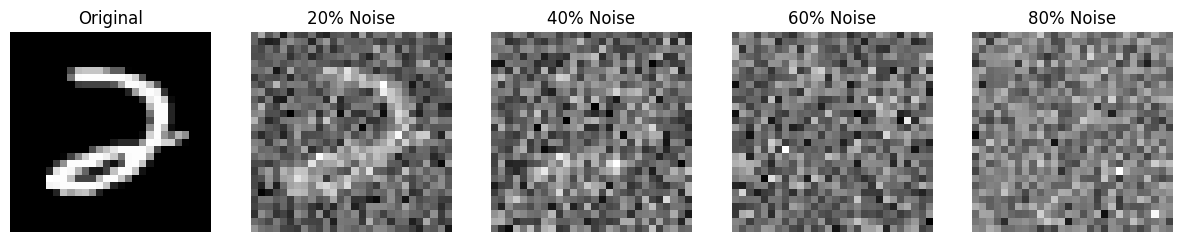

'\n# Try a non-linear noise schedule\nbeta_alt = torch.linspace(beta_start, beta_end, n_steps)**2\nalpha_alt = 1 - beta_alt\nalpha_bar_alt = torch.cumprod(alpha_alt, dim=0)\n# How would this affect the diffusion process?\n'

In [ ]:
# Visualization function to show how noise progressively affects images
def show_noise_progression(image, num_steps=5):
    """
    Visualize how an image gets progressively noisier in the diffusion process.

    Args:
        image (torch.Tensor): Original clean image [C, H, W]
        num_steps (int): Number of noise levels to show
    """
    plt.figure(figsize=(15, 3))

    # Show original image
    plt.subplot(1, num_steps, 1)
    if IMG_CH == 1:  # Grayscale image
        plt.imshow(image[0].cpu(), cmap='gray')
    else:  # Color image
        img = image.permute(1, 2, 0).cpu()  # Change from [C,H,W] to [H,W,C]
        if img.min() < 0:  # If normalized between -1 and 1
            img = (img + 1) / 2  # Rescale to [0,1] for display
        plt.imshow(img)
    plt.title('Original')
    plt.axis('off')

    # Show progressively noisier versions
    for i in range(1, num_steps):
        # Calculate timestep index based on percentage through the process
        t_idx = int((i/num_steps) * n_steps)
        t = torch.tensor([t_idx]).to(device)

        # Add noise corresponding to timestep t
        noisy_image, _ = add_noise(image.unsqueeze(0), t)

        # Display the noisy image
        plt.subplot(1, num_steps, i+1)
        if IMG_CH == 1:
            plt.imshow(noisy_image[0][0].cpu(), cmap='gray')
        else:
            img = noisy_image[0].permute(1, 2, 0).cpu()
            if img.min() < 0:
                img = (img + 1) / 2
            plt.imshow(img)
        plt.title(f'{int((i/num_steps) * 100)}% Noise')
        plt.axis('off')
    plt.show()

# Show an example of noise progression on a real image
sample_batch = next(iter(train_dataloader))  # Get first batch
sample_image = sample_batch[0][0].to(device)  # Get first image
show_noise_progression(sample_image)

# Student Activity: Try different noise schedules
# Uncomment and modify these lines to experiment:
"""
# Try a non-linear noise schedule
beta_alt = torch.linspace(beta_start, beta_end, n_steps)**2
alpha_alt = 1 - beta_alt
alpha_bar_alt = torch.cumprod(alpha_alt, dim=0)
# How would this affect the diffusion process?
"""

## Step 5: Training Our Model

Now we'll teach our AI to generate images. This process:
1. Takes a clear image
2. Adds random noise to it
3. Asks our AI to predict what noise was added
4. Helps our AI learn from its mistakes

This will take a while, but we'll see progress as it learns!

In [ ]:
# # Create our model and move it to GPU if available
# model = UNet(
#     T=n_steps,                 # Number of diffusion time steps
#     img_ch=IMG_CH,             # Number of channels in our images (1 for grayscale, 3 for RGB)
#     img_size=IMG_SIZE,         # Size of input images (28 for MNIST, 32 for CIFAR-10)
#     down_chs=(16, 32, 64),    # Channel dimensions for each downsampling level
#     t_embed_dim=8,             # Dimension for time step embeddings
#     c_embed_dim=N_CLASSES      # Number of classes for conditioning
# ).to(device)

# # Print model summary
# print(f"\n{'='*50}")
# print(f"MODEL ARCHITECTURE SUMMARY")
# print(f"{'='*50}")
# print(f"Input resolution: {IMG_SIZE}x{IMG_SIZE}")
# print(f"Input channels: {IMG_CH}")
# print(f"Time steps: {n_steps}")
# print(f"Condition classes: {N_CLASSES}")
# print(f"GPU acceleration: {'Yes' if device.type == 'cuda' else 'No'}")

# # Validate model parameters and estimate memory requirements
# # Hint: Create functions to count parameters and estimate memory usage

# # Enter your code here:
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters())

# def estimate_memory_usage(model):
#     return sum(p.numel() * p.element_size() for p in model.parameters()) / (1024**2)


# # Your code to verify data ranges and integrity
# # Hint: Create functions to check data ranges in training and validation data

# # Enter your code here:
# def check_data_ranges(train_dataloader, val_dataloader):
#   train_batch_data, train_batch_labels = next(iter(train_dataloader))
#   print(f"Training data range: {train_batch_data.min().items} to {train_batch_data.max().items}")
#   print(f"Training mean: {train_batch_data.mean().items}")
#   print(f"Training std: {train_batch_data.std().items}")
#   val_batch_data, val_batch_labels = next(iter(val_dataloader))
#   print(f"Validation data range: {val_batch_data.min().items} to {val_batch_data.max().items}")
#   print(f"Validation mean: {val_batch_data.mean().items}")
#   print(f"Validation std: {val_batch_data.std().items}")


# # Set up the optimizer with parameters tuned for diffusion models
# # Note: Lower learning rates tend to work better for diffusion models
# initial_lr = 0.001  # Starting learning rate
# weight_decay = 1e-5  # L2 regularization to prevent overfitting

# optimizer = Adam(
#     model.parameters(),
#     lr=initial_lr,
#     weight_decay=weight_decay
# )

# # Learning rate scheduler to reduce LR when validation loss plateaus
# # This helps fine-tune the model toward the end of training
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode='min',              # Reduce LR when monitored value stops decreasing
#     factor=0.5,              # Multiply LR by this factor
#     patience=5,              # Number of epochs with no improvement after which LR will be reduced
#     verbose=True,            # Print message when LR is reduced
#     min_lr=1e-6              # Lower bound on the learning rate
# )

# # STUDENT EXPERIMENT:
# # Try different channel configurations and see how they affect:
# # 1. Model size (parameter count)
# # 2. Training time
# # 3. Generated image quality
# #
# # Suggestions:
# # - Smaller: down_chs=(16, 32, 64)
# # - Larger: down_chs=(64, 128, 256, 512)

Created DownBlock: in_chs=16, out_chs=32, spatial_reduction=2x
Created DownBlock: in_chs=32, out_chs=64, spatial_reduction=2x
Created UpBlock: in_chs_prev=64, skip_chs=32, out_chs_current=32, spatial_increase=2x
Created UpBlock: in_chs_prev=32, skip_chs=16, out_chs_current=16, spatial_increase=2x
Created UNet with 3 scale levels
Channel dimensions: (16, 32, 64)

MODEL ARCHITECTURE SUMMARY
Input resolution: 28x28
Input channels: 1
Time steps: 1000
Condition classes: 10
GPU acceleration: Yes

STARTING TRAINING

Epoch 1/60
--------------------


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Step 0/750, Loss: 1.0853
  Step 100/750, Loss: 0.0673
  Step 200/750, Loss: 0.0461
  Step 300/750, Loss: 0.0615
  Step 400/750, Loss: 0.0436
  Step 500/750, Loss: 0.0522
  Generating samples...


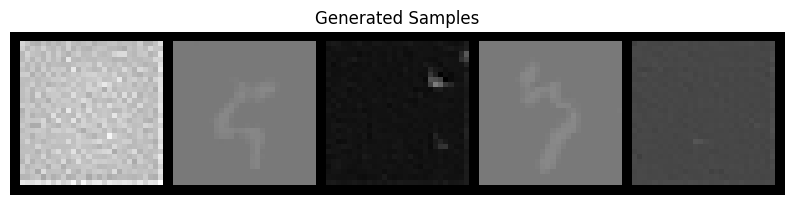

  Step 600/750, Loss: 0.0490
  Step 700/750, Loss: 0.0349

Training - Epoch 1 average loss: 0.0617
Running validation...
Validation - Epoch 1 average loss: 0.0359
Learning rate: 0.001000

Generating samples for visual progress check...


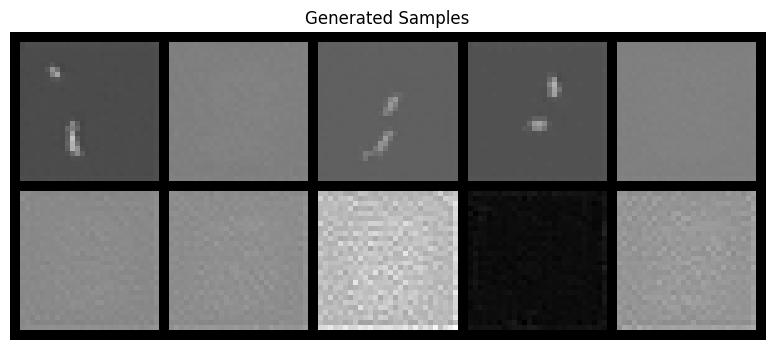

Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0359)


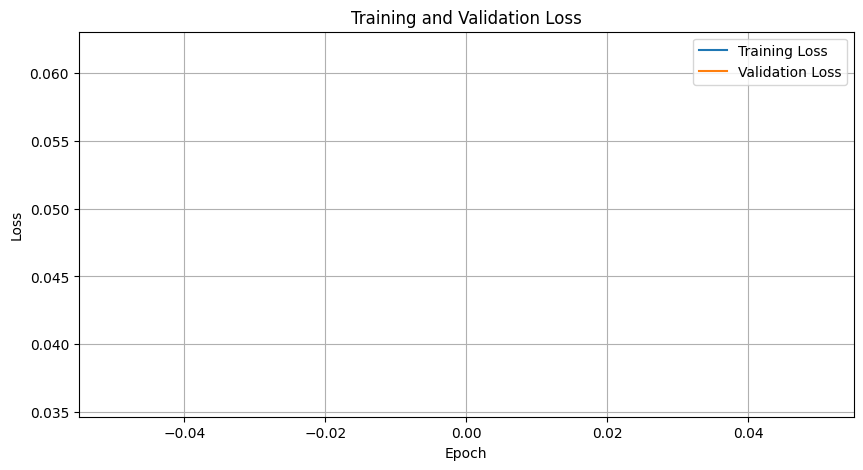


Epoch 2/60
--------------------
  Step 0/750, Loss: 0.0340
  Step 100/750, Loss: 0.0416
  Step 200/750, Loss: 0.0412
  Step 300/750, Loss: 0.0377
  Step 400/750, Loss: 0.0350
  Step 500/750, Loss: 0.0339
  Generating samples...


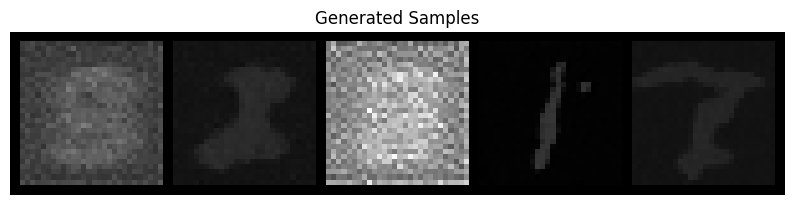

  Step 600/750, Loss: 0.0338
  Step 700/750, Loss: 0.0299

Training - Epoch 2 average loss: 0.0337
Running validation...
Validation - Epoch 2 average loss: 0.0326
Learning rate: 0.001000
Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0326)

Epoch 3/60
--------------------
  Step 0/750, Loss: 0.0358
  Step 100/750, Loss: 0.0328
  Step 200/750, Loss: 0.0255
  Step 300/750, Loss: 0.0340
  Step 400/750, Loss: 0.0272
  Step 500/750, Loss: 0.0285
  Generating samples...


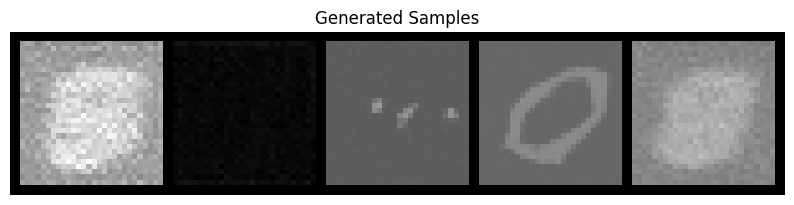

  Step 600/750, Loss: 0.0284
  Step 700/750, Loss: 0.0304

Training - Epoch 3 average loss: 0.0313
Running validation...
Validation - Epoch 3 average loss: 0.0303
Learning rate: 0.001000

Generating samples for visual progress check...


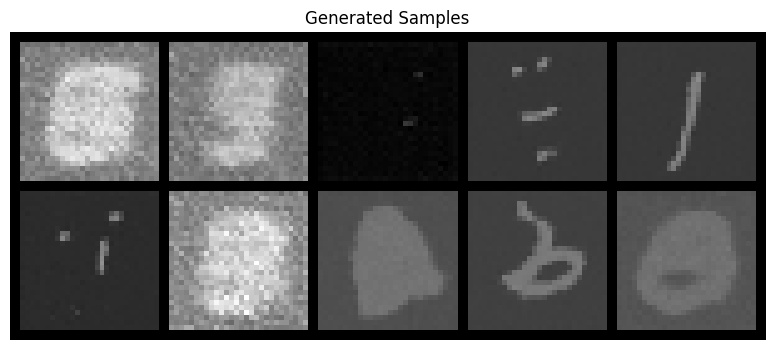

Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0303)

Epoch 4/60
--------------------
  Step 0/750, Loss: 0.0216
  Step 100/750, Loss: 0.0352
  Step 200/750, Loss: 0.0245
  Step 300/750, Loss: 0.0260
  Step 400/750, Loss: 0.0270
  Step 500/750, Loss: 0.0339
  Generating samples...


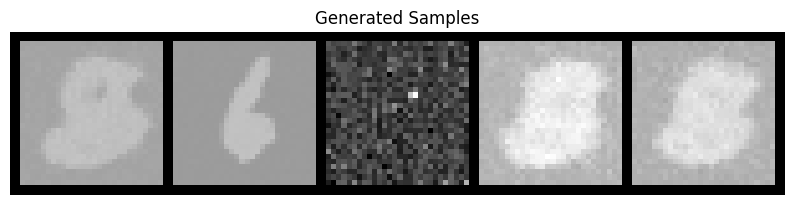

  Step 600/750, Loss: 0.0258
  Step 700/750, Loss: 0.0303

Training - Epoch 4 average loss: 0.0298
Running validation...
Validation - Epoch 4 average loss: 0.0283
Learning rate: 0.001000
Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0283)

Epoch 5/60
--------------------
  Step 0/750, Loss: 0.0261
  Step 100/750, Loss: 0.0292
  Step 200/750, Loss: 0.0244
  Step 300/750, Loss: 0.0278
  Step 400/750, Loss: 0.0298
  Step 500/750, Loss: 0.0285
  Generating samples...


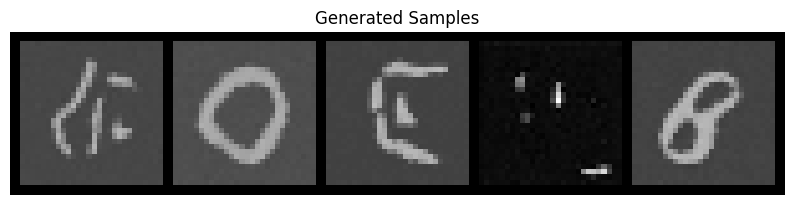

  Step 600/750, Loss: 0.0266
  Step 700/750, Loss: 0.0283

Training - Epoch 5 average loss: 0.0290
Running validation...
Validation - Epoch 5 average loss: 0.0284
Learning rate: 0.001000

Generating samples for visual progress check...


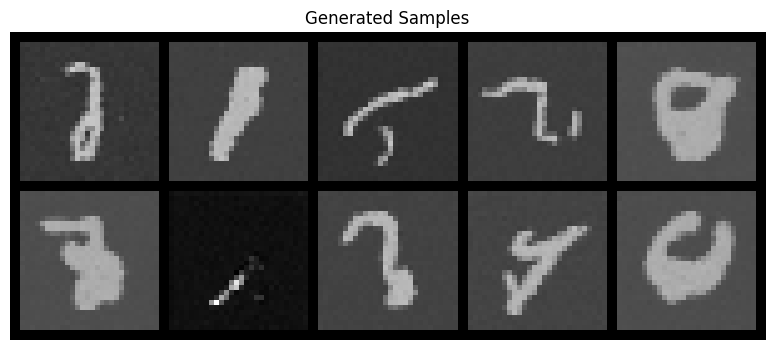

No improvement for 1/10 epochs

Epoch 6/60
--------------------
  Step 0/750, Loss: 0.0272
  Step 100/750, Loss: 0.0285
  Step 200/750, Loss: 0.0257
  Step 300/750, Loss: 0.0238
  Step 400/750, Loss: 0.0230
  Step 500/750, Loss: 0.0289
  Generating samples...


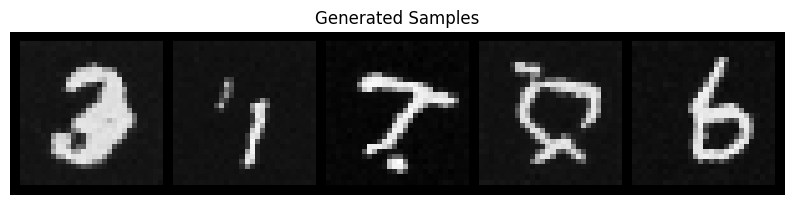

  Step 600/750, Loss: 0.0238
  Step 700/750, Loss: 0.0255

Training - Epoch 6 average loss: 0.0282
Running validation...
Validation - Epoch 6 average loss: 0.0273
Learning rate: 0.001000
Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0273)


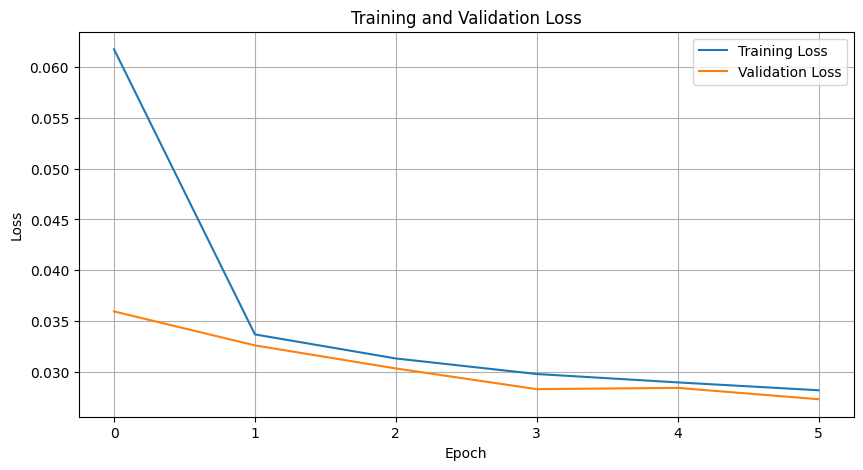


Epoch 7/60
--------------------
  Step 0/750, Loss: 0.0300
  Step 100/750, Loss: 0.0218
  Step 200/750, Loss: 0.0252
  Step 300/750, Loss: 0.0229
  Step 400/750, Loss: 0.0381
  Step 500/750, Loss: 0.0351
  Generating samples...


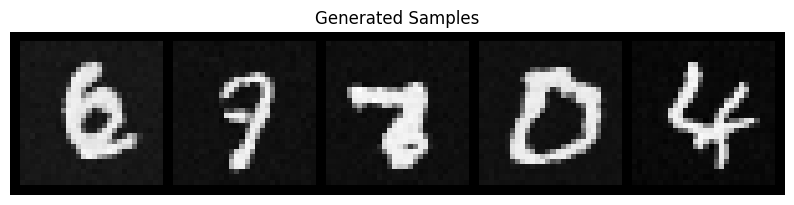

  Step 600/750, Loss: 0.0233
  Step 700/750, Loss: 0.0204

Training - Epoch 7 average loss: 0.0269
Running validation...
Validation - Epoch 7 average loss: 0.0261
Learning rate: 0.001000

Generating samples for visual progress check...


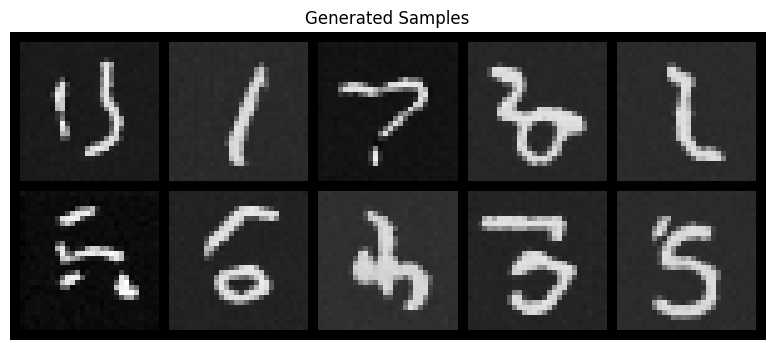

Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0261)

Epoch 8/60
--------------------
  Step 0/750, Loss: 0.0201
  Step 100/750, Loss: 0.0285
  Step 200/750, Loss: 0.0244
  Step 300/750, Loss: 0.0258
  Step 400/750, Loss: 0.0361
  Step 500/750, Loss: 0.0329
  Generating samples...


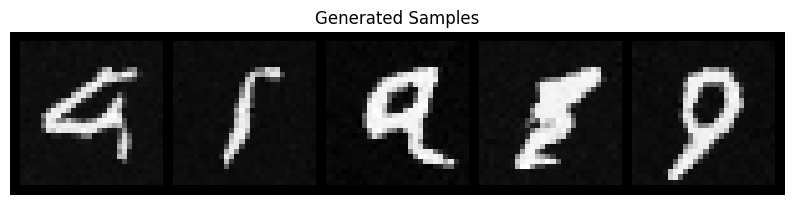

  Step 600/750, Loss: 0.0322
  Step 700/750, Loss: 0.0217

Training - Epoch 8 average loss: 0.0273
Running validation...
Validation - Epoch 8 average loss: 0.0267
Learning rate: 0.001000
No improvement for 1/10 epochs

Epoch 9/60
--------------------
  Step 0/750, Loss: 0.0293
  Step 100/750, Loss: 0.0246
  Step 200/750, Loss: 0.0381
  Step 300/750, Loss: 0.0236
  Step 400/750, Loss: 0.0288
  Step 500/750, Loss: 0.0259
  Generating samples...


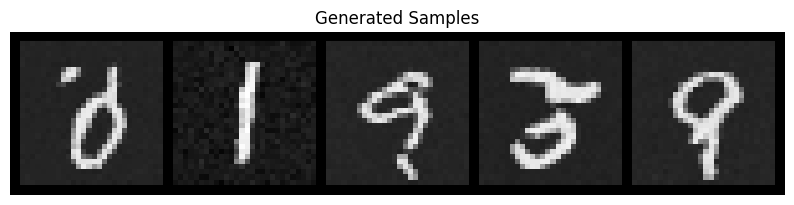

  Step 600/750, Loss: 0.0246
  Step 700/750, Loss: 0.0284

Training - Epoch 9 average loss: 0.0266
Running validation...
Validation - Epoch 9 average loss: 0.0261
Learning rate: 0.001000

Generating samples for visual progress check...


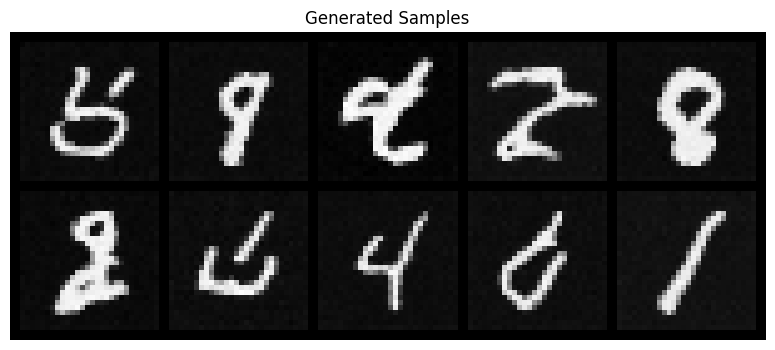

No improvement for 2/10 epochs

Epoch 10/60
--------------------
  Step 0/750, Loss: 0.0218
  Step 100/750, Loss: 0.0256
  Step 200/750, Loss: 0.0207
  Step 300/750, Loss: 0.0297
  Step 400/750, Loss: 0.0269
  Step 500/750, Loss: 0.0278
  Generating samples...


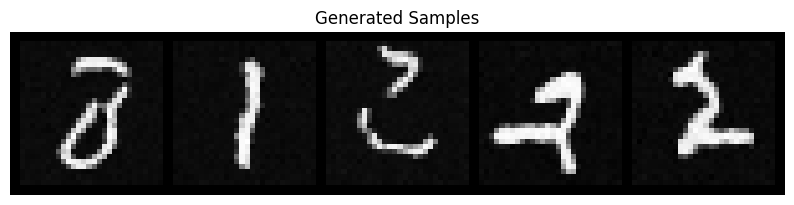

  Step 600/750, Loss: 0.0260
  Step 700/750, Loss: 0.0268

Training - Epoch 10 average loss: 0.0264
Running validation...
Validation - Epoch 10 average loss: 0.0261
Learning rate: 0.001000
No improvement for 3/10 epochs

Epoch 11/60
--------------------
  Step 0/750, Loss: 0.0276
  Step 100/750, Loss: 0.0288
  Step 200/750, Loss: 0.0243
  Step 300/750, Loss: 0.0252
  Step 400/750, Loss: 0.0230
  Step 500/750, Loss: 0.0259
  Generating samples...


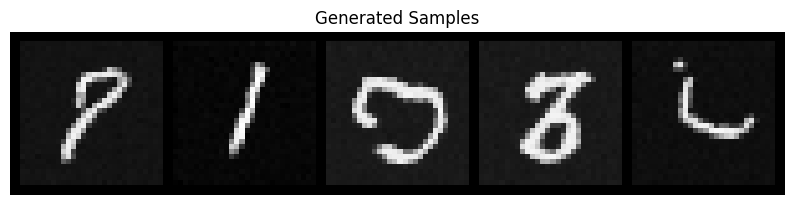

  Step 600/750, Loss: 0.0231
  Step 700/750, Loss: 0.0222

Training - Epoch 11 average loss: 0.0261
Running validation...
Validation - Epoch 11 average loss: 0.0272
Learning rate: 0.001000

Generating samples for visual progress check...


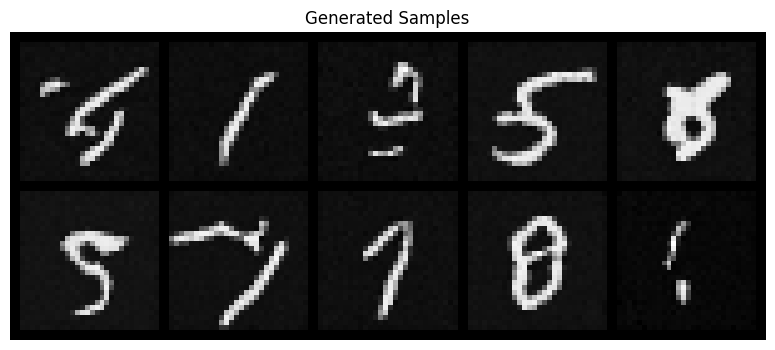

No improvement for 4/10 epochs


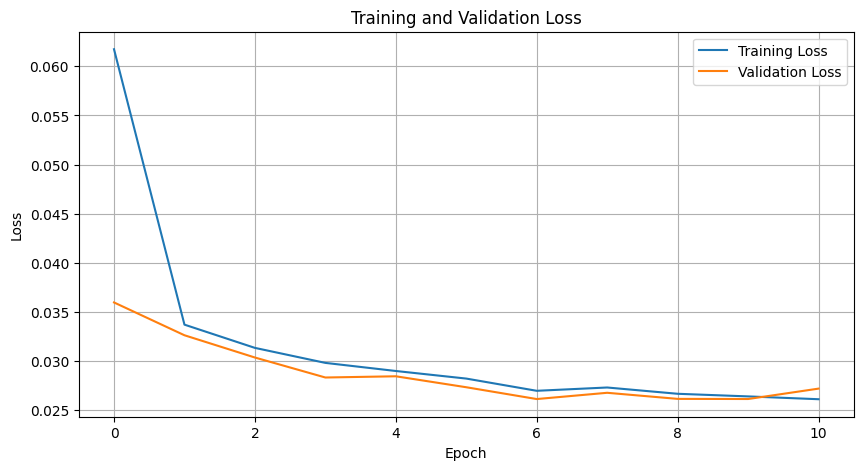


Epoch 12/60
--------------------
  Step 0/750, Loss: 0.0430
  Step 100/750, Loss: 0.0275
  Step 200/750, Loss: 0.0189
  Step 300/750, Loss: 0.0219
  Step 400/750, Loss: 0.0308
  Step 500/750, Loss: 0.0141
  Generating samples...


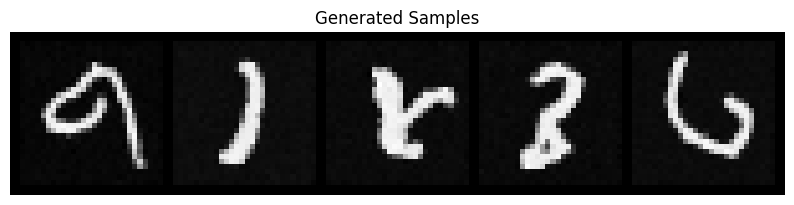

  Step 600/750, Loss: 0.0258
  Step 700/750, Loss: 0.0196

Training - Epoch 12 average loss: 0.0259
Running validation...
Validation - Epoch 12 average loss: 0.0258
Learning rate: 0.001000
Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0258)

Epoch 13/60
--------------------
  Step 0/750, Loss: 0.0305
  Step 100/750, Loss: 0.0283
  Step 200/750, Loss: 0.0347
  Step 300/750, Loss: 0.0187
  Step 400/750, Loss: 0.0200
  Step 500/750, Loss: 0.0238
  Generating samples...


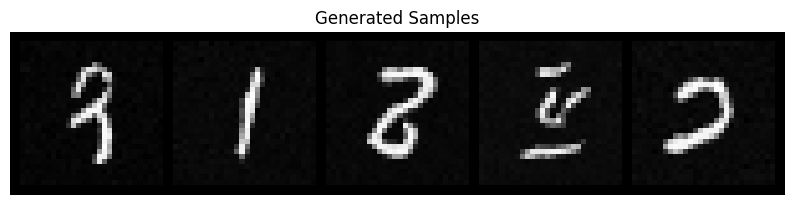

  Step 600/750, Loss: 0.0255
  Step 700/750, Loss: 0.0306

Training - Epoch 13 average loss: 0.0261
Running validation...
Validation - Epoch 13 average loss: 0.0251
Learning rate: 0.001000

Generating samples for visual progress check...


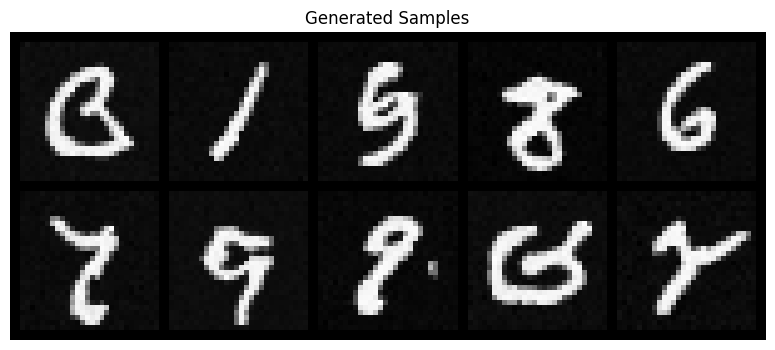

Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0251)

Epoch 14/60
--------------------
  Step 0/750, Loss: 0.0241
  Step 100/750, Loss: 0.0276
  Step 200/750, Loss: 0.0307
  Step 300/750, Loss: 0.0219
  Step 400/750, Loss: 0.0165
  Step 500/750, Loss: 0.0318
  Generating samples...


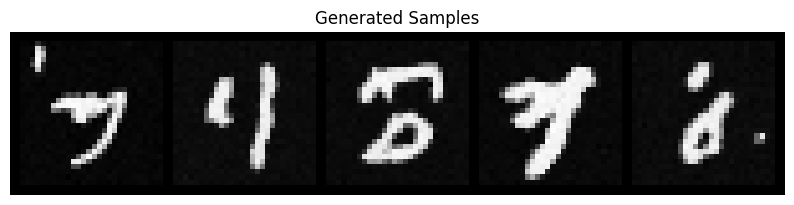

  Step 600/750, Loss: 0.0199
  Step 700/750, Loss: 0.0240

Training - Epoch 14 average loss: 0.0257
Running validation...
Validation - Epoch 14 average loss: 0.0254
Learning rate: 0.001000
No improvement for 1/10 epochs

Epoch 15/60
--------------------
  Step 0/750, Loss: 0.0332
  Step 100/750, Loss: 0.0345
  Step 200/750, Loss: 0.0293
  Step 300/750, Loss: 0.0239
  Step 400/750, Loss: 0.0274
  Step 500/750, Loss: 0.0261
  Generating samples...


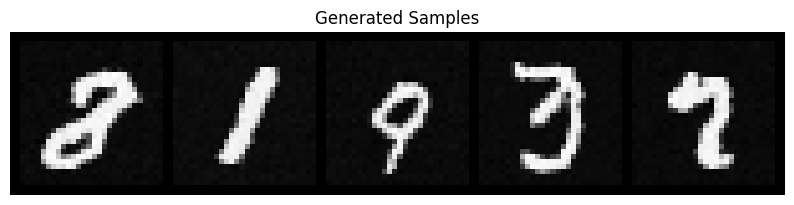

  Step 600/750, Loss: 0.0272
  Step 700/750, Loss: 0.0300

Training - Epoch 15 average loss: 0.0254
Running validation...
Validation - Epoch 15 average loss: 0.0260
Learning rate: 0.001000

Generating samples for visual progress check...


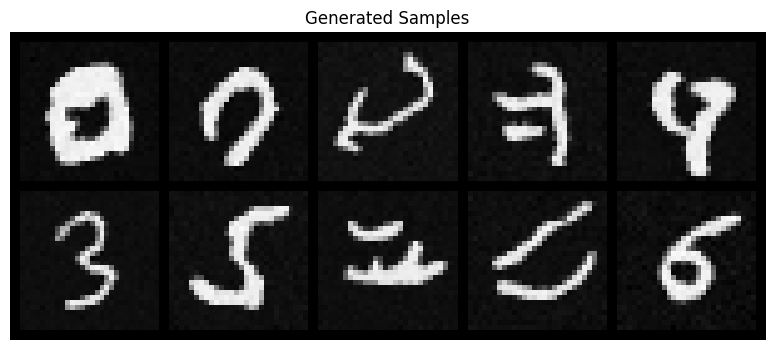

No improvement for 2/10 epochs

Epoch 16/60
--------------------
  Step 0/750, Loss: 0.0231
  Step 100/750, Loss: 0.0197
  Step 200/750, Loss: 0.0257
  Step 300/750, Loss: 0.0318
  Step 400/750, Loss: 0.0244
  Step 500/750, Loss: 0.0170
  Generating samples...


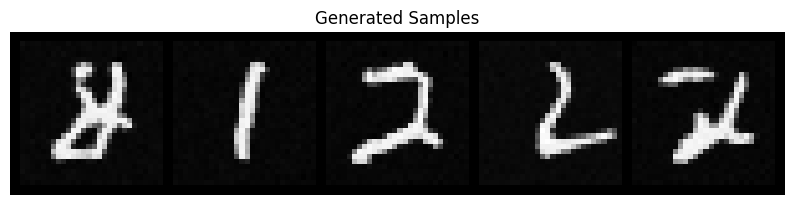

  Step 600/750, Loss: 0.0282
  Step 700/750, Loss: 0.0160

Training - Epoch 16 average loss: 0.0252
Running validation...
Validation - Epoch 16 average loss: 0.0259
Learning rate: 0.001000
No improvement for 3/10 epochs


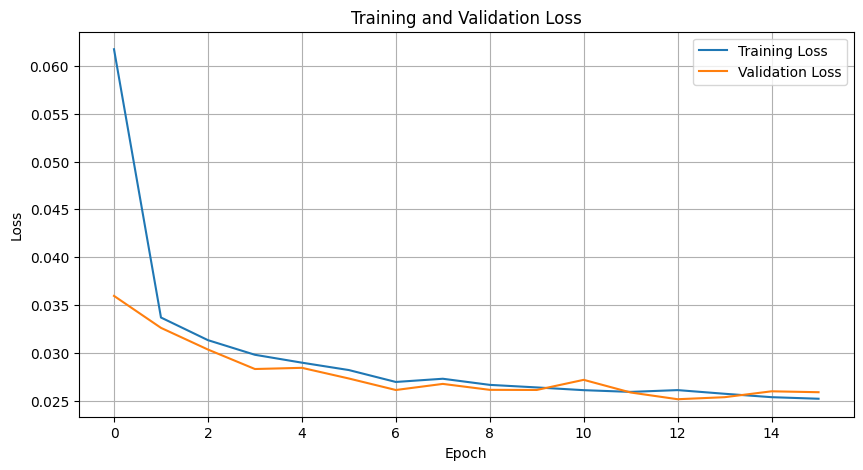


Epoch 17/60
--------------------
  Step 0/750, Loss: 0.0234
  Step 100/750, Loss: 0.0263
  Step 200/750, Loss: 0.0310
  Step 300/750, Loss: 0.0267
  Step 400/750, Loss: 0.0251
  Step 500/750, Loss: 0.0236
  Generating samples...


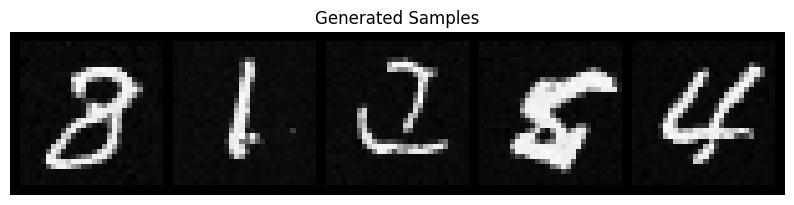

  Step 600/750, Loss: 0.0263
  Step 700/750, Loss: 0.0259

Training - Epoch 17 average loss: 0.0250
Running validation...
Validation - Epoch 17 average loss: 0.0250
Learning rate: 0.001000

Generating samples for visual progress check...


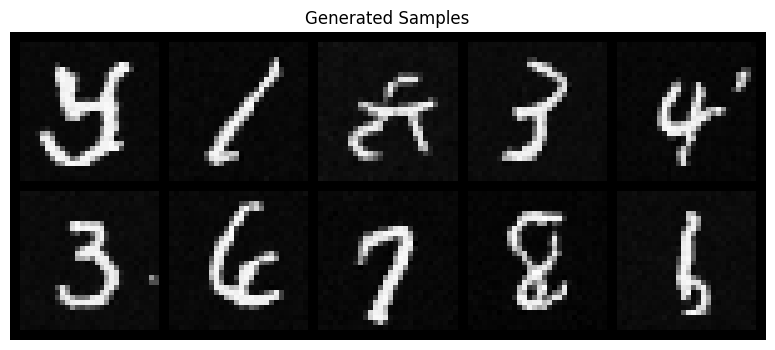

Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0250)

Epoch 18/60
--------------------
  Step 0/750, Loss: 0.0252
  Step 100/750, Loss: 0.0311
  Step 200/750, Loss: 0.0232
  Step 300/750, Loss: 0.0207
  Step 400/750, Loss: 0.0231
  Step 500/750, Loss: 0.0240
  Generating samples...


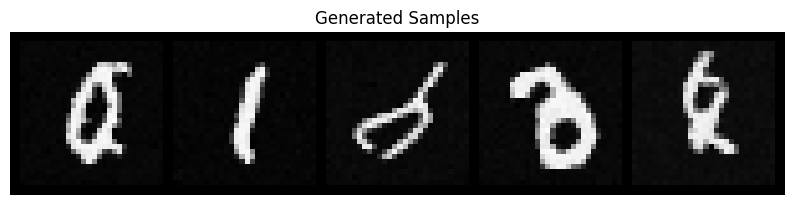

  Step 600/750, Loss: 0.0241
  Step 700/750, Loss: 0.0239

Training - Epoch 18 average loss: 0.0250
Running validation...
Validation - Epoch 18 average loss: 0.0239
Learning rate: 0.001000
Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0239)

Epoch 19/60
--------------------
  Step 0/750, Loss: 0.0267
  Step 100/750, Loss: 0.0245
  Step 200/750, Loss: 0.0177
  Step 300/750, Loss: 0.0251
  Step 400/750, Loss: 0.0215
  Step 500/750, Loss: 0.0265
  Generating samples...


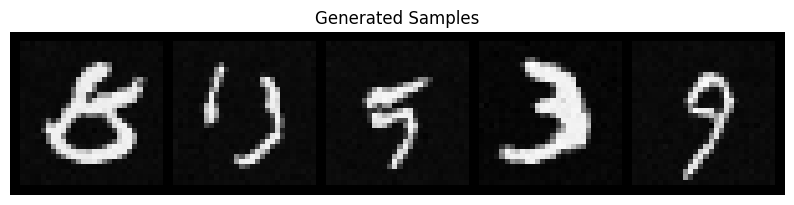

  Step 600/750, Loss: 0.0196
  Step 700/750, Loss: 0.0223

Training - Epoch 19 average loss: 0.0248
Running validation...
Validation - Epoch 19 average loss: 0.0247
Learning rate: 0.001000

Generating samples for visual progress check...


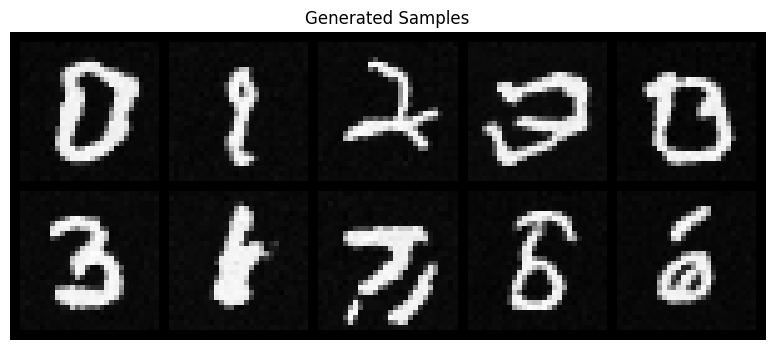

No improvement for 1/10 epochs

Epoch 20/60
--------------------
  Step 0/750, Loss: 0.0301
  Step 100/750, Loss: 0.0317
  Step 200/750, Loss: 0.0270
  Step 300/750, Loss: 0.0229
  Step 400/750, Loss: 0.0276
  Step 500/750, Loss: 0.0259
  Generating samples...


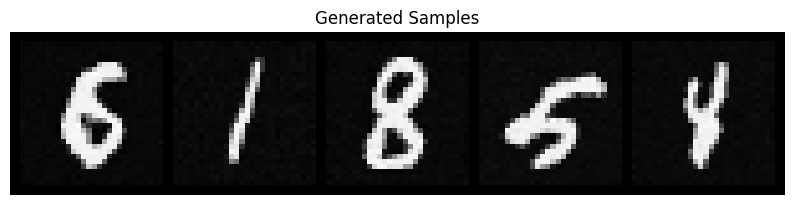

  Step 600/750, Loss: 0.0283
  Step 700/750, Loss: 0.0190

Training - Epoch 20 average loss: 0.0250
Running validation...
Validation - Epoch 20 average loss: 0.0249
Learning rate: 0.001000
No improvement for 2/10 epochs

Epoch 21/60
--------------------
  Step 0/750, Loss: 0.0262
  Step 100/750, Loss: 0.0315
  Step 200/750, Loss: 0.0266
  Step 300/750, Loss: 0.0232
  Step 400/750, Loss: 0.0307
  Step 500/750, Loss: 0.0222
  Generating samples...


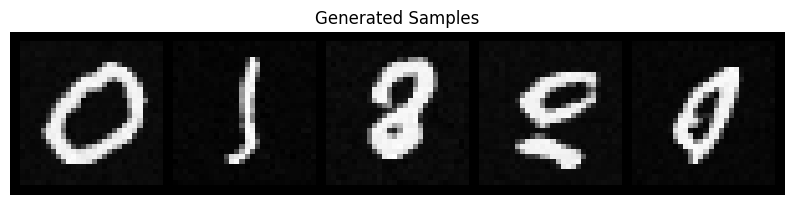

  Step 600/750, Loss: 0.0271
  Step 700/750, Loss: 0.0250

Training - Epoch 21 average loss: 0.0247
Running validation...
Validation - Epoch 21 average loss: 0.0247
Learning rate: 0.001000

Generating samples for visual progress check...


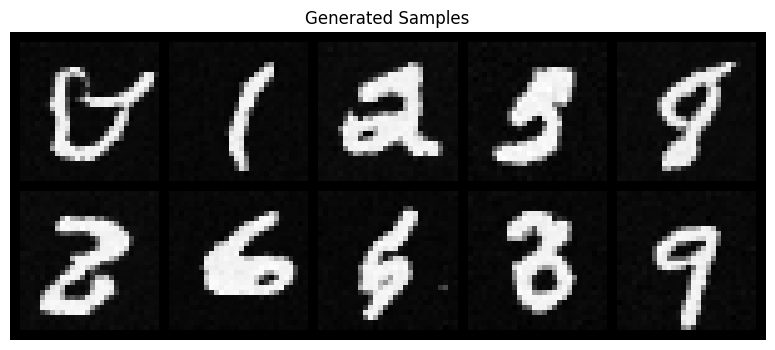

No improvement for 3/10 epochs


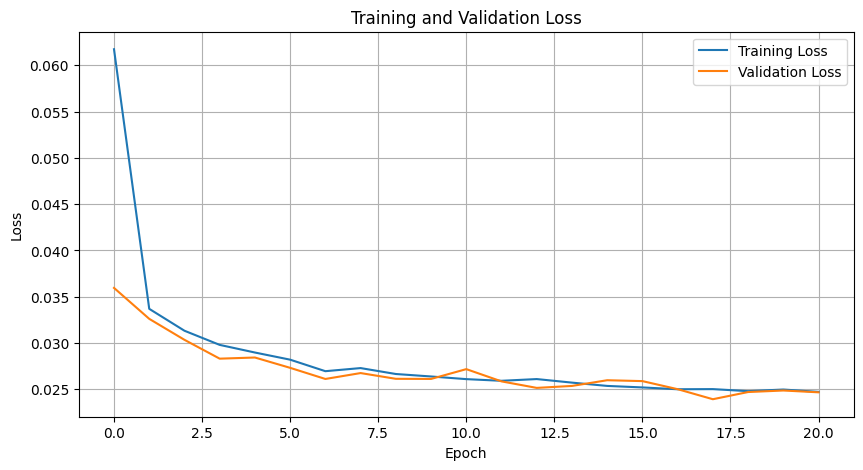


Epoch 22/60
--------------------
  Step 0/750, Loss: 0.0302
  Step 100/750, Loss: 0.0250
  Step 200/750, Loss: 0.0204
  Step 300/750, Loss: 0.0184
  Step 400/750, Loss: 0.0239
  Step 500/750, Loss: 0.0265
  Generating samples...


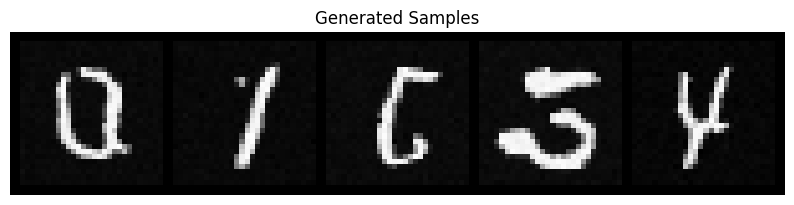

  Step 600/750, Loss: 0.0206
  Step 700/750, Loss: 0.0248

Training - Epoch 22 average loss: 0.0244
Running validation...
Validation - Epoch 22 average loss: 0.0242
Learning rate: 0.001000
No improvement for 4/10 epochs

Epoch 23/60
--------------------
  Step 0/750, Loss: 0.0246
  Step 100/750, Loss: 0.0272
  Step 200/750, Loss: 0.0294
  Step 300/750, Loss: 0.0224
  Step 400/750, Loss: 0.0283
  Step 500/750, Loss: 0.0267
  Generating samples...


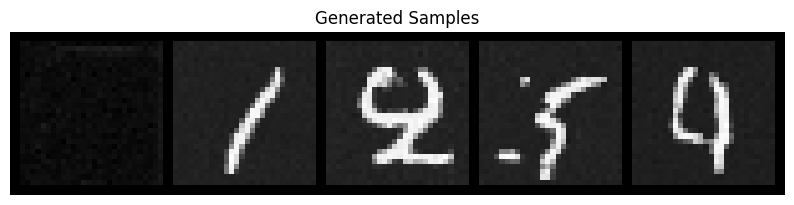

  Step 600/750, Loss: 0.0344
  Step 700/750, Loss: 0.0327

Training - Epoch 23 average loss: 0.0244
Running validation...
Validation - Epoch 23 average loss: 0.0254
Learning rate: 0.001000

Generating samples for visual progress check...


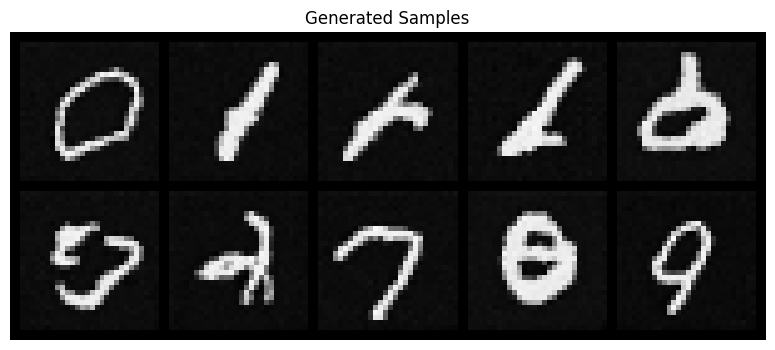

No improvement for 5/10 epochs

Epoch 24/60
--------------------
  Step 0/750, Loss: 0.0174
  Step 100/750, Loss: 0.0246
  Step 200/750, Loss: 0.0199
  Step 300/750, Loss: 0.0228
  Step 400/750, Loss: 0.0251
  Step 500/750, Loss: 0.0232
  Generating samples...


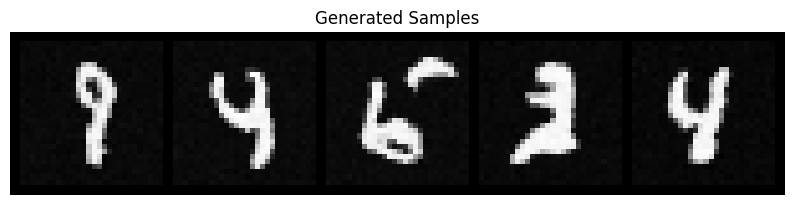

  Step 600/750, Loss: 0.0210
  Step 700/750, Loss: 0.0243

Training - Epoch 24 average loss: 0.0243
Running validation...
Validation - Epoch 24 average loss: 0.0243
Learning rate: 0.000200
No improvement for 6/10 epochs

Epoch 25/60
--------------------
  Step 0/750, Loss: 0.0304
  Step 100/750, Loss: 0.0221
  Step 200/750, Loss: 0.0321
  Step 300/750, Loss: 0.0252
  Step 400/750, Loss: 0.0202
  Step 500/750, Loss: 0.0194
  Generating samples...


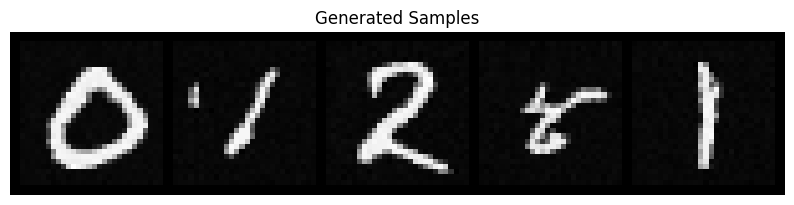

  Step 600/750, Loss: 0.0205
  Step 700/750, Loss: 0.0290

Training - Epoch 25 average loss: 0.0230
Running validation...
Validation - Epoch 25 average loss: 0.0229
Learning rate: 0.000200

Generating samples for visual progress check...


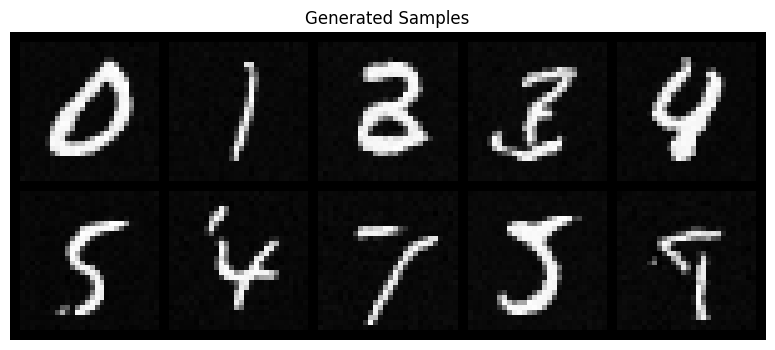

Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0229)

Epoch 26/60
--------------------
  Step 0/750, Loss: 0.0314
  Step 100/750, Loss: 0.0228
  Step 200/750, Loss: 0.0215
  Step 300/750, Loss: 0.0190
  Step 400/750, Loss: 0.0154
  Step 500/750, Loss: 0.0237
  Generating samples...


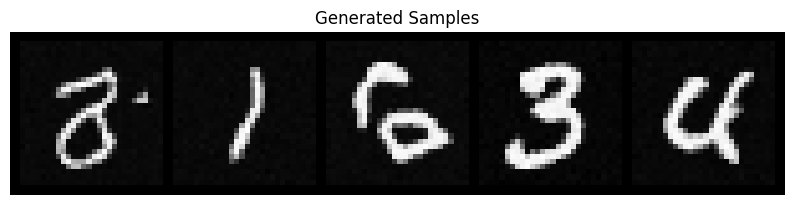

  Step 600/750, Loss: 0.0259
  Step 700/750, Loss: 0.0218

Training - Epoch 26 average loss: 0.0230
Running validation...
Validation - Epoch 26 average loss: 0.0232
Learning rate: 0.000200
No improvement for 1/10 epochs


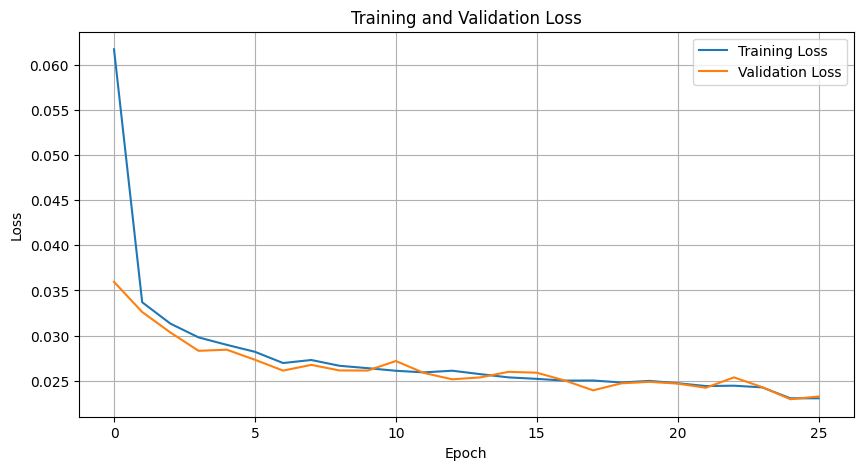


Epoch 27/60
--------------------
  Step 0/750, Loss: 0.0203
  Step 100/750, Loss: 0.0164
  Step 200/750, Loss: 0.0198
  Step 300/750, Loss: 0.0157
  Step 400/750, Loss: 0.0222
  Step 500/750, Loss: 0.0350
  Generating samples...


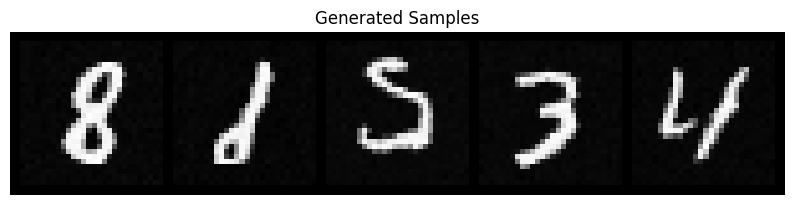

  Step 600/750, Loss: 0.0226
  Step 700/750, Loss: 0.0264

Training - Epoch 27 average loss: 0.0230
Running validation...
Validation - Epoch 27 average loss: 0.0228
Learning rate: 0.000200

Generating samples for visual progress check...


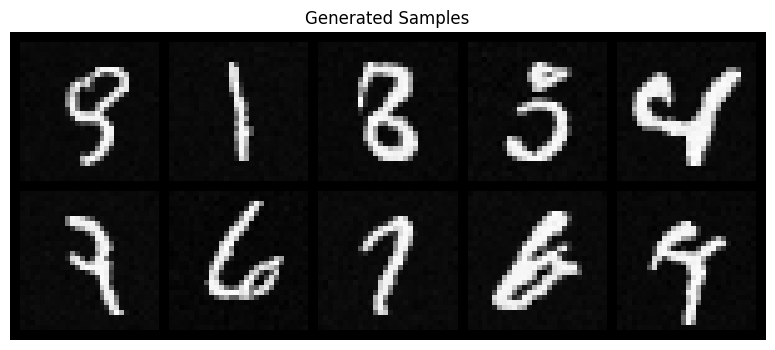

Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0228)

Epoch 28/60
--------------------
  Step 0/750, Loss: 0.0254
  Step 100/750, Loss: 0.0218
  Step 200/750, Loss: 0.0212
  Step 300/750, Loss: 0.0273
  Step 400/750, Loss: 0.0235
  Step 500/750, Loss: 0.0207
  Generating samples...


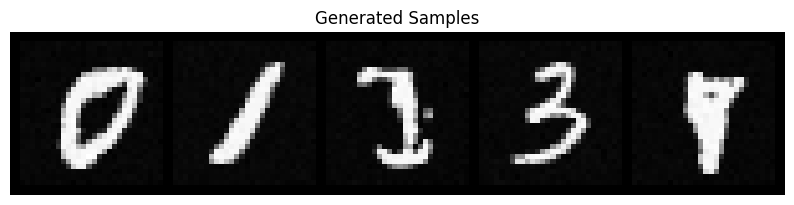

  Step 600/750, Loss: 0.0225
  Step 700/750, Loss: 0.0279

Training - Epoch 28 average loss: 0.0226
Running validation...
Validation - Epoch 28 average loss: 0.0231
Learning rate: 0.000200
No improvement for 1/10 epochs

Epoch 29/60
--------------------
  Step 0/750, Loss: 0.0242
  Step 100/750, Loss: 0.0184
  Step 200/750, Loss: 0.0235
  Step 300/750, Loss: 0.0193
  Step 400/750, Loss: 0.0245
  Step 500/750, Loss: 0.0200
  Generating samples...


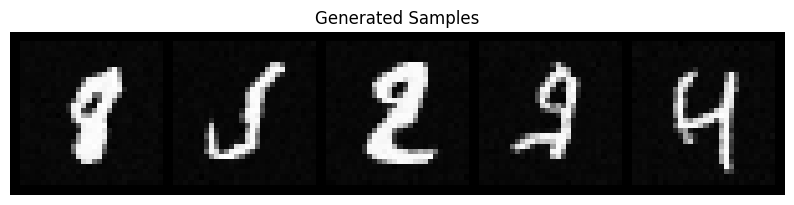

  Step 600/750, Loss: 0.0208
  Step 700/750, Loss: 0.0251

Training - Epoch 29 average loss: 0.0231
Running validation...
Validation - Epoch 29 average loss: 0.0227
Learning rate: 0.000200

Generating samples for visual progress check...


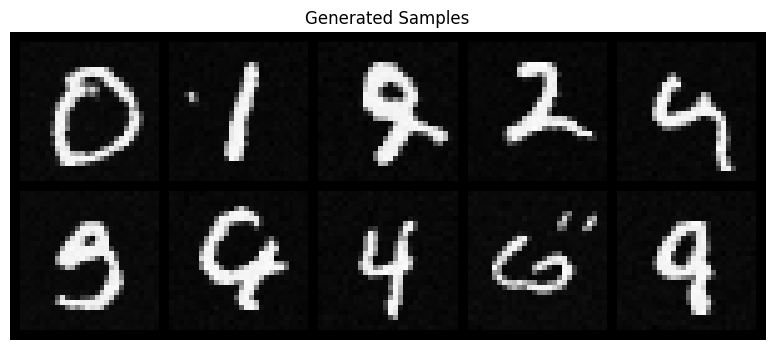

Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0227)

Epoch 30/60
--------------------
  Step 0/750, Loss: 0.0237
  Step 100/750, Loss: 0.0221
  Step 200/750, Loss: 0.0203
  Step 300/750, Loss: 0.0264
  Step 400/750, Loss: 0.0215
  Step 500/750, Loss: 0.0177
  Generating samples...


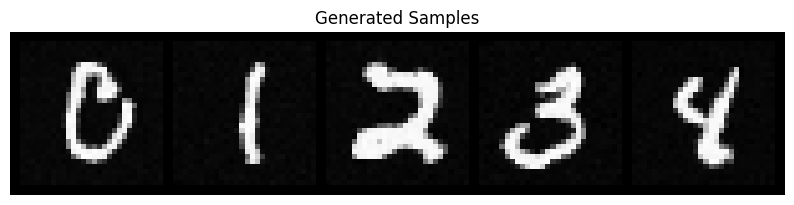

  Step 600/750, Loss: 0.0254
  Step 700/750, Loss: 0.0241

Training - Epoch 30 average loss: 0.0228
Running validation...
Validation - Epoch 30 average loss: 0.0227
Learning rate: 0.000200
Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0227)

Epoch 31/60
--------------------
  Step 0/750, Loss: 0.0220
  Step 100/750, Loss: 0.0298
  Step 200/750, Loss: 0.0207
  Step 300/750, Loss: 0.0199
  Step 400/750, Loss: 0.0188
  Step 500/750, Loss: 0.0261
  Generating samples...


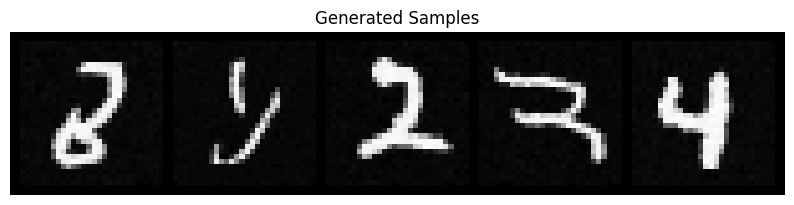

  Step 600/750, Loss: 0.0162
  Step 700/750, Loss: 0.0194

Training - Epoch 31 average loss: 0.0227
Running validation...
Validation - Epoch 31 average loss: 0.0232
Learning rate: 0.000200

Generating samples for visual progress check...


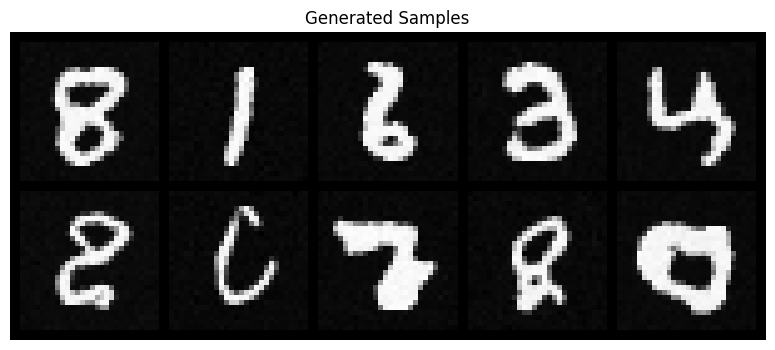

No improvement for 1/10 epochs


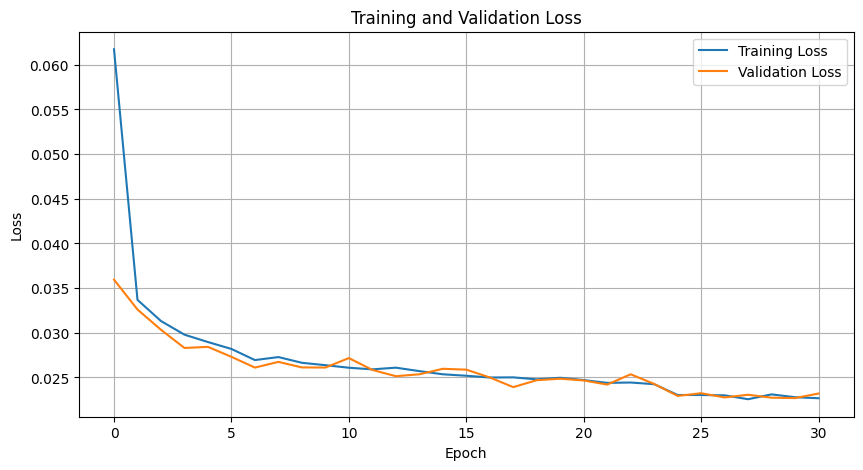


Epoch 32/60
--------------------
  Step 0/750, Loss: 0.0251
  Step 100/750, Loss: 0.0196
  Step 200/750, Loss: 0.0213
  Step 300/750, Loss: 0.0288
  Step 400/750, Loss: 0.0206
  Step 500/750, Loss: 0.0162
  Generating samples...


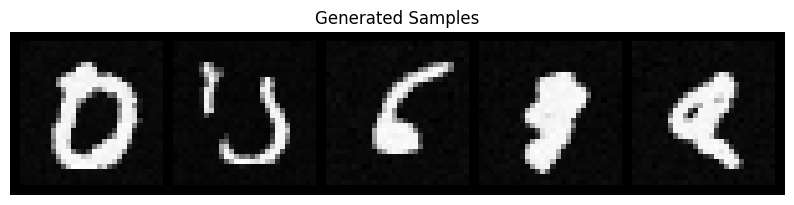

  Step 600/750, Loss: 0.0269
  Step 700/750, Loss: 0.0325

Training - Epoch 32 average loss: 0.0228
Running validation...
Validation - Epoch 32 average loss: 0.0227
Learning rate: 0.000200
Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0227)

Epoch 33/60
--------------------
  Step 0/750, Loss: 0.0284
  Step 100/750, Loss: 0.0248
  Step 200/750, Loss: 0.0180
  Step 300/750, Loss: 0.0203
  Step 400/750, Loss: 0.0270
  Step 500/750, Loss: 0.0189
  Generating samples...


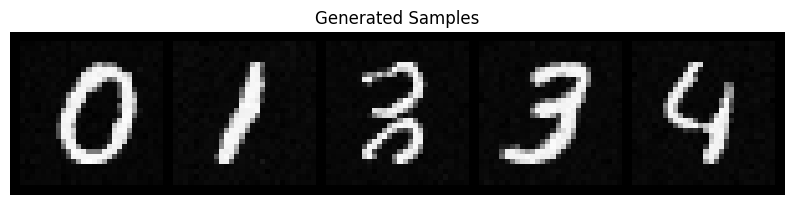

  Step 600/750, Loss: 0.0221
  Step 700/750, Loss: 0.0255

Training - Epoch 33 average loss: 0.0230
Running validation...
Validation - Epoch 33 average loss: 0.0230
Learning rate: 0.000200

Generating samples for visual progress check...


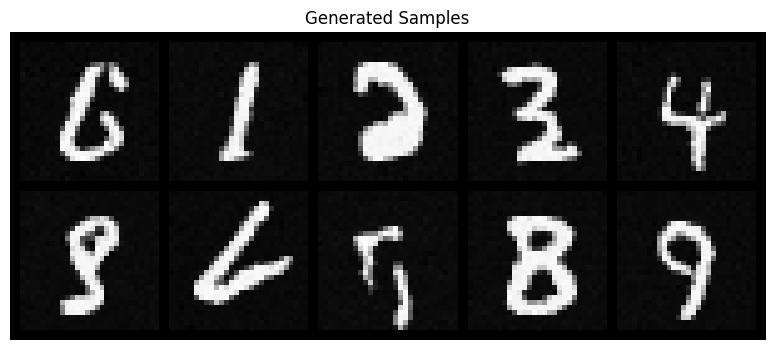

No improvement for 1/10 epochs

Epoch 34/60
--------------------
  Step 0/750, Loss: 0.0249
  Step 100/750, Loss: 0.0168
  Step 200/750, Loss: 0.0215
  Step 300/750, Loss: 0.0254
  Step 400/750, Loss: 0.0229
  Step 500/750, Loss: 0.0182
  Generating samples...


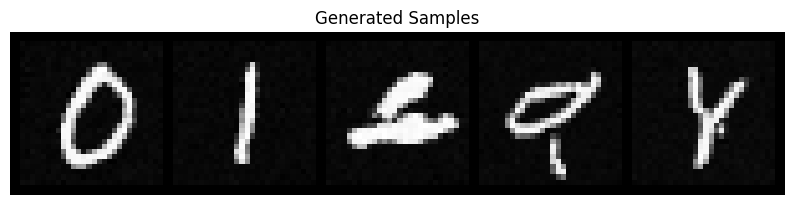

  Step 600/750, Loss: 0.0200
  Step 700/750, Loss: 0.0235

Training - Epoch 34 average loss: 0.0228
Running validation...
Validation - Epoch 34 average loss: 0.0228
Learning rate: 0.000200
No improvement for 2/10 epochs

Epoch 35/60
--------------------
  Step 0/750, Loss: 0.0214
  Step 100/750, Loss: 0.0215
  Step 200/750, Loss: 0.0110
  Step 300/750, Loss: 0.0218
  Step 400/750, Loss: 0.0242
  Step 500/750, Loss: 0.0212
  Generating samples...


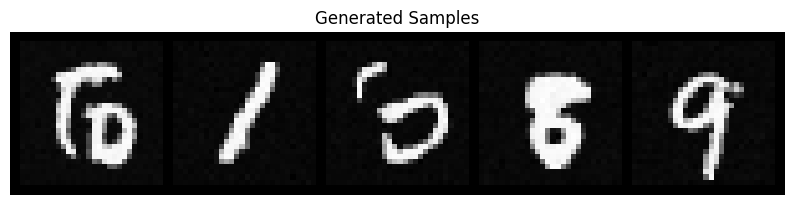

  Step 600/750, Loss: 0.0305
  Step 700/750, Loss: 0.0221

Training - Epoch 35 average loss: 0.0226
Running validation...
Validation - Epoch 35 average loss: 0.0222
Learning rate: 0.000200

Generating samples for visual progress check...


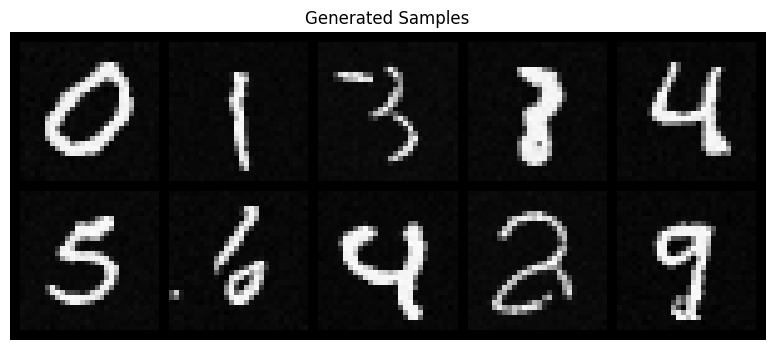

Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0222)

Epoch 36/60
--------------------
  Step 0/750, Loss: 0.0271
  Step 100/750, Loss: 0.0186
  Step 200/750, Loss: 0.0158
  Step 300/750, Loss: 0.0227
  Step 400/750, Loss: 0.0188
  Step 500/750, Loss: 0.0265
  Generating samples...


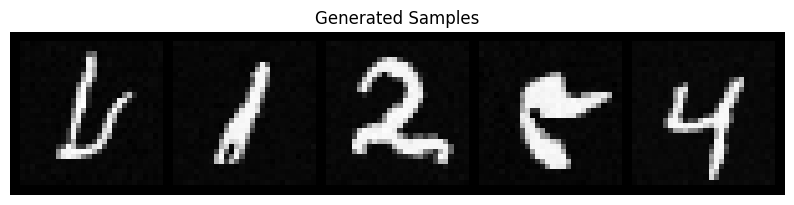

  Step 600/750, Loss: 0.0186
  Step 700/750, Loss: 0.0239

Training - Epoch 36 average loss: 0.0229
Running validation...
Validation - Epoch 36 average loss: 0.0226
Learning rate: 0.000200
No improvement for 1/10 epochs


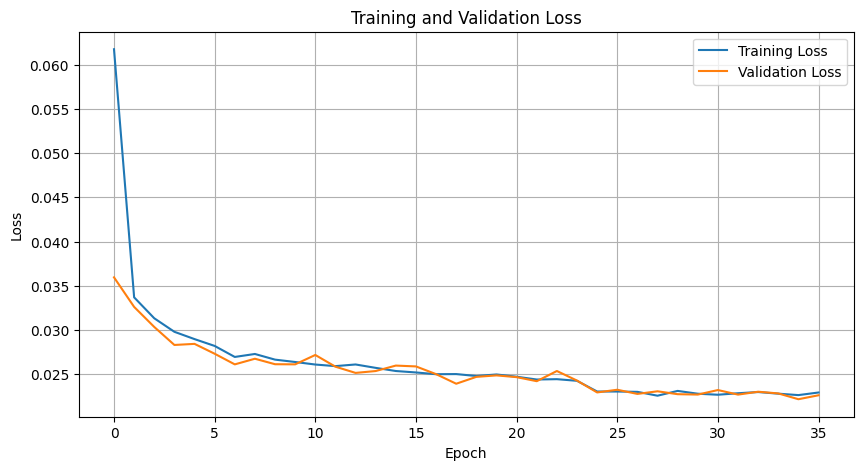


Epoch 37/60
--------------------
  Step 0/750, Loss: 0.0271
  Step 100/750, Loss: 0.0281
  Step 200/750, Loss: 0.0220
  Step 300/750, Loss: 0.0263
  Step 400/750, Loss: 0.0233
  Step 500/750, Loss: 0.0201
  Generating samples...


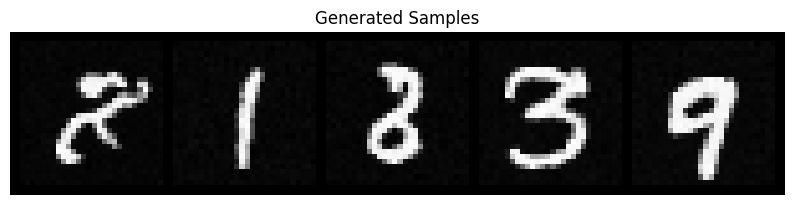

  Step 600/750, Loss: 0.0273
  Step 700/750, Loss: 0.0222

Training - Epoch 37 average loss: 0.0229
Running validation...
Validation - Epoch 37 average loss: 0.0227
Learning rate: 0.000200

Generating samples for visual progress check...


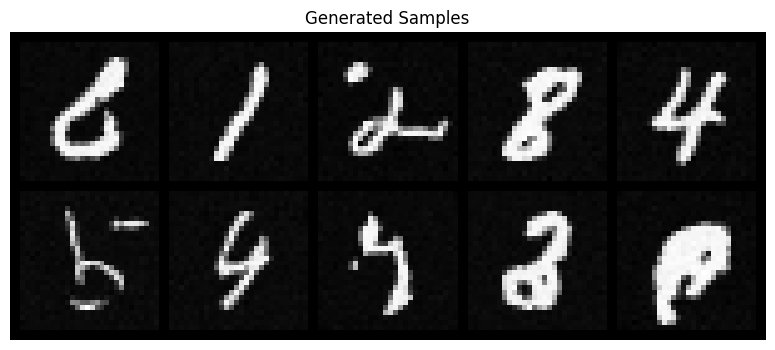

No improvement for 2/10 epochs

Epoch 38/60
--------------------
  Step 0/750, Loss: 0.0243
  Step 100/750, Loss: 0.0176
  Step 200/750, Loss: 0.0339
  Step 300/750, Loss: 0.0273
  Step 400/750, Loss: 0.0176
  Step 500/750, Loss: 0.0175
  Generating samples...


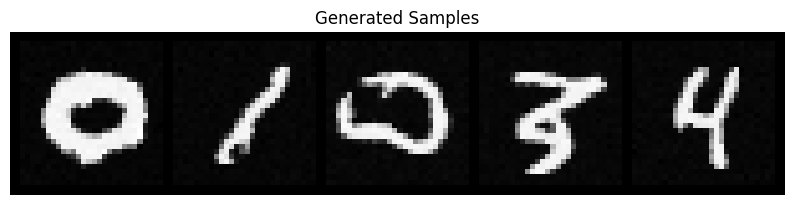

  Step 600/750, Loss: 0.0293
  Step 700/750, Loss: 0.0224

Training - Epoch 38 average loss: 0.0225
Running validation...
Validation - Epoch 38 average loss: 0.0226
Learning rate: 0.000200
No improvement for 3/10 epochs

Epoch 39/60
--------------------
  Step 0/750, Loss: 0.0356
  Step 100/750, Loss: 0.0273
  Step 200/750, Loss: 0.0176
  Step 300/750, Loss: 0.0215
  Step 400/750, Loss: 0.0285
  Step 500/750, Loss: 0.0201
  Generating samples...


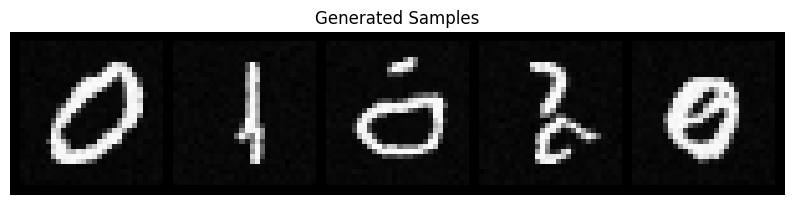

  Step 600/750, Loss: 0.0223
  Step 700/750, Loss: 0.0252

Training - Epoch 39 average loss: 0.0226
Running validation...
Validation - Epoch 39 average loss: 0.0225
Learning rate: 0.000200

Generating samples for visual progress check...


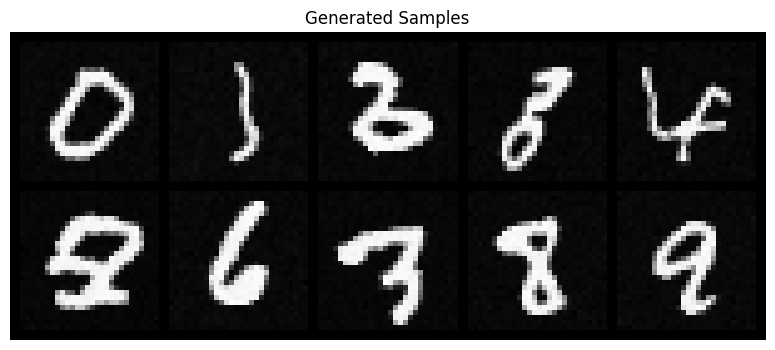

No improvement for 4/10 epochs

Epoch 40/60
--------------------
  Step 0/750, Loss: 0.0310
  Step 100/750, Loss: 0.0220
  Step 200/750, Loss: 0.0179
  Step 300/750, Loss: 0.0323
  Step 400/750, Loss: 0.0175
  Step 500/750, Loss: 0.0245
  Generating samples...


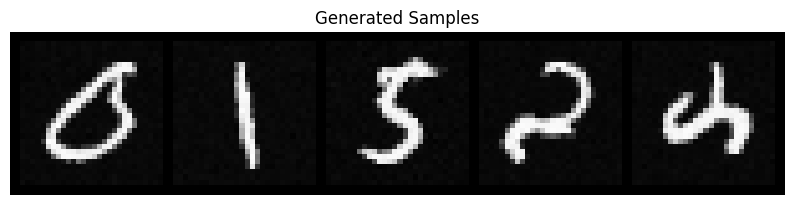

  Step 600/750, Loss: 0.0281
  Step 700/750, Loss: 0.0192

Training - Epoch 40 average loss: 0.0229
Running validation...
Validation - Epoch 40 average loss: 0.0231
Learning rate: 0.000200
No improvement for 5/10 epochs

Epoch 41/60
--------------------
  Step 0/750, Loss: 0.0272
  Step 100/750, Loss: 0.0208
  Step 200/750, Loss: 0.0276
  Step 300/750, Loss: 0.0211
  Step 400/750, Loss: 0.0236
  Step 500/750, Loss: 0.0243
  Generating samples...


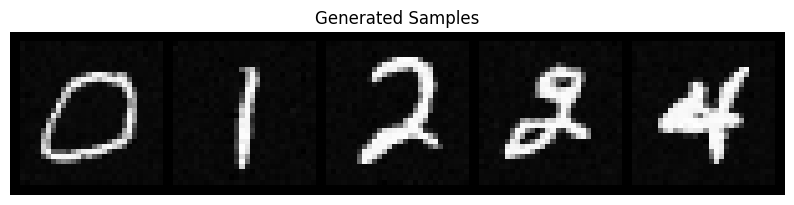

  Step 600/750, Loss: 0.0292
  Step 700/750, Loss: 0.0277

Training - Epoch 41 average loss: 0.0229
Running validation...
Validation - Epoch 41 average loss: 0.0223
Learning rate: 0.000040

Generating samples for visual progress check...


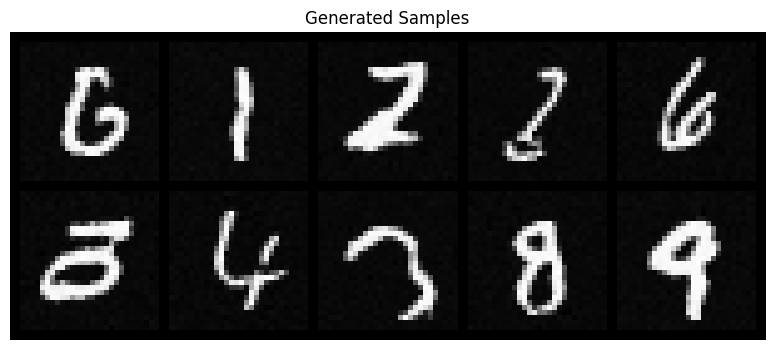

No improvement for 6/10 epochs


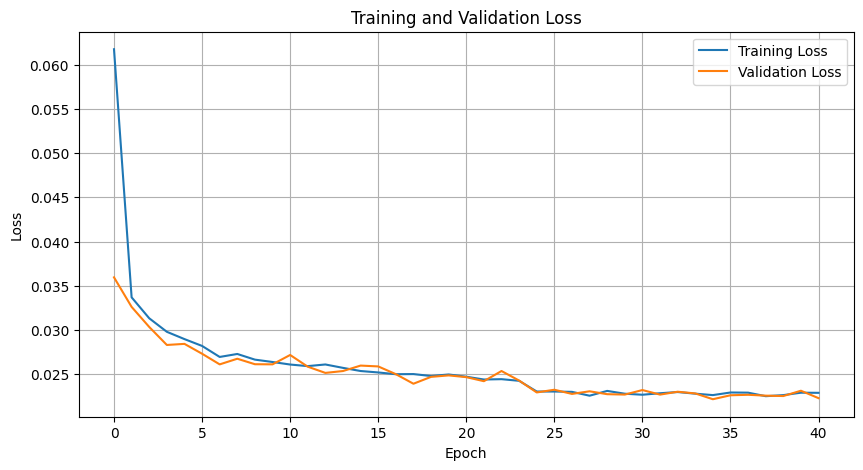


Epoch 42/60
--------------------
  Step 0/750, Loss: 0.0257
  Step 100/750, Loss: 0.0175
  Step 200/750, Loss: 0.0175
  Step 300/750, Loss: 0.0172
  Step 400/750, Loss: 0.0299
  Step 500/750, Loss: 0.0195
  Generating samples...


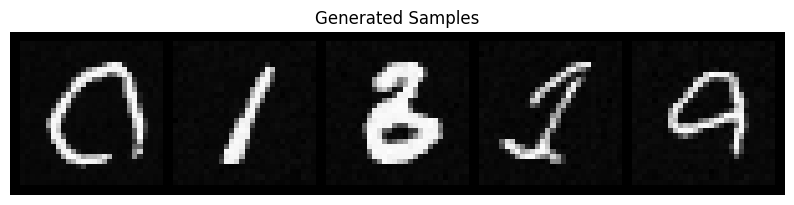

  Step 600/750, Loss: 0.0294
  Step 700/750, Loss: 0.0221

Training - Epoch 42 average loss: 0.0222
Running validation...
Validation - Epoch 42 average loss: 0.0225
Learning rate: 0.000040
No improvement for 7/10 epochs

Epoch 43/60
--------------------
  Step 0/750, Loss: 0.0196
  Step 100/750, Loss: 0.0197
  Step 200/750, Loss: 0.0257
  Step 300/750, Loss: 0.0275
  Step 400/750, Loss: 0.0236
  Step 500/750, Loss: 0.0298
  Generating samples...


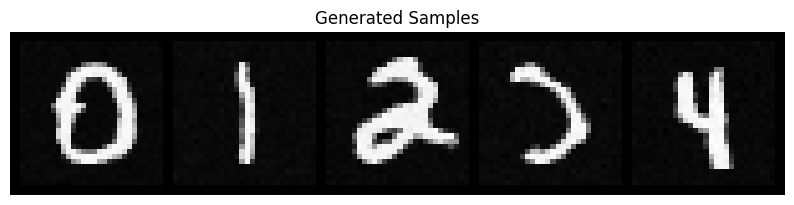

  Step 600/750, Loss: 0.0255
  Step 700/750, Loss: 0.0210

Training - Epoch 43 average loss: 0.0223
Running validation...
Validation - Epoch 43 average loss: 0.0223
Learning rate: 0.000040

Generating samples for visual progress check...


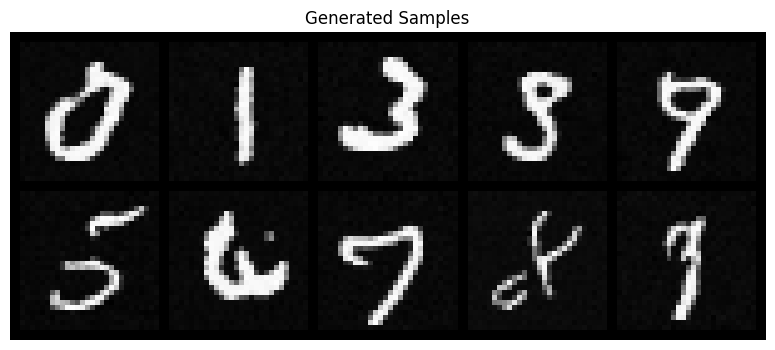

No improvement for 8/10 epochs

Epoch 44/60
--------------------
  Step 0/750, Loss: 0.0319
  Step 100/750, Loss: 0.0249
  Step 200/750, Loss: 0.0175
  Step 300/750, Loss: 0.0230
  Step 400/750, Loss: 0.0218
  Step 500/750, Loss: 0.0260
  Generating samples...


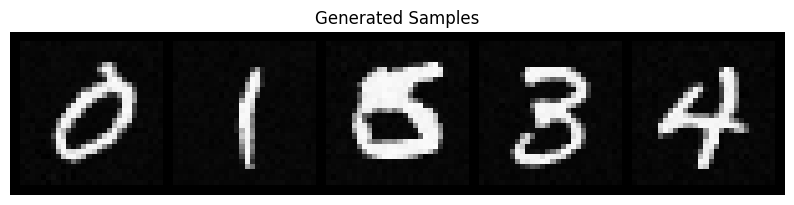

  Step 600/750, Loss: 0.0239
  Step 700/750, Loss: 0.0145

Training - Epoch 44 average loss: 0.0221
Running validation...
Validation - Epoch 44 average loss: 0.0222
Learning rate: 0.000040
No improvement for 9/10 epochs

Epoch 45/60
--------------------
  Step 0/750, Loss: 0.0223
  Step 100/750, Loss: 0.0201
  Step 200/750, Loss: 0.0189
  Step 300/750, Loss: 0.0215
  Step 400/750, Loss: 0.0248
  Step 500/750, Loss: 0.0311
  Generating samples...


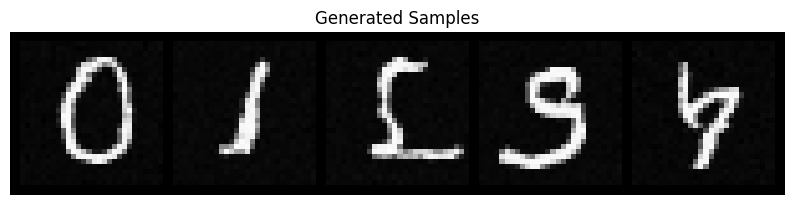

  Step 600/750, Loss: 0.0266
  Step 700/750, Loss: 0.0186

Training - Epoch 45 average loss: 0.0226
Running validation...
Validation - Epoch 45 average loss: 0.0224
Learning rate: 0.000040

Generating samples for visual progress check...


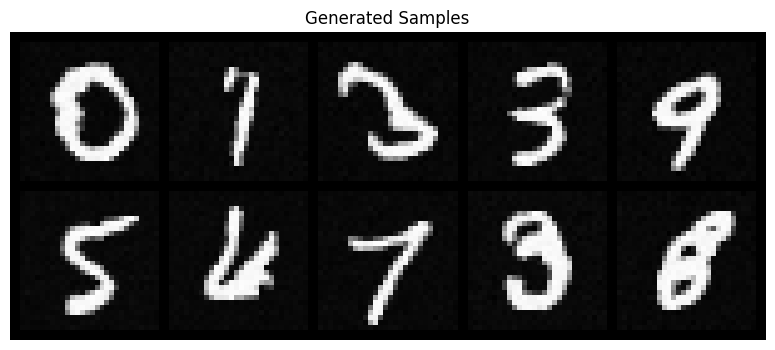

No improvement for 10/10 epochs

Early stopping triggered! No improvement in validation loss.

TRAINING COMPLETE
Best validation loss: 0.0222
Generating final samples...


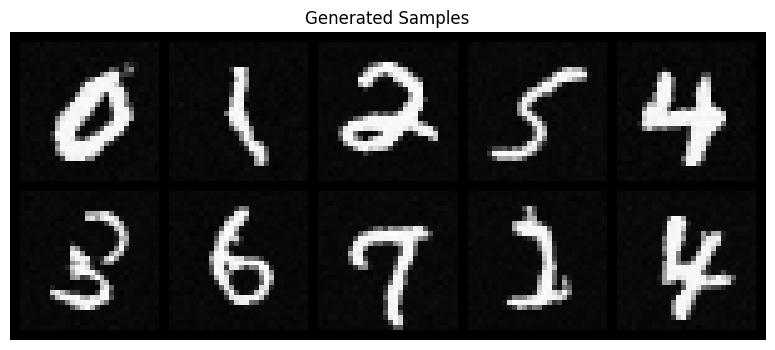

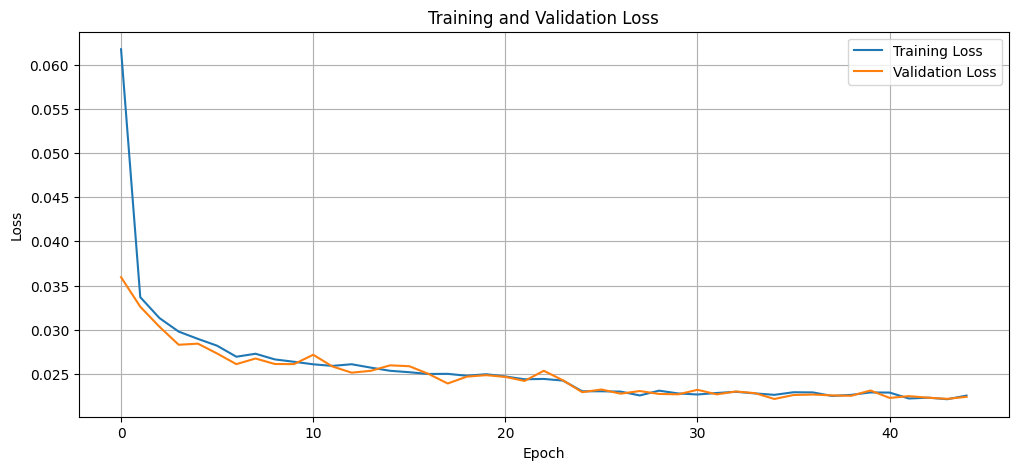

In [ ]:
# Create our model and move it to GPU if available
model = UNet(
    T=n_steps,                 # Number of diffusion time steps
    img_ch=IMG_CH,             # Number of channels in our images (1 for grayscale, 3 for RGB)
    img_size=IMG_SIZE,         # Size of input images (28 for MNIST, 32 for CIFAR-10)
    down_chs=(16, 32, 64),    # Channel dimensions for each downsampling level
    t_embed_dim=8,             # Dimension for time step embeddings
    c_embed_dim=N_CLASSES      # Number of classes for conditioning
).to(device)

# Print model summary
print(f"\n{'='*50}")
print(f"MODEL ARCHITECTURE SUMMARY")
print(f"{'='*50}")
print(f"Input resolution: {IMG_SIZE}x{IMG_SIZE}")
print(f"Input channels: {IMG_CH}")
print(f"Time steps: {n_steps}")
print(f"Condition classes: {N_CLASSES}")
print(f"GPU acceleration: {'Yes' if device.type == 'cuda' else 'No'}")

# Validate model parameters and estimate memory requirements
# Hint: Create functions to count parameters and estimate memory usage

# Enter your code here:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

def estimate_memory_usage(model):
    return sum(p.numel() * p.element_size() for p in model.parameters()) / (1024**2)


# Your code to verify data ranges and integrity
# Hint: Create functions to check data ranges in training and validation data

# Enter your code here:
def check_data_ranges(train_dataloader, val_dataloader):
  train_batch_data, train_batch_labels = next(iter(train_dataloader))
  print(f"Training data range: {train_batch_data.min().items} to {train_batch_data.max().items}")
  print(f"Training mean: {train_batch_data.mean().items}")
  print(f"Training std: {train_batch_data.std().items}")
  val_batch_data, val_batch_labels = next(iter(val_dataloader))
  print(f"Validation data range: {val_batch_data.min().items} to {val_batch_data.max().items}")
  print(f"Validation mean: {val_batch_data.mean().items}")
  print(f"Validation std: {val_batch_data.std().items}")


# Set up the optimizer with parameters tuned for diffusion models
# Note: Lower learning rates tend to work better for diffusion models
initial_lr = 0.001  # Starting learning rate
weight_decay = 1e-5  # L2 regularization to prevent overfitting

optimizer = Adam(
    model.parameters(),
    lr=initial_lr,
    weight_decay=weight_decay
)

# Learning rate scheduler to reduce LR when validation loss plateaus
# This helps fine-tune the model toward the end of training
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',              # Reduce LR when monitored value stops decreasing
    factor=0.1,              # Multiply LR by this factor
    patience=5,              # Number of epochs with no improvement after which LR will be reduced
    verbose=True,            # Print message when LR is reduced
    min_lr=1e-6              # Lower bound on the learning rate
)

# STUDENT EXPERIMENT:
# Try different channel configurations and see how they affect:
# 1. Model size (parameter count)
# 2. Training time
# 3. Generated image quality
#
# Suggestions:
# - Smaller: down_chs=(16, 32, 64)
# - Larger: down_chs=(64, 128, 256, 512)

#######################################################################################################################

# Define helper functions needed for training and evaluation
def validate_model_parameters(model):
    """
    Counts model parameters and estimates memory usage.
    """
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Estimate memory requirements (very approximate)
    param_memory = total_params * 4 / (1024 ** 2)  # MB for params (float32)
    grad_memory = trainable_params * 4 / (1024 ** 2)  # MB for gradients
    buffer_memory = param_memory * 2  # Optimizer state, forward activations, etc.

    print(f"Estimated GPU memory usage: {param_memory + grad_memory + buffer_memory:.1f} MB")

# Define helper functions for verifying data ranges
def verify_data_range(dataloader, name="Dataset"):
    """
    Verifies the range and integrity of the data.
    """
    batch = next(iter(dataloader))[0]
    print(f"\n{name} range check:")
    print(f"Shape: {batch.shape}")
    print(f"Data type: {batch.dtype}")
    print(f"Min value: {batch.min().item():.2f}")
    print(f"Max value: {batch.max().item():.2f}")
    print(f"Contains NaN: {torch.isnan(batch).any().item()}")
    print(f"Contains Inf: {torch.isinf(batch).any().item()}")

# Define helper functions for generating samples during training
def generate_samples(model, n_samples=10):
    """
    Generates sample images using the model for visualization during training.
    """
    model.eval()
    with torch.no_grad():
        # Generate digits 0-9 for visualization
        samples = []
        for digit in range(min(n_samples, 10)):
            # Start with random noise
            x = torch.randn(1, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)

            # Set up conditioning for the digit
            c = torch.tensor([digit]).to(device)
            c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)
            c_mask = torch.ones_like(c.unsqueeze(-1)).to(device)

            # Remove noise step by step
            for t in range(n_steps-1, -1, -1):
                t_batch = torch.full((1,), t).to(device)
                x = remove_noise(x, t_batch, model, c_one_hot, c_mask)

            samples.append(x)

        # Combine samples and display
        samples = torch.cat(samples, dim=0)
        grid = make_grid(samples, nrow=min(n_samples, 5), normalize=True)

        plt.figure(figsize=(10, 4))

        # Display based on channel configuration
        if IMG_CH == 1:
            plt.imshow(grid[0].cpu(), cmap='gray')
        else:
            plt.imshow(grid.permute(1, 2, 0).cpu())

        plt.axis('off')
        plt.title('Generated Samples')
        plt.show()

# Define helper functions for safely saving models
def safe_save_model(model, path, optimizer=None, epoch=None, best_loss=None):
    """
    Safely saves model with error handling and backup.
    """
    try:
        # Create a dictionary with all the elements to save
        save_dict = {
            'model_state_dict': model.state_dict(),
        }

        # Add optional elements if provided
        if optimizer is not None:
            save_dict['optimizer_state_dict'] = optimizer.state_dict()
        if epoch is not None:
            save_dict['epoch'] = epoch
        if best_loss is not None:
            save_dict['best_loss'] = best_loss

        # Create a backup of previous checkpoint if it exists
        if os.path.exists(path):
            backup_path = path + '.backup'
            try:
                os.replace(path, backup_path)
                print(f"Created backup at {backup_path}")
            except Exception as e:
                print(f"Warning: Could not create backup - {e}")

        # Save the new checkpoint
        torch.save(save_dict, path)
        print(f"Model successfully saved to {path}")

    except Exception as e:
        print(f"Error saving model: {e}")
        print("Attempting emergency save...")

        try:
            emergency_path = path + '.emergency'
            torch.save(model.state_dict(), emergency_path)
            print(f"Emergency save successful: {emergency_path}")
        except:
            print("Emergency save failed. Could not save model.")

#################################################################################################################################################
#  Implementation of the training step function
def train_step(x, c):
    """
    Performs a single training step for the diffusion model.

    This function:
    1. Prepares class conditioning
    2. Samples random timesteps for each image
    3. Adds corresponding noise to the images
    4. Asks the model to predict the noise
    5. Calculates the loss between predicted and actual noise

    Args:
        x (torch.Tensor): Batch of clean images [batch_size, channels, height, width]
        c (torch.Tensor): Batch of class labels [batch_size]

    Returns:
        torch.Tensor: Mean squared error loss value
    """
    # Convert number labels to one-hot encoding for class conditioning
    # Example: Label 3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] for MNIST
    c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)

    # Create conditioning mask (all ones for standard training)
    # This would be used for classifier-free guidance if implemented
    c_mask = torch.ones_like(c.unsqueeze(-1)).to(device)

    # Pick random timesteps for each image in the batch
    # Different timesteps allow the model to learn the entire diffusion process
    t = torch.randint(0, n_steps, (x.shape[0],)).to(device)

    # Add noise to images according to the forward diffusion process
    # This simulates images at different stages of the diffusion process
    # Hint: Use the add_noise function you defined earlier

    # Enter your code here:
    x_t, noise = add_noise(x, t)

    # The model tries to predict the exact noise that was added
    # This is the core learning objective of diffusion models
    predicted_noise = model(x_t, t, c_one_hot, c_mask)

    # Calculate loss: how accurately did the model predict the noise?
    # MSE loss works well for image-based diffusion models
    # Hint: Use F.mse_loss to compare predicted and actual noise

    # Enter your code here:
    loss = F.mse_loss(predicted_noise, noise)

    return loss

#################################################################################################################################################
# ---------------------------------------> ORIGINAL CODE FOR CELL <----------------------------------------------
# Implementation of the main training loop
# Training configuration
early_stopping_patience = 10  # Number of epochs without improvement before stopping
gradient_clip_value = 1.0     # Maximum gradient norm for stability
display_frequency = 100       # How often to show progress (in steps)
generate_frequency = 500      # How often to generate samples (in steps)

# Progress tracking variables
best_loss = float('inf')
train_losses = []
val_losses = []
no_improve_epochs = 0

# Training loop
print("\n" + "="*50)
print("STARTING TRAINING")
print("="*50)
model.train()

# Wrap the training loop in a try-except block for better error handling:
# Your code for the training loop
# Hint: Use a try-except block for better error handling
# Process each epoch and each batch, with validation after each epoch

# Enter your code here:

for epoch in range(EPOCHS):
  print(f"\nEpoch {epoch+1}/{EPOCHS}")
  print("-" * 20)

  # Training phase
  model.train()
  epoch_losses = []

  # Process each batch
  for step, (images, labels) in enumerate(train_dataloader):  # Fixed: dataloader → train_dataloader
      images = images.to(device)
      labels = labels.to(device)

      # Training step
      optimizer.zero_grad()
      loss = train_step(images, labels)
      loss.backward()

      # Add gradient clipping for stability
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip_value)

      optimizer.step()
      epoch_losses.append(loss.item())

      # Show progress at regular intervals
      if step % display_frequency == 0:
          print(f"  Step {step}/{len(train_dataloader)}, Loss: {loss.item():.4f}")

          # Generate samples less frequently to save time
          if step % generate_frequency == 0 and step > 0:
              print("  Generating samples...")
              generate_samples(model, n_samples=5)

  # End of epoch - calculate average training loss
  avg_train_loss = sum(epoch_losses) / len(epoch_losses)
  train_losses.append(avg_train_loss)
  print(f"\nTraining - Epoch {epoch+1} average loss: {avg_train_loss:.4f}")

  # Validation phase
  model.eval()
  val_epoch_losses = []
  print("Running validation...")

  with torch.no_grad():  # Disable gradients for validation
      for val_images, val_labels in val_dataloader:
          val_images = val_images.to(device)
          val_labels = val_labels.to(device)

          # Calculate validation loss
          val_loss = train_step(val_images, val_labels)
          val_epoch_losses.append(val_loss.item())

  # Calculate average validation loss
  avg_val_loss = sum(val_epoch_losses) / len(val_epoch_losses)
  val_losses.append(avg_val_loss)
  print(f"Validation - Epoch {epoch+1} average loss: {avg_val_loss:.4f}")

  # Learning rate scheduling based on validation loss
  scheduler.step(avg_val_loss)
  current_lr = optimizer.param_groups[0]['lr']
  print(f"Learning rate: {current_lr:.6f}")

  # Generate samples at the end of each epoch
  if epoch % 2 == 0 or epoch == EPOCHS - 1:
      print("\nGenerating samples for visual progress check...")
      generate_samples(model, n_samples=10)

  # Save best model based on validation loss
  if avg_val_loss < best_loss:
      best_loss = avg_val_loss
      # Use safe_save_model instead of just saving state_dict
      safe_save_model(model, 'best_diffusion_model.pt', optimizer, epoch, best_loss)
      print(f"✓ New best model saved! (Val Loss: {best_loss:.4f})")
      no_improve_epochs = 0
  else:
      no_improve_epochs += 1
      print(f"No improvement for {no_improve_epochs}/{early_stopping_patience} epochs")

  # Early stopping
  if no_improve_epochs >= early_stopping_patience:
      print("\nEarly stopping triggered! No improvement in validation loss.")
      break

  # Plot loss curves every few epochs
  if epoch % 5 == 0 or epoch == EPOCHS - 1:
      plt.figure(figsize=(10, 5))
      plt.plot(train_losses, label='Training Loss')
      plt.plot(val_losses, label='Validation Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.title('Training and Validation Loss')
      plt.legend()
      plt.grid(True)
      plt.show()


# Final wrap-up
print("\n" + "="*50)
print("TRAINING COMPLETE")
print("="*50)
print(f"Best validation loss: {best_loss:.4f}")

# Generate final samples
print("Generating final samples...")
generate_samples(model, n_samples=10)

# Display final loss curves
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Clean up memory
torch.cuda.empty_cache()

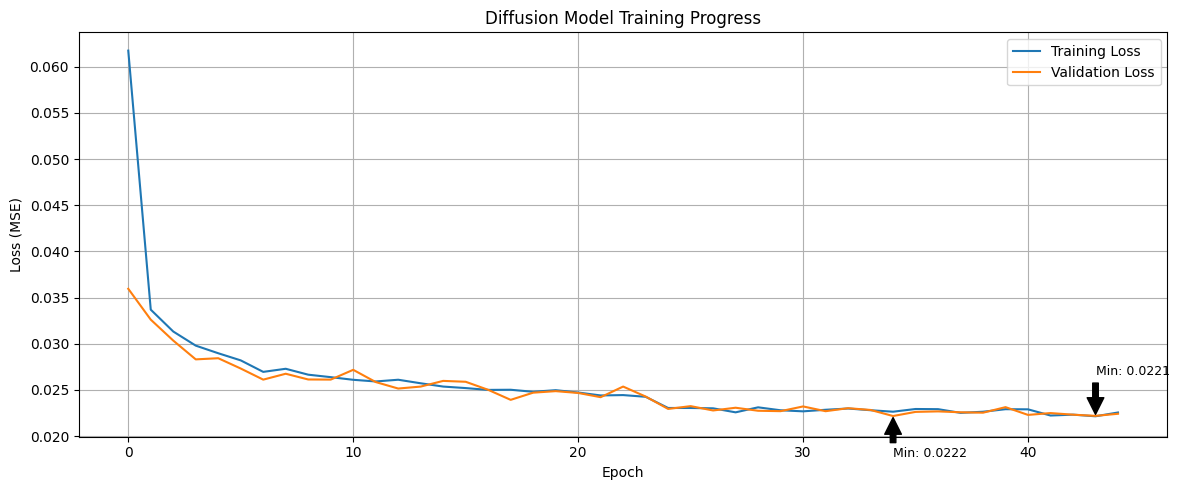


Training Statistics:
------------------------------
Starting training loss:    0.0617
Final training loss:       0.0226
Best training loss:        0.0221
Training loss improvement: 64.1%

Validation Statistics:
------------------------------
Starting validation loss: 0.0359
Final validation loss:    0.0224
Best validation loss:     0.0222


In [ ]:
# Plot training progress
plt.figure(figsize=(12, 5))

# Plot training and validation losses for comparison
plt.plot(train_losses, label='Training Loss')
if len(val_losses) > 0:  # Only plot validation if it exists
    plt.plot(val_losses, label='Validation Loss')

# Improve the plot with better labels and styling
plt.title('Diffusion Model Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Add annotations for key points
if len(train_losses) > 1:
    min_train_idx = train_losses.index(min(train_losses))
    plt.annotate(f'Min: {min(train_losses):.4f}',
                 xy=(min_train_idx, min(train_losses)),
                 xytext=(min_train_idx, min(train_losses)*1.2),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=9)

# Add validation min point if available
if len(val_losses) > 1:
    min_val_idx = val_losses.index(min(val_losses))
    plt.annotate(f'Min: {min(val_losses):.4f}',
                xy=(min_val_idx, min(val_losses)),
                xytext=(min_val_idx, min(val_losses)*0.8),
                arrowprops=dict(facecolor='black', shrink=0.05),
                fontsize=9)

# Set y-axis to start from 0 or slightly lower than min value
plt.ylim(bottom=max(0, min(min(train_losses) if train_losses else float('inf'),
                          min(val_losses) if val_losses else float('inf'))*0.9))

plt.tight_layout()
plt.show()

# Add statistics summary for students to analyze
print("\nTraining Statistics:")
print("-" * 30)
if train_losses:
    print(f"Starting training loss:    {train_losses[0]:.4f}")
    print(f"Final training loss:       {train_losses[-1]:.4f}")
    print(f"Best training loss:        {min(train_losses):.4f}")
    print(f"Training loss improvement: {((train_losses[0] - min(train_losses)) / train_losses[0] * 100):.1f}%")

if val_losses:
    print("\nValidation Statistics:")
    print("-" * 30)
    print(f"Starting validation loss: {val_losses[0]:.4f}")
    print(f"Final validation loss:    {val_losses[-1]:.4f}")
    print(f"Best validation loss:     {min(val_losses):.4f}")

# STUDENT EXERCISE:
# 1. Try modifying this plot to show a smoothed version of the losses
# 2. Create a second plot showing the ratio of validation to training loss
#    (which can indicate overfitting when the ratio increases)

## Step 6: Generating New Images

Now that our model is trained, let's generate some new images! We can:
1. Generate specific numbers
2. Generate multiple versions of each number
3. See how the generation process works step by step

Generating 4 versions of number 0...
  Denoising step 199/999 completed
  Denoising step 399/999 completed
  Denoising step 599/999 completed
  Denoising step 799/999 completed
  Denoising step 999/999 completed
Generating 4 versions of number 1...
  Denoising step 199/999 completed
  Denoising step 399/999 completed
  Denoising step 599/999 completed
  Denoising step 799/999 completed
  Denoising step 999/999 completed
Generating 4 versions of number 2...
  Denoising step 199/999 completed
  Denoising step 399/999 completed
  Denoising step 599/999 completed
  Denoising step 799/999 completed
  Denoising step 999/999 completed
Generating 4 versions of number 3...
  Denoising step 199/999 completed
  Denoising step 399/999 completed
  Denoising step 599/999 completed
  Denoising step 799/999 completed
  Denoising step 999/999 completed
Generating 4 versions of number 4...
  Denoising step 199/999 completed
  Denoising step 399/999 completed
  Denoising step 599/999 completed
  Denoisin

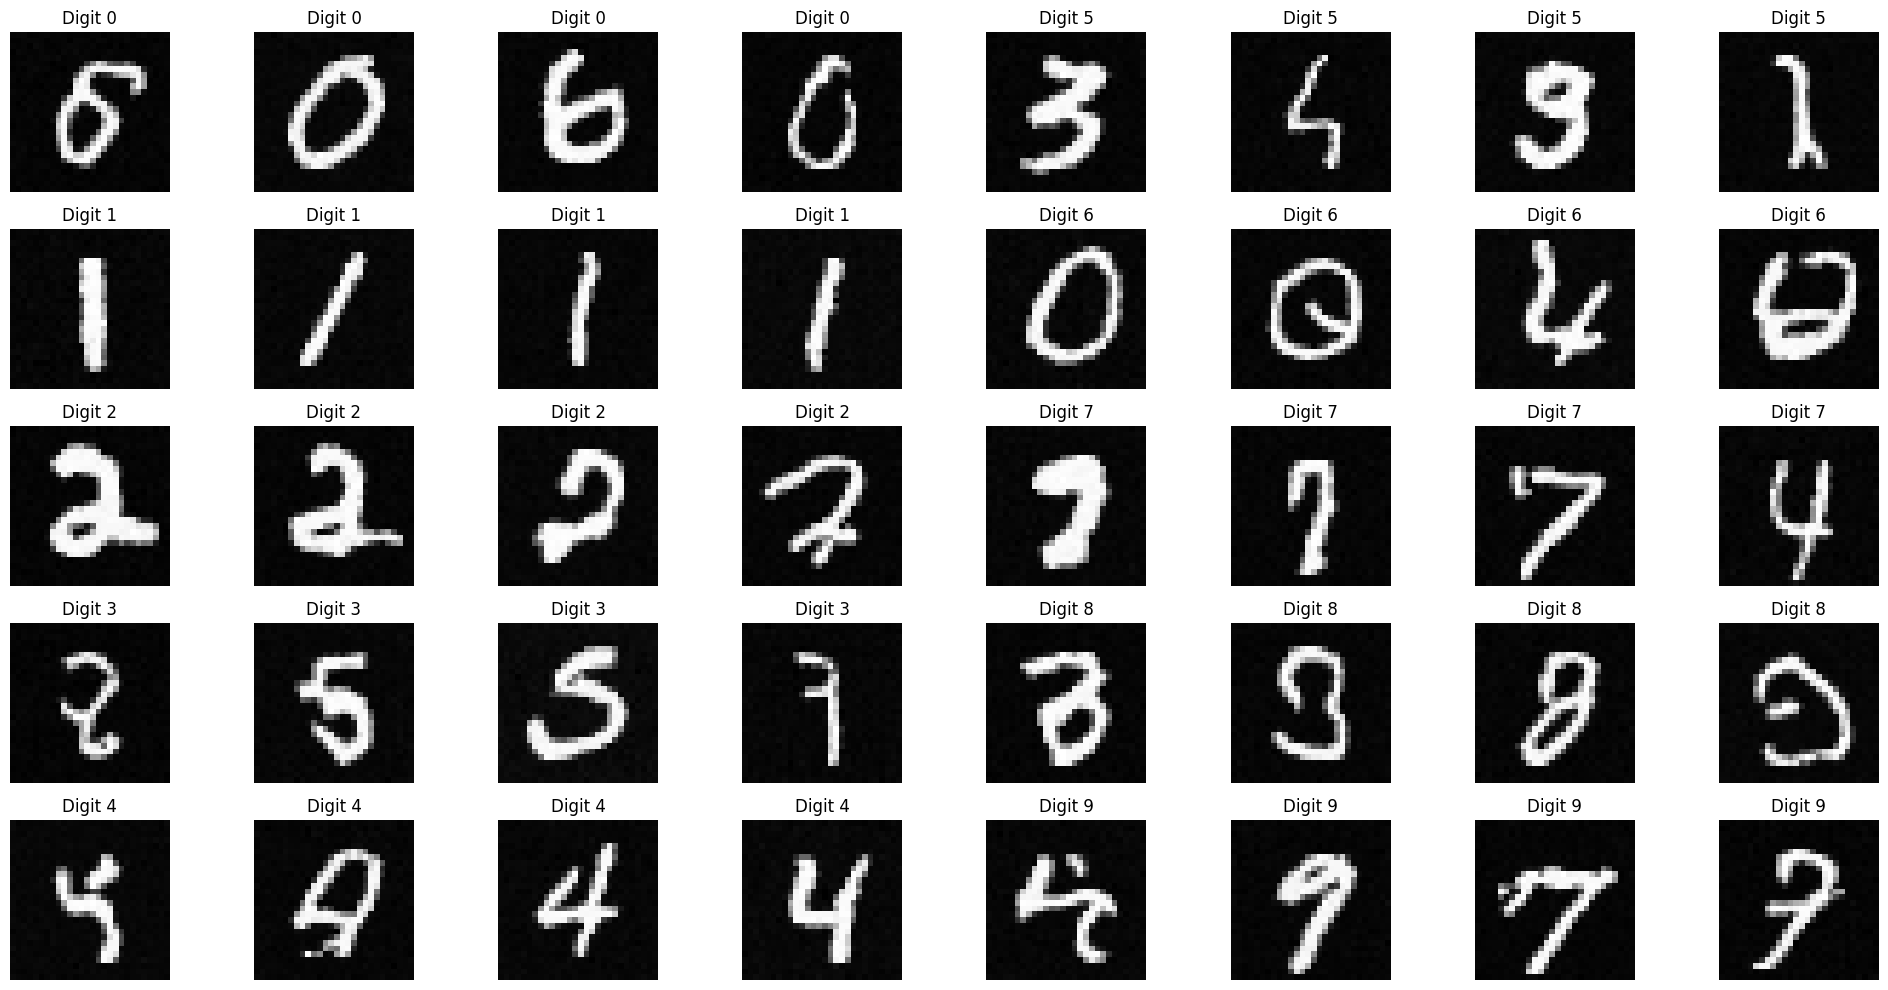


STUDENT ACTIVITY: Generating numbers with different noise seeds
Generating 10 versions of number 1...
  Denoising step 199/999 completed
  Denoising step 399/999 completed
  Denoising step 599/999 completed
  Denoising step 799/999 completed
  Denoising step 999/999 completed


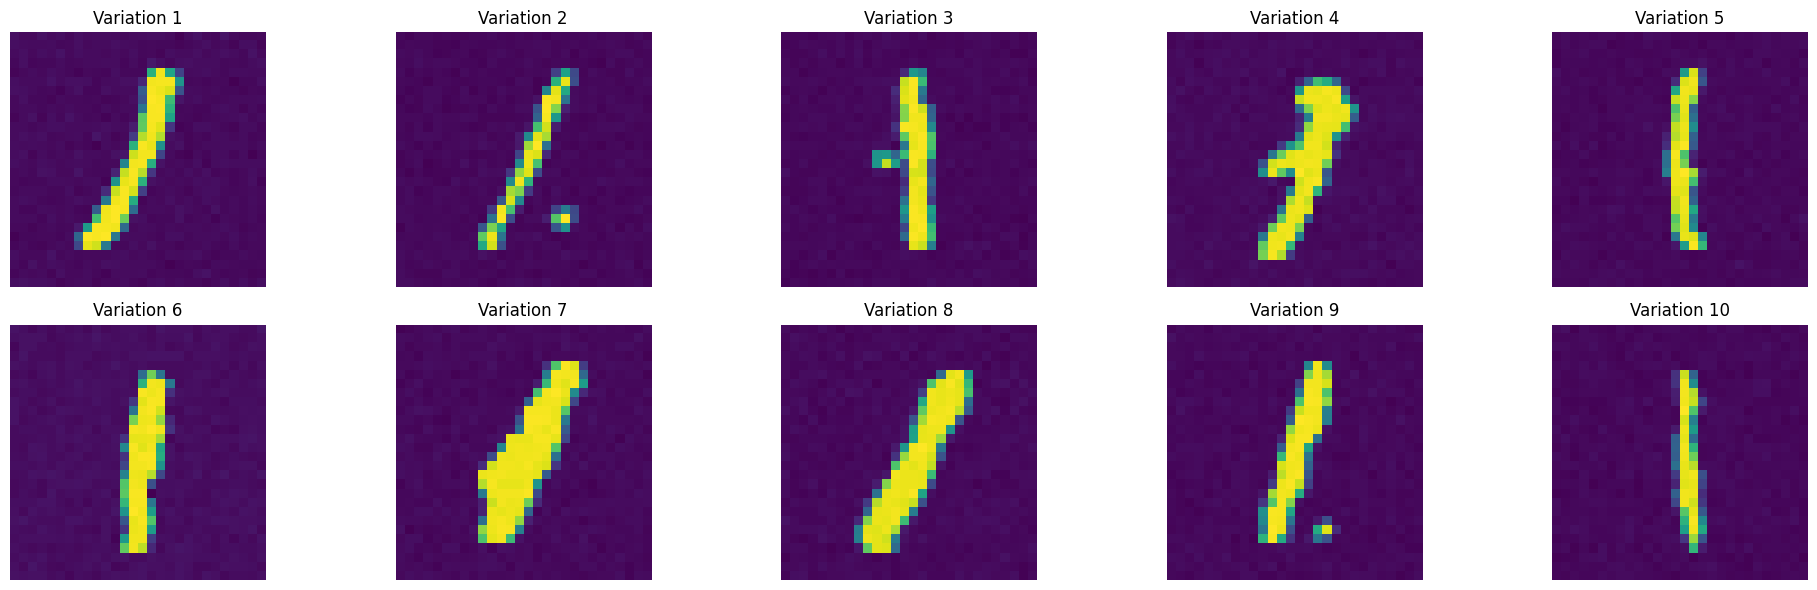

In [ ]:
def generate_number(model, number, n_samples=4):
    """
    Generate multiple versions of a specific number using the diffusion model.

    Args:
        model (nn.Module): The trained diffusion model
        number (int): The digit to generate (0-9)
        n_samples (int): Number of variations to generate

    Returns:
        torch.Tensor: Generated images of shape [n_samples, IMG_CH, IMG_SIZE, IMG_SIZE]
    """
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No need for gradients during generation
        # Start with random noise
        samples = torch.randn(n_samples, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)

        # Set up the number we want to generate
        c = torch.full((n_samples,), number).to(device)
        c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)
        # Correctly sized conditioning mask
        c_mask = torch.ones_like(c.unsqueeze(-1)).to(device)

        # Display progress information
        print(f"Generating {n_samples} versions of number {number}...")

        # Remove noise step by step
        for t in range(n_steps-1, -1, -1):
            t_batch = torch.full((n_samples,), t).to(device)
            samples = remove_noise(samples, t_batch, model, c_one_hot, c_mask)

            # Optional: Display occasional progress updates
            if t % (n_steps // 5) == 0:
                print(f"  Denoising step {n_steps-1-t}/{n_steps-1} completed")

        return samples

# Generate 4 versions of each number
plt.figure(figsize=(20, 10))
for i in range(10):
    # Generate samples for current digit
    samples = generate_number(model, i, n_samples=4)

    # Display each sample
    for j in range(4):
        # Use 2 rows, 10 digits per row, 4 samples per digit
        # i//5 determines the row (0 or 1)
        # i%5 determines the position in the row (0-4)
        # j is the sample index within each digit (0-3)
        plt.subplot(5, 8, (i%5)*8 + (i//5)*4 + j + 1)

        # Display the image correctly based on channel configuration
        if IMG_CH == 1:  # Grayscale
            plt.imshow(samples[j][0].cpu(), cmap='gray')
        else:  # Color image
            img = samples[j].permute(1, 2, 0).cpu()
            # Rescale from [-1, 1] to [0, 1] if needed
            if img.min() < 0:
                img = (img + 1) / 2
            plt.imshow(img)

        plt.title(f'Digit {i}')
        plt.axis('off')

plt.tight_layout()
plt.show()

# STUDENT ACTIVITY: Try generating the same digit with different noise seeds
# This shows the variety of styles the model can produce
print("\nSTUDENT ACTIVITY: Generating numbers with different noise seeds")

# Helper function to generate with seed
def generate_with_seed(number, seed_value=42, n_samples=10):
    torch.manual_seed(seed_value)
    return generate_number(model, number, n_samples)

# Pick a image and show many variations
# Hint select a image e.g. dog  # Change this to any other in the dataset of subset you chose
# Hint 2 use variations = generate_with_seed
# Hint 3 use plt.figure and plt.imshow to display the variations

# Enter your code here:
variations = generate_with_seed(1, seed_value=42, n_samples=10)
plt.figure(figsize=(20,6))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(variations[i].permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.title(f'Variation {i+1}')

plt.tight_layout()
plt.show()


## Step 7: Watching the Generation Process

Let's see how our model turns random noise into clear images, step by step. This helps us understand how the diffusion process works!


Generating number 0:


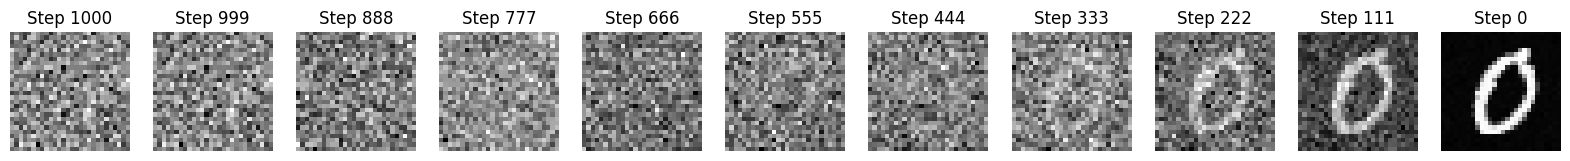


Generating number 3:


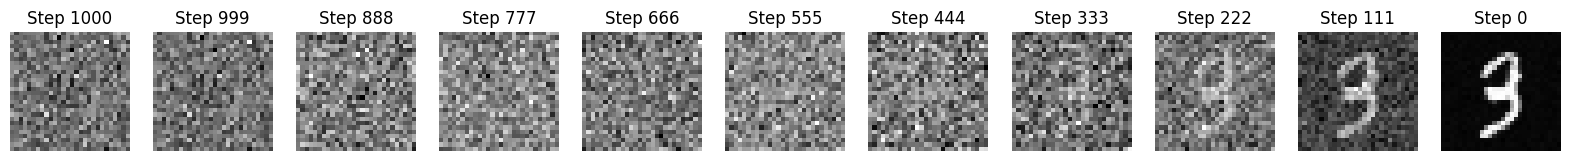


Generating number 7:


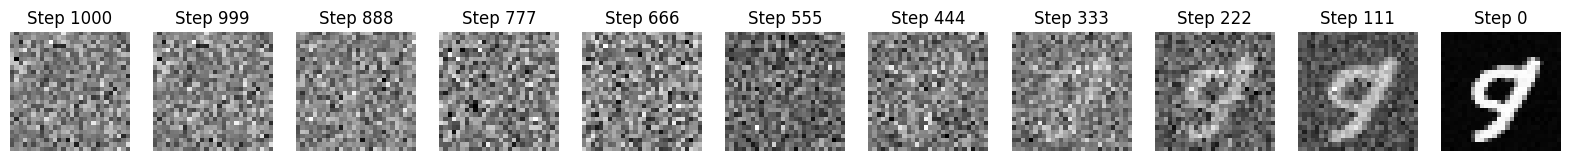

In [ ]:
def visualize_generation_steps(model, number, n_preview_steps=10):
    """
    Show how an image evolves from noise to a clear number
    """
    model.eval()
    with torch.no_grad():
        # Start with random noise
        x = torch.randn(1, IMG_CH, IMG_SIZE, IMG_SIZE).to(device)

        # Set up which number to generate
        c = torch.tensor([number]).to(device)
        c_one_hot = F.one_hot(c, N_CLASSES).float().to(device)
        c_mask = torch.ones_like(c_one_hot).to(device)

        # Calculate which steps to show
        steps_to_show = torch.linspace(n_steps-1, 0, n_preview_steps).long()

        # Store images for visualization
        images = []
        images.append(x[0].cpu())

        # Remove noise step by step
        for t in range(n_steps-1, -1, -1):
            t_batch = torch.full((1,), t).to(device)
            x = remove_noise(x, t_batch, model, c_one_hot, c_mask)

            if t in steps_to_show:
                images.append(x[0].cpu())

        # Show the progression
        plt.figure(figsize=(20, 3))
        for i, img in enumerate(images):
            plt.subplot(1, len(images), i+1)
            if IMG_CH == 1:
                plt.imshow(img[0], cmap='gray')
            else:
                img = img.permute(1, 2, 0)
                if img.min() < 0:
                    img = (img + 1) / 2
                plt.imshow(img)
            step = n_steps if i == 0 else steps_to_show[i-1]
            plt.title(f'Step {step}')
            plt.axis('off')
        plt.show()

# Show generation process for a few numbers
for number in [0, 3, 7]:
    print(f"\nGenerating number {number}:")
    visualize_generation_steps(model, number)

## Step 8: Adding CLIP Evaluation

[CLIP](https://openai.com/research/clip) is a powerful AI model that can understand both images and text. We'll use it to:
1. Evaluate how realistic our generated images are
2. Score how well they match their intended numbers
3. Help guide the generation process towards better quality

In [ ]:
## Step 8: Adding CLIP Evaluation

# CLIP (Contrastive Language-Image Pre-training) is a powerful model by OpenAI that connects text and images.
# We'll use it to evaluate how recognizable our generated digits are by measuring how strongly
# the CLIP model associates our generated images with text descriptions like "an image of the digit 7".

# First, we need to install CLIP and its dependencies
print("Setting up CLIP (Contrastive Language-Image Pre-training) model...")

# Track installation status
clip_available = False

try:
    # Install dependencies first - these help CLIP process text and images
    print("Installing CLIP dependencies...")
    !pip install -q ftfy regex tqdm

    # Install CLIP from GitHub
    print("Installing CLIP from GitHub repository...")
    !pip install -q git+https://github.com/openai/CLIP.git

    # Import and verify CLIP is working
    print("Importing CLIP...")
    import clip

    # Test that CLIP is functioning
    models = clip.available_models()
    print(f"✓ CLIP installation successful! Available models: {models}")
    clip_available = True

except ImportError:
    print("❌ Error importing CLIP. Installation might have failed.")
    print("Try manually running: !pip install git+https://github.com/openai/CLIP.git")
    print("If you're in a Colab notebook, try restarting the runtime after installation.")

except Exception as e:
    print(f"❌ Error during CLIP setup: {e}")
    print("Some CLIP functionality may not work correctly.")

# Provide guidance based on installation result
if clip_available:
    print("\nCLIP is now available for evaluating your generated images!")
else:
    print("\nWARNING: CLIP installation failed. We'll skip the CLIP evaluation parts.")

# Import necessary libraries
import functools
import torch.nn.functional as F


Setting up CLIP (Contrastive Language-Image Pre-training) model...
Installing CLIP dependencies...
Installing CLIP from GitHub repository...
  Preparing metadata (setup.py) ... done
Importing CLIP...
✓ CLIP installation successful! Available models: ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']

CLIP is now available for evaluating your generated images!


 Below we are createing  a helper function to manage GPU memory when using CLIP. CLIP can be memory-intensive, so this will help prevent out-of-memory errors:

In [ ]:
# Memory management decorator to prevent GPU OOM errors
def manage_gpu_memory(func):
    """
    Decorator that ensures proper GPU memory management.

    This wraps functions that might use large amounts of GPU memory,
    making sure memory is properly freed after function execution.
    """
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        if torch.cuda.is_available():
            # Clear cache before running function
            torch.cuda.empty_cache()
            try:
                return func(*args, **kwargs)
            finally:
                # Clear cache after running function regardless of success/failure
                torch.cuda.empty_cache()
        return func(*args, **kwargs)
    return wrapper

✓ Successfully loaded CLIP model: VisionTransformer

Generating and evaluating number 0...
Generating 4 versions of number 0...
  Denoising step 199/999 completed
  Denoising step 399/999 completed
  Denoising step 599/999 completed
  Denoising step 799/999 completed
  Denoising step 999/999 completed


/tmp/ipython-input-24-3974156644.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


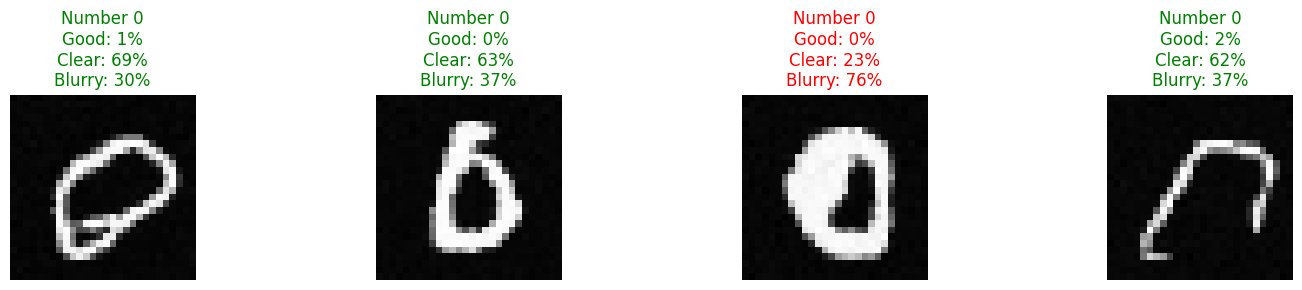


Generating and evaluating number 1...
Generating 4 versions of number 1...
  Denoising step 199/999 completed
  Denoising step 399/999 completed
  Denoising step 599/999 completed
  Denoising step 799/999 completed
  Denoising step 999/999 completed


/tmp/ipython-input-24-3974156644.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


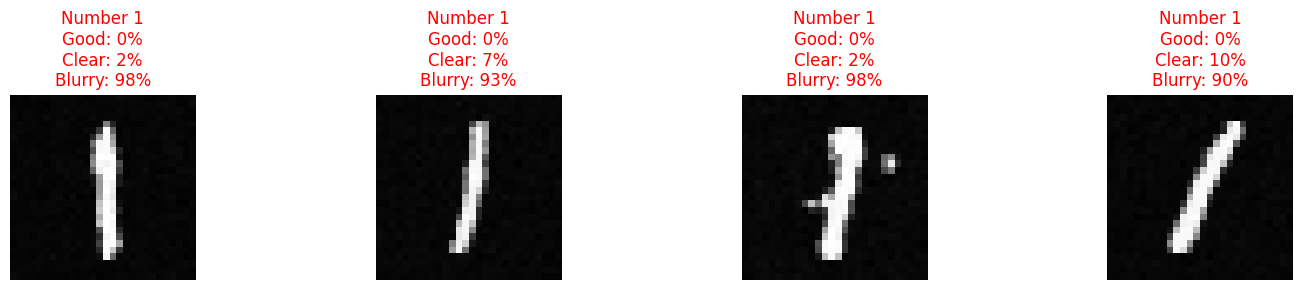


Generating and evaluating number 2...
Generating 4 versions of number 2...
  Denoising step 199/999 completed
  Denoising step 399/999 completed
  Denoising step 599/999 completed
  Denoising step 799/999 completed
  Denoising step 999/999 completed


/tmp/ipython-input-24-3974156644.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


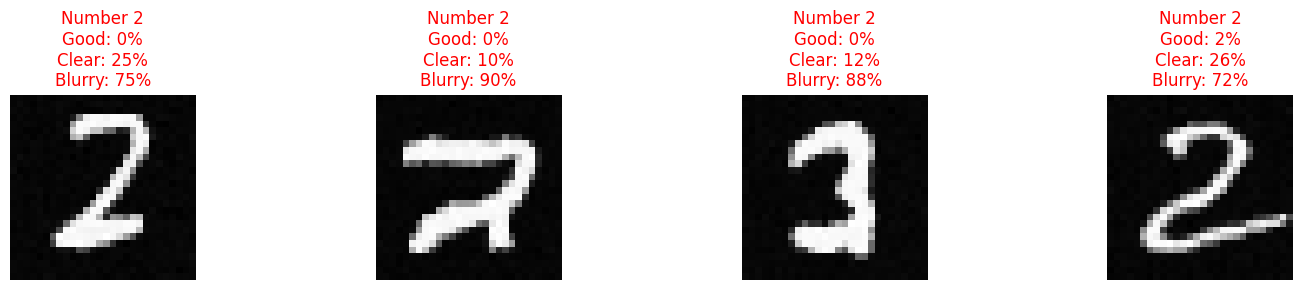


Generating and evaluating number 3...
Generating 4 versions of number 3...
  Denoising step 199/999 completed
  Denoising step 399/999 completed
  Denoising step 599/999 completed
  Denoising step 799/999 completed
  Denoising step 999/999 completed


/tmp/ipython-input-24-3974156644.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


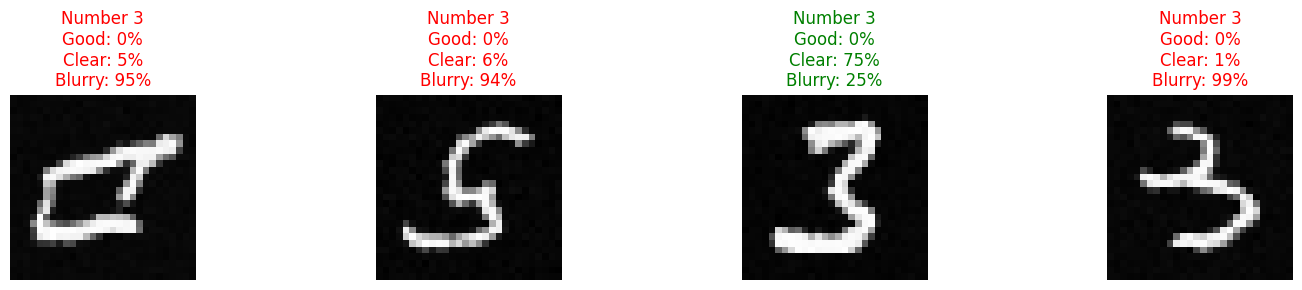


Generating and evaluating number 4...
Generating 4 versions of number 4...
  Denoising step 199/999 completed
  Denoising step 399/999 completed
  Denoising step 599/999 completed
  Denoising step 799/999 completed
  Denoising step 999/999 completed


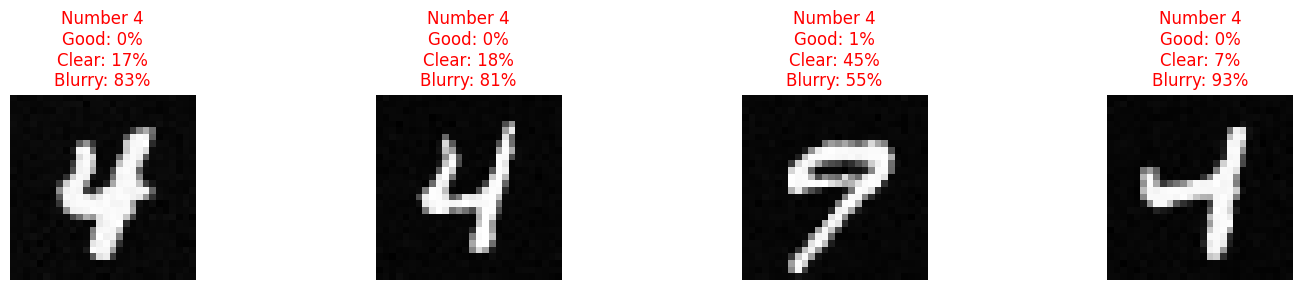


Generating and evaluating number 5...
Generating 4 versions of number 5...
  Denoising step 199/999 completed
  Denoising step 399/999 completed
  Denoising step 599/999 completed
  Denoising step 799/999 completed
  Denoising step 999/999 completed


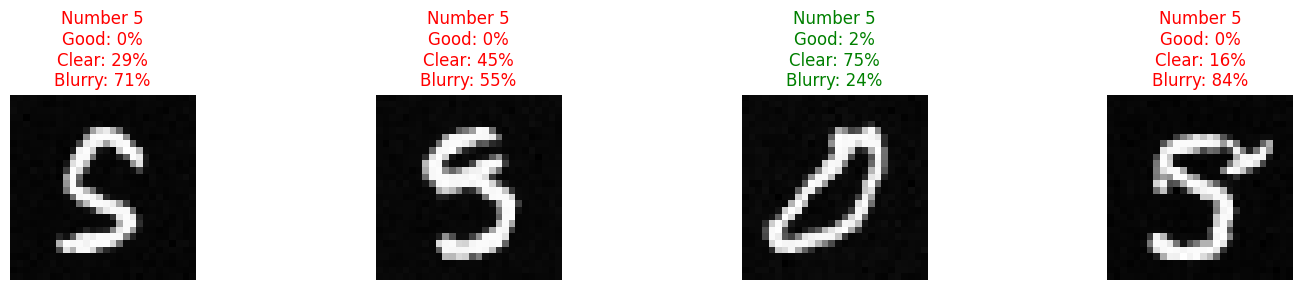


Generating and evaluating number 6...
Generating 4 versions of number 6...
  Denoising step 199/999 completed
  Denoising step 399/999 completed
  Denoising step 599/999 completed
  Denoising step 799/999 completed
  Denoising step 999/999 completed


/tmp/ipython-input-24-3974156644.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


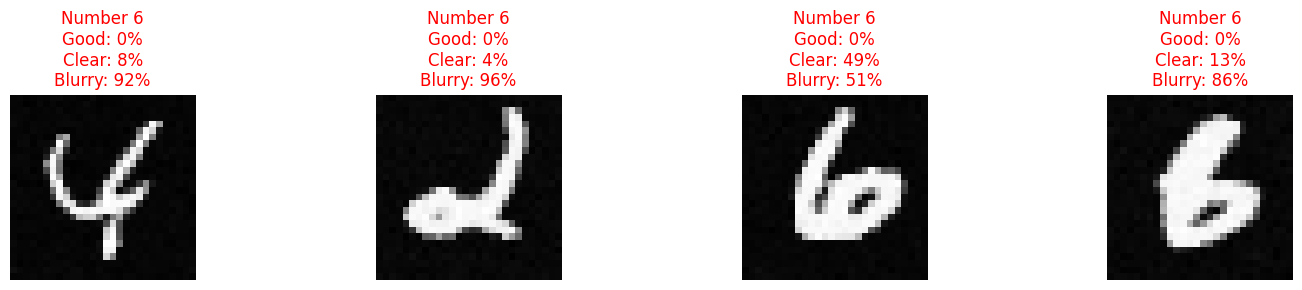


Generating and evaluating number 7...
Generating 4 versions of number 7...
  Denoising step 199/999 completed
  Denoising step 399/999 completed
  Denoising step 599/999 completed
  Denoising step 799/999 completed
  Denoising step 999/999 completed


/tmp/ipython-input-24-3974156644.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


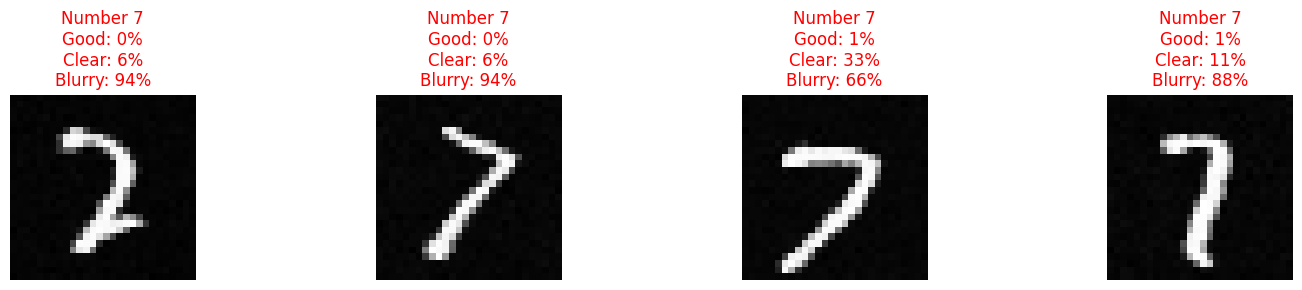


Generating and evaluating number 8...
Generating 4 versions of number 8...
  Denoising step 199/999 completed
  Denoising step 399/999 completed
  Denoising step 599/999 completed
  Denoising step 799/999 completed
  Denoising step 999/999 completed


/tmp/ipython-input-24-3974156644.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


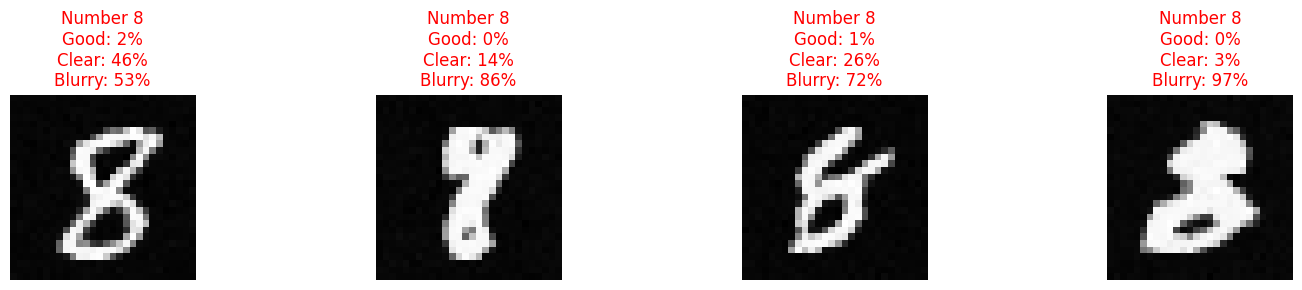


Generating and evaluating number 9...
Generating 4 versions of number 9...
  Denoising step 199/999 completed
  Denoising step 399/999 completed
  Denoising step 599/999 completed
  Denoising step 799/999 completed
  Denoising step 999/999 completed


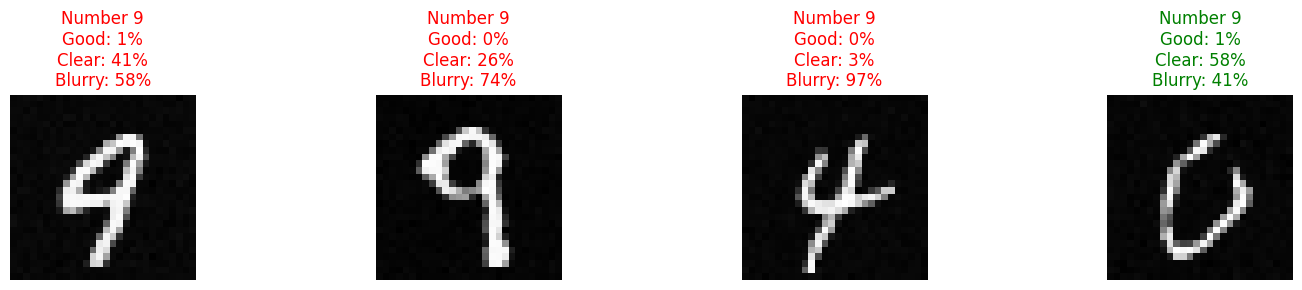


STUDENT ACTIVITY:
Try the code below to evaluate a larger sample of a specific digit

# Example: Generate and evaluate 10 examples of the digit 6
# digit = 6
# samples = generate_number(model, digit, n_samples=10)
# similarities = evaluate_with_clip(samples, digit)
#
# # Calculate what percentage of samples CLIP considers "good quality"
# # (either "good handwritten" or "clear" score exceeds "blurry" score)
# good_or_clear = (similarities[:,0] + similarities[:,1] > similarities[:,2]).float().mean()
# print(f"CLIP recognized {good_or_clear.item()*100:.1f}% of the digits as good examples of {digit}")
#
# # Display a grid of samples with their quality scores
# plt.figure(figsize=(15, 8))
# for i in range(len(samples)):
#     plt.subplot(2, 5, i+1)
#     plt.imshow(samples[i][0].cpu(), cmap='gray')
#     quality = "Good" if similarities[i,0] + similarities[i,1] > similarities[i,2] else "Poor"
#     plt.title(f"Sample {i+1}: {quality}", color='green' if quality == "Good" else 'red')
#     

In [ ]:
#==============================================================================
# Step 8: CLIP Model Loading and Evaluation Setup
#==============================================================================
# CLIP (Contrastive Language-Image Pre-training) is a neural network that connects
# vision and language. It was trained on 400 million image-text pairs to understand
# the relationship between images and their descriptions.
# We use it here as an "evaluation judge" to assess our generated images.

# Load CLIP model with error handling
try:
    # Load the ViT-B/32 CLIP model (Vision Transformer-based)
    clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
    print(f"✓ Successfully loaded CLIP model: {clip_model.visual.__class__.__name__}")
except Exception as e:
    print(f"❌ Failed to load CLIP model: {e}")
    clip_available = False
    # Instead of raising an error, we'll continue with degraded functionality
    print("CLIP evaluation will be skipped. Generated images will still be displayed but without quality scores.")

def evaluate_with_clip(images, target_number, max_batch_size=16):
    """
    Use CLIP to evaluate generated images by measuring how well they match textual descriptions.

    This function acts like an "automatic critic" for our generated digits by measuring:
    1. How well they match the description of a handwritten digit
    2. How clear and well-formed they appear to be
    3. Whether they appear blurry or poorly formed

    The evaluation process works by:
    - Converting our images to a format CLIP understands
    - Creating text prompts that describe the qualities we want to measure
    - Computing similarity scores between images and these text descriptions
    - Returning normalized scores (probabilities) for each quality

    Args:
        images (torch.Tensor): Batch of generated images [batch_size, channels, height, width]
        target_number (int): The specific digit (0-9) the images should represent
        max_batch_size (int): Maximum images to process at once (prevents GPU out-of-memory errors)

    Returns:
        torch.Tensor: Similarity scores tensor of shape [batch_size, 3] with scores for:
                     [good handwritten digit, clear digit, blurry digit]
                     Each row sums to 1.0 (as probabilities)
    """
    # If CLIP isn't available, return placeholder scores
    if not clip_available:
        print("⚠️ CLIP not available. Returning default scores.")
        # Equal probabilities (0.33 for each category)
        return torch.ones(len(images), 3).to(device) / 3

    try:
        # For large batches, we process in chunks to avoid memory issues
        # This is crucial when working with big images or many samples
        if len(images) > max_batch_size:
            all_similarities = []

            # Process images in manageable chunks
            for i in range(0, len(images), max_batch_size):
                print(f"Processing CLIP batch {i//max_batch_size + 1}/{(len(images)-1)//max_batch_size + 1}")
                batch = images[i:i+max_batch_size]

                # Use context managers for efficiency and memory management:
                # - torch.no_grad(): disables gradient tracking (not needed for evaluation)
                # - torch.cuda.amp.autocast(): uses mixed precision to reduce memory usage
                with torch.no_grad(), torch.cuda.amp.autocast():
                    batch_similarities = _process_clip_batch(batch, target_number)
                    all_similarities.append(batch_similarities)

                # Explicitly free GPU memory between batches
                # This helps prevent cumulative memory buildup that could cause crashes
                torch.cuda.empty_cache()

            # Combine results from all batches into a single tensor
            return torch.cat(all_similarities, dim=0)
        else:
            # For small batches, process all at once
            with torch.no_grad(), torch.cuda.amp.autocast():
                return _process_clip_batch(images, target_number)

    except Exception as e:
        # If anything goes wrong, log the error but don't crash
        print(f"❌ Error in CLIP evaluation: {e}")
        print(f"Traceback: {traceback.format_exc()}")
        # Return default scores so the rest of the notebook can continue
        return torch.ones(len(images), 3).to(device) / 3

def _process_clip_batch(images, target_number):
    """
    Core CLIP processing function that computes similarity between images and text descriptions.

    This function handles the technical details of:
    1. Preparing relevant text prompts for evaluation
    2. Preprocessing images to CLIP's required format
    3. Extracting feature embeddings from both images and text
    4. Computing similarity scores between these embeddings

    The function includes advanced error handling for GPU memory issues,
    automatically reducing batch size if out-of-memory errors occur.

    Args:
        images (torch.Tensor): Batch of images to evaluate
        target_number (int): The digit these images should represent

    Returns:
        torch.Tensor: Normalized similarity scores between images and text descriptions
    """
    try:
        # Create text descriptions (prompts) to evaluate our generated digits
        # We check three distinct qualities:
        # 1. If it looks like a handwritten example of the target digit
        # 2. If it appears clear and well-formed
        # 3. If it appears blurry or poorly formed (negative case)
        text_inputs = torch.cat([
            clip.tokenize(f"A handwritten number {target_number}"),
            clip.tokenize(f"A clear, well-written digit {target_number}"),
            clip.tokenize(f"A blurry or unclear number")
        ]).to(device)

        # Process images for CLIP, which requires specific formatting:

        # 1. Handle different channel configurations (dataset-dependent)
        if IMG_CH == 1:
            # CLIP expects RGB images, so we repeat the grayscale channel 3 times
            # For example, MNIST/Fashion-MNIST are grayscale (1-channel)
            images_rgb = images.repeat(1, 3, 1, 1)
        else:
            # For RGB datasets like CIFAR-10/CelebA, we can use as-is
            images_rgb = images

        # 2. Normalize pixel values to [0,1] range if needed
        # Different datasets may have different normalization ranges
        if images_rgb.min() < 0:  # If normalized to [-1,1] range
            images_rgb = (images_rgb + 1) / 2  # Convert to [0,1] range

        # 3. Resize images to CLIP's expected input size (224x224 pixels)
        # CLIP was trained on this specific resolution
        resized_images = F.interpolate(images_rgb, size=(224, 224),
                                      mode='bilinear', align_corners=False)

        # Extract feature embeddings from both images and text prompts
        # These are high-dimensional vectors representing the content
        image_features = clip_model.encode_image(resized_images)
        text_features = clip_model.encode_text(text_inputs)

        # Normalize feature vectors to unit length (for cosine similarity)
        # This ensures we're measuring direction, not magnitude
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # Calculate similarity scores between image and text features
        # The matrix multiplication computes all pairwise dot products at once
        # Multiplying by 100 scales to percentage-like values before applying softmax
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

        return similarity

    except RuntimeError as e:
        # Special handling for CUDA out-of-memory errors
        if "out of memory" in str(e):
            # Free GPU memory immediately
            torch.cuda.empty_cache()

            # If we're already at batch size 1, we can't reduce further
            if len(images) <= 1:
                print("❌ Out of memory even with batch size 1. Cannot process.")
                return torch.ones(len(images), 3).to(device) / 3

            # Adaptive batch size reduction - recursively try with smaller batches
            # This is an advanced technique to handle limited GPU memory gracefully
            half_size = len(images) // 2
            print(f"⚠️ Out of memory. Reducing batch size to {half_size}.")

            # Process each half separately and combine results
            # This recursive approach will keep splitting until processing succeeds
            first_half = _process_clip_batch(images[:half_size], target_number)
            second_half = _process_clip_batch(images[half_size:], target_number)

            # Combine results from both halves
            return torch.cat([first_half, second_half], dim=0)

        # For other errors, propagate upward
        raise e

#==============================================================================
# CLIP Evaluation - Generate and Analyze Sample Digits
#==============================================================================
# This section demonstrates how to use CLIP to evaluate generated digits
# We'll generate examples of all ten digits and visualize the quality scores

try:
    for number in range(10):
        print(f"\nGenerating and evaluating number {number}...")

        # Generate 4 different variations of the current digit
        samples = generate_number(model, number, n_samples=4)

        # Evaluate quality with CLIP (without tracking gradients for efficiency)
        with torch.no_grad():
            similarities = evaluate_with_clip(samples, number)

        # Create a figure to display results
        plt.figure(figsize=(15, 3))

        # Show each sample with its CLIP quality scores
        for i in range(4):
            plt.subplot(1, 4, i+1)

            # Display the image with appropriate formatting based on dataset type
            if IMG_CH == 1:  # Grayscale images (MNIST, Fashion-MNIST)
                plt.imshow(samples[i][0].cpu(), cmap='gray')
            else:  # Color images (CIFAR-10, CelebA)
                img = samples[i].permute(1, 2, 0).cpu()  # Change format for matplotlib
                if img.min() < 0:  # Handle [-1,1] normalization
                    img = (img + 1) / 2  # Convert to [0,1] range
                plt.imshow(img)

            # Extract individual quality scores for display
            # These represent how confidently CLIP associates the image with each description
            good_score = similarities[i][0].item() * 100  # Handwritten quality
            clear_score = similarities[i][1].item() * 100  # Clarity quality
            blur_score = similarities[i][2].item() * 100   # Blurriness assessment

            # Color-code the title based on highest score category:
            # - Green: if either "good handwritten" or "clear" score is highest
            # - Red: if "blurry" score is highest (poor quality)
            max_score_idx = torch.argmax(similarities[i]).item()
            title_color = 'green' if max_score_idx < 2 else 'red'

            # Show scores in the plot title
            plt.title(f'Number {number}\nGood: {good_score:.0f}%\nClear: {clear_score:.0f}%\nBlurry: {blur_score:.0f}%',
                      color=title_color)
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        plt.close()  # Properly close figure to prevent memory leaks

        # Clean up GPU memory after processing each number
        # This is especially important for resource-constrained environments
        torch.cuda.empty_cache()

except Exception as e:
    # Comprehensive error handling to help students debug issues
    print(f"❌ Error in generation and evaluation loop: {e}")
    print("Detailed error information:")
    import traceback
    traceback.print_exc()

    # Clean up resources even if we encounter an error
    if torch.cuda.is_available():
        print("Clearing GPU cache...")
        torch.cuda.empty_cache()

#==============================================================================
# STUDENT ACTIVITY: Exploring CLIP Evaluation
#==============================================================================
# This section provides code templates for students to experiment with
# evaluating larger batches of generated digits using CLIP.

print("\nSTUDENT ACTIVITY:")
print("Try the code below to evaluate a larger sample of a specific digit")
print("""
# Example: Generate and evaluate 10 examples of the digit 6
# digit = 6
# samples = generate_number(model, digit, n_samples=10)
# similarities = evaluate_with_clip(samples, digit)
#
# # Calculate what percentage of samples CLIP considers "good quality"
# # (either "good handwritten" or "clear" score exceeds "blurry" score)
# good_or_clear = (similarities[:,0] + similarities[:,1] > similarities[:,2]).float().mean()
# print(f"CLIP recognized {good_or_clear.item()*100:.1f}% of the digits as good examples of {digit}")
#
# # Display a grid of samples with their quality scores
# plt.figure(figsize=(15, 8))
# for i in range(len(samples)):
#     plt.subplot(2, 5, i+1)
#     plt.imshow(samples[i][0].cpu(), cmap='gray')
#     quality = "Good" if similarities[i,0] + similarities[i,1] > similarities[i,2] else "Poor"
#     plt.title(f"Sample {i+1}: {quality}", color='green' if quality == "Good" else 'red')
#     plt.axis('off')
# plt.tight_layout()
# plt.show()
""")

## Assessment Questions

Now that you've completed the exercise, answer these questions include explanations, observations, and your analysis
Support your answers with specific examples from your experiments:

### 1. Understanding Diffusion
- Explain what happens during the forward diffusion process, using your own words and referencing the visualization examples from your notebook.

- Why do we add noise gradually instead of all at once? How does this affect the learning process?

- Look at the step-by-step visualization - at what point (approximately what percentage through the denoising process) can you first recognize the image? Does this vary by image?

### 2. Model Architecture
- Why is the U-Net architecture particularly well-suited for diffusion models? What advantages does it provide over simpler architectures?

- What are skip connections and why are they important? Explain them in relations to our model

- Describe in detail how our model is conditioned to generate specific images. How does the class conditioning mechanism work?

### 3. Training Analysis (20 points)
- What does the loss value tell of your model tell us?

- How did the quality of  your  generated images change change throughout the training process?

- Why do we need the time embedding in diffusion models? How does it help the model understand where it is in the denoising process?

### 4. CLIP Evaluation (20 points)
- What do the CLIP scores tell you about your generated images? Which  images got  the highest and lowest quality scores?

- Develop a hypothesis explaining why certain images might be easier or harder for the model to generate convincingly.

- How could CLIP scores be used to improve the diffusion model's generation process? Propose a specific technique.

### 5. Practical Applications (20 points)
- How could this type of model be useful in the real world?

- What are the limitations of our current model?

- If you were to continue developing this project, what three specific improvements would you make and why?

### Bonus Challenge (Extra 20 points)
Try one or more of these experiments:
1. If you were to continue developing this project, what three specific improvements would you make and why?

2. Modify the U-Net architecture (e.g., add more layers, increase channel dimensions) and train the model. How do these changes affect training time and generation quality?

3. CLIP-Guided Selection: Generate 10 samples of each image, use CLIP to evaluate them, and select the top 3 highest-quality examples of each. Analyze patterns in what CLIP considers "high quality."

4. tyle Conditioning: Modify the conditioning mechanism to generate multiple styles of the same digit (e.g., slanted, thick, thin). Document your approach and results.


Deliverables:
1. A PDF copy of your notebook with
    - Complete code, outputs, and generated images
    - Include all experiment results, training plots, and generated samples
    - CLIP evaluation scores of ythe images you generated
    - Answers and any interesting findings from the bonus challenges


STARTING TRAINING

Epoch 1/60
--------------------
  Step 0/750, Loss: 0.0208
  Step 100/750, Loss: 0.0173
  Step 200/750, Loss: 0.0253
  Step 300/750, Loss: 0.0190
  Step 400/750, Loss: 0.0222
  Step 500/750, Loss: 0.0207
  Generating samples...


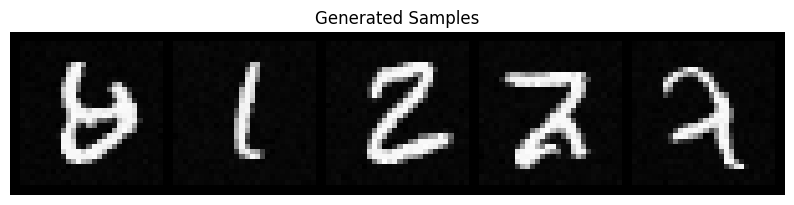

  Step 600/750, Loss: 0.0218
  Step 700/750, Loss: 0.0245

Training - Epoch 1 average loss: 0.0221
Running validation...
Validation - Epoch 1 average loss: 0.0219
Learning rate: 0.000040

Generating samples for visual progress check...


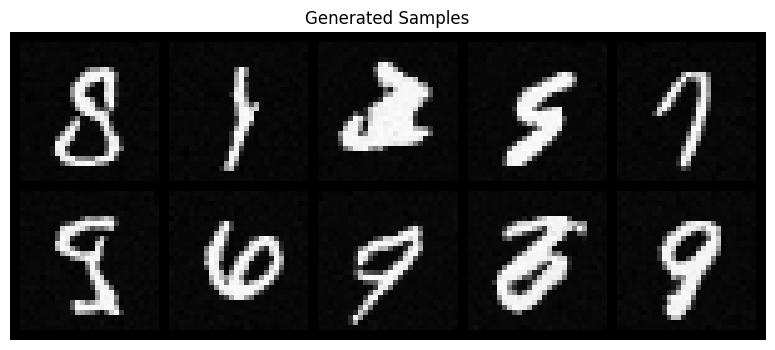

Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0219)


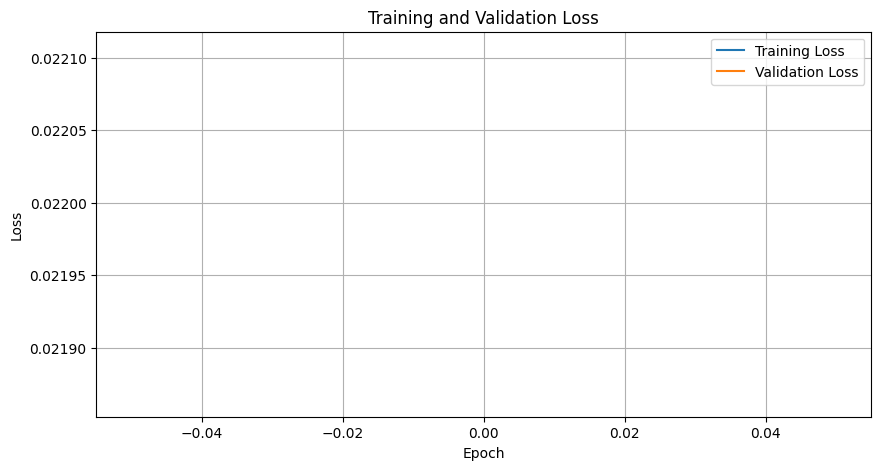


Epoch 2/60
--------------------
  Step 0/750, Loss: 0.0233
  Step 100/750, Loss: 0.0257
  Step 200/750, Loss: 0.0227
  Step 300/750, Loss: 0.0209
  Step 400/750, Loss: 0.0248
  Step 500/750, Loss: 0.0222
  Generating samples...


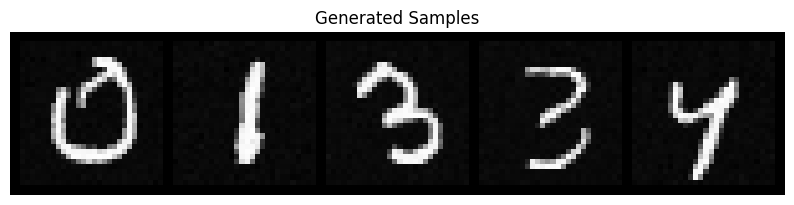

  Step 600/750, Loss: 0.0221
  Step 700/750, Loss: 0.0249

Training - Epoch 2 average loss: 0.0221
Running validation...
Validation - Epoch 2 average loss: 0.0226
Learning rate: 0.000040
No improvement for 1/10 epochs

Epoch 3/60
--------------------
  Step 0/750, Loss: 0.0218
  Step 100/750, Loss: 0.0205
  Step 200/750, Loss: 0.0264
  Step 300/750, Loss: 0.0366
  Step 400/750, Loss: 0.0227
  Step 500/750, Loss: 0.0194
  Generating samples...


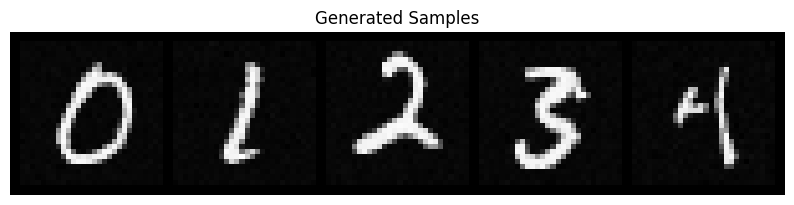

  Step 600/750, Loss: 0.0181
  Step 700/750, Loss: 0.0181

Training - Epoch 3 average loss: 0.0222
Running validation...
Validation - Epoch 3 average loss: 0.0226
Learning rate: 0.000040

Generating samples for visual progress check...


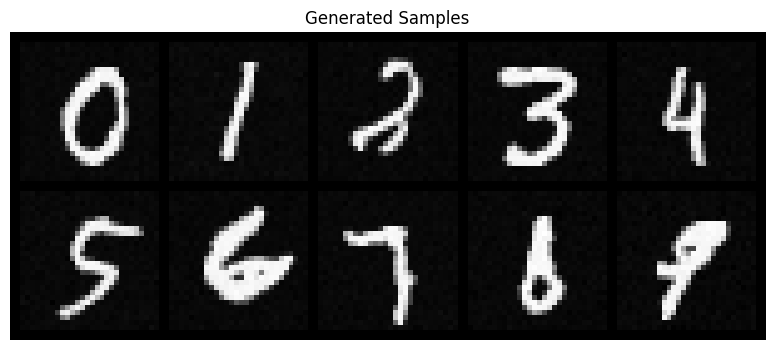

No improvement for 2/10 epochs

Epoch 4/60
--------------------
  Step 0/750, Loss: 0.0218
  Step 100/750, Loss: 0.0205
  Step 200/750, Loss: 0.0259
  Step 300/750, Loss: 0.0178
  Step 400/750, Loss: 0.0234
  Step 500/750, Loss: 0.0276
  Generating samples...


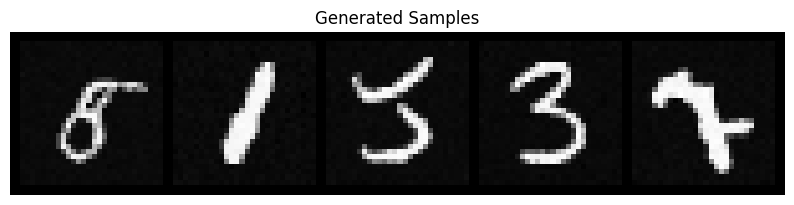

  Step 600/750, Loss: 0.0272
  Step 700/750, Loss: 0.0226

Training - Epoch 4 average loss: 0.0219
Running validation...
Validation - Epoch 4 average loss: 0.0220
Learning rate: 0.000040
No improvement for 3/10 epochs

Epoch 5/60
--------------------
  Step 0/750, Loss: 0.0176
  Step 100/750, Loss: 0.0265
  Step 200/750, Loss: 0.0188
  Step 300/750, Loss: 0.0190
  Step 400/750, Loss: 0.0267
  Step 500/750, Loss: 0.0214
  Generating samples...


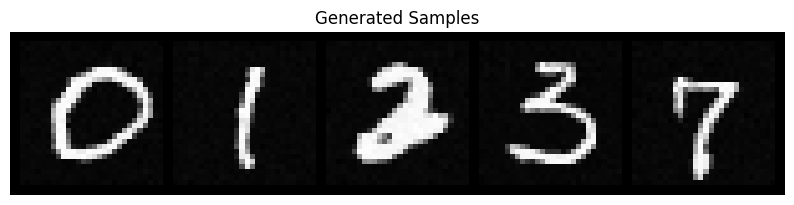

  Step 600/750, Loss: 0.0268
  Step 700/750, Loss: 0.0218

Training - Epoch 5 average loss: 0.0218
Running validation...
Validation - Epoch 5 average loss: 0.0220
Learning rate: 0.000040

Generating samples for visual progress check...


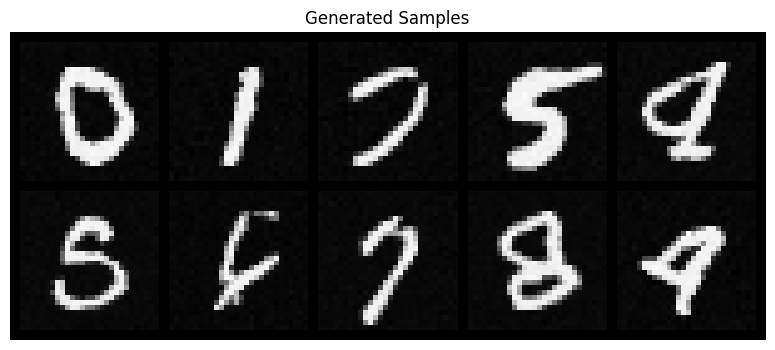

No improvement for 4/10 epochs

Epoch 6/60
--------------------
  Step 0/750, Loss: 0.0195
  Step 100/750, Loss: 0.0235
  Step 200/750, Loss: 0.0224
  Step 300/750, Loss: 0.0261
  Step 400/750, Loss: 0.0222
  Step 500/750, Loss: 0.0304
  Generating samples...


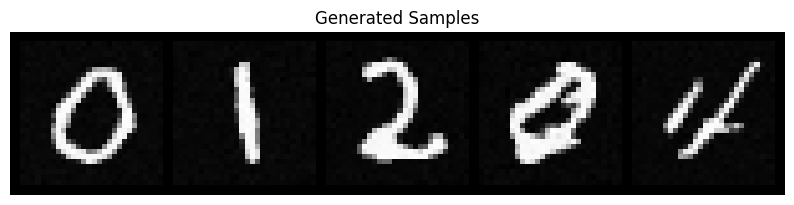

  Step 600/750, Loss: 0.0177
  Step 700/750, Loss: 0.0177

Training - Epoch 6 average loss: 0.0221
Running validation...
Validation - Epoch 6 average loss: 0.0225
Learning rate: 0.000040
No improvement for 5/10 epochs


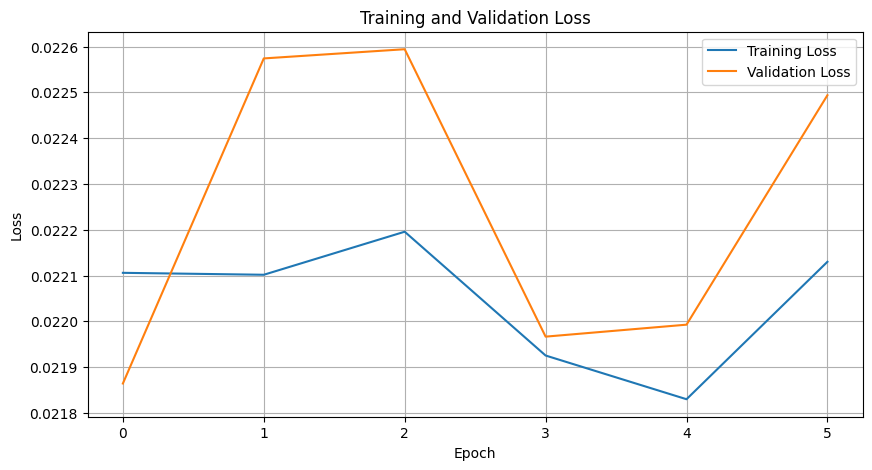


Epoch 7/60
--------------------
  Step 0/750, Loss: 0.0255
  Step 100/750, Loss: 0.0174
  Step 200/750, Loss: 0.0278
  Step 300/750, Loss: 0.0213
  Step 400/750, Loss: 0.0284
  Step 500/750, Loss: 0.0170
  Generating samples...


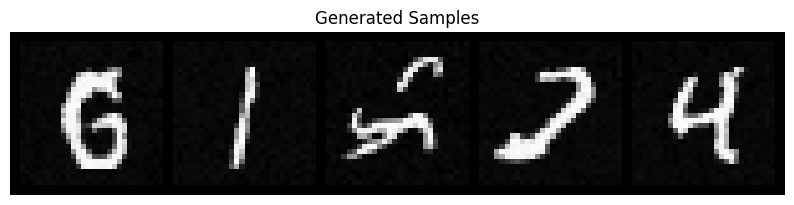

  Step 600/750, Loss: 0.0205
  Step 700/750, Loss: 0.0254

Training - Epoch 7 average loss: 0.0224
Running validation...
Validation - Epoch 7 average loss: 0.0224
Learning rate: 0.000008

Generating samples for visual progress check...


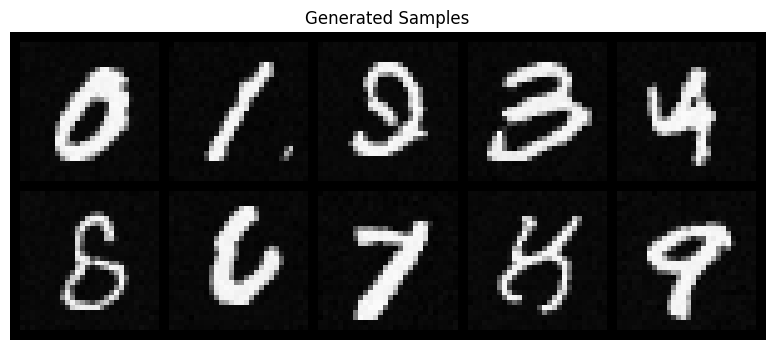

No improvement for 6/10 epochs

Epoch 8/60
--------------------
  Step 0/750, Loss: 0.0250
  Step 100/750, Loss: 0.0196
  Step 200/750, Loss: 0.0205
  Step 300/750, Loss: 0.0217
  Step 400/750, Loss: 0.0150
  Step 500/750, Loss: 0.0158
  Generating samples...


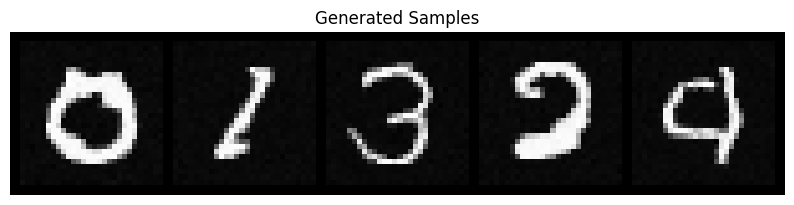

  Step 600/750, Loss: 0.0287
  Step 700/750, Loss: 0.0176

Training - Epoch 8 average loss: 0.0224
Running validation...
Validation - Epoch 8 average loss: 0.0220
Learning rate: 0.000008
No improvement for 7/10 epochs

Epoch 9/60
--------------------
  Step 0/750, Loss: 0.0270
  Step 100/750, Loss: 0.0240
  Step 200/750, Loss: 0.0188
  Step 300/750, Loss: 0.0172
  Step 400/750, Loss: 0.0318
  Step 500/750, Loss: 0.0213
  Generating samples...


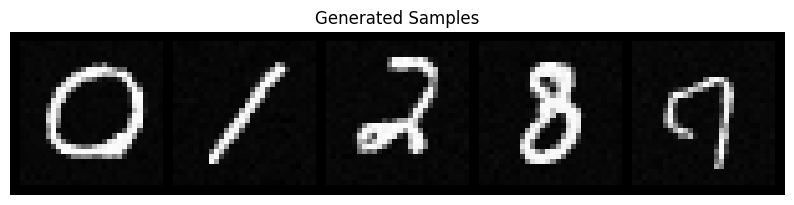

  Step 600/750, Loss: 0.0327
  Step 700/750, Loss: 0.0195

Training - Epoch 9 average loss: 0.0221
Running validation...
Validation - Epoch 9 average loss: 0.0221
Learning rate: 0.000008

Generating samples for visual progress check...


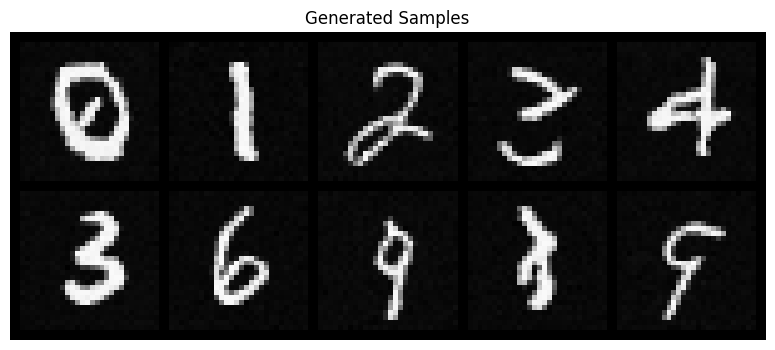

No improvement for 8/10 epochs

Epoch 10/60
--------------------
  Step 0/750, Loss: 0.0217
  Step 100/750, Loss: 0.0256
  Step 200/750, Loss: 0.0208
  Step 300/750, Loss: 0.0193
  Step 400/750, Loss: 0.0203
  Step 500/750, Loss: 0.0260
  Generating samples...


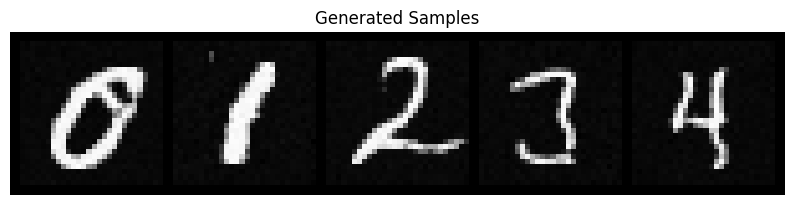

  Step 600/750, Loss: 0.0204
  Step 700/750, Loss: 0.0179

Training - Epoch 10 average loss: 0.0220
Running validation...
Validation - Epoch 10 average loss: 0.0218
Learning rate: 0.000008
Created backup at best_diffusion_model.pt.backup
Model successfully saved to best_diffusion_model.pt
✓ New best model saved! (Val Loss: 0.0218)

Epoch 11/60
--------------------
  Step 0/750, Loss: 0.0227
  Step 100/750, Loss: 0.0233
  Step 200/750, Loss: 0.0229
  Step 300/750, Loss: 0.0164
  Step 400/750, Loss: 0.0213
  Step 500/750, Loss: 0.0181
  Generating samples...


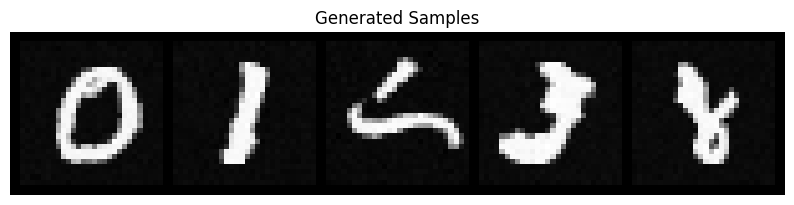

  Step 600/750, Loss: 0.0208
  Step 700/750, Loss: 0.0183

Training - Epoch 11 average loss: 0.0223
Running validation...
Validation - Epoch 11 average loss: 0.0230
Learning rate: 0.000008

Generating samples for visual progress check...


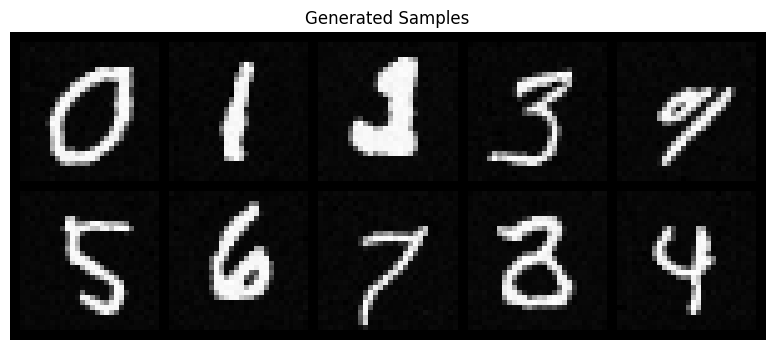

No improvement for 1/10 epochs


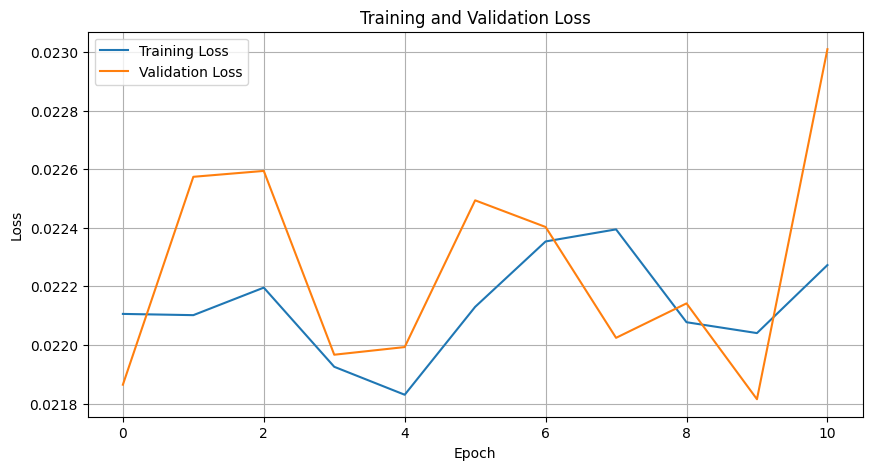


Epoch 12/60
--------------------
  Step 0/750, Loss: 0.0164
  Step 100/750, Loss: 0.0246
  Step 200/750, Loss: 0.0198
  Step 300/750, Loss: 0.0213
  Step 400/750, Loss: 0.0229
  Step 500/750, Loss: 0.0193
  Generating samples...


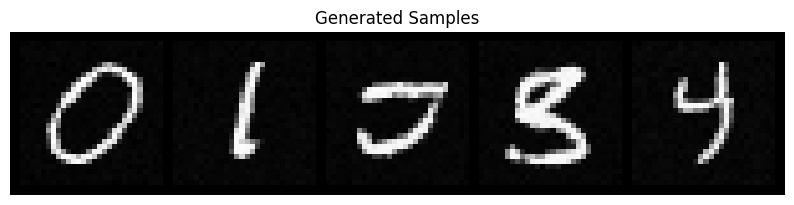

  Step 600/750, Loss: 0.0236
  Step 700/750, Loss: 0.0256

Training - Epoch 12 average loss: 0.0221
Running validation...
Validation - Epoch 12 average loss: 0.0224
Learning rate: 0.000008
No improvement for 2/10 epochs

Epoch 13/60
--------------------
  Step 0/750, Loss: 0.0225
  Step 100/750, Loss: 0.0189
  Step 200/750, Loss: 0.0339
  Step 300/750, Loss: 0.0199
  Step 400/750, Loss: 0.0215
  Step 500/750, Loss: 0.0222
  Generating samples...


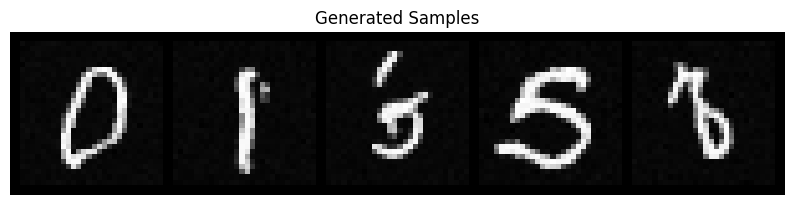

  Step 600/750, Loss: 0.0240
  Step 700/750, Loss: 0.0203

Training - Epoch 13 average loss: 0.0220
Running validation...
Validation - Epoch 13 average loss: 0.0221
Learning rate: 0.000008

Generating samples for visual progress check...


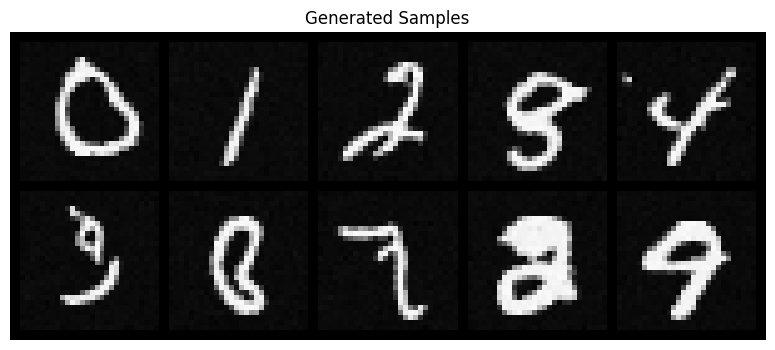

No improvement for 3/10 epochs

Epoch 14/60
--------------------
  Step 0/750, Loss: 0.0222
  Step 100/750, Loss: 0.0212
  Step 200/750, Loss: 0.0139
  Step 300/750, Loss: 0.0139
  Step 400/750, Loss: 0.0210
  Step 500/750, Loss: 0.0255
  Generating samples...


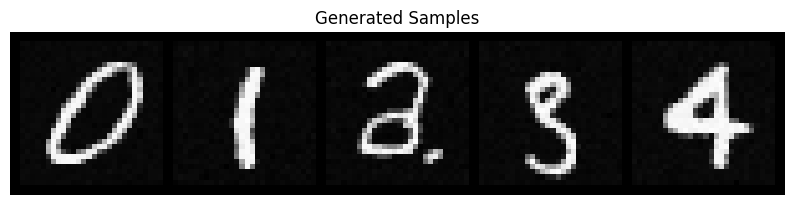

  Step 600/750, Loss: 0.0257
  Step 700/750, Loss: 0.0199

Training - Epoch 14 average loss: 0.0221
Running validation...
Validation - Epoch 14 average loss: 0.0221
Learning rate: 0.000008
No improvement for 4/10 epochs

Epoch 15/60
--------------------
  Step 0/750, Loss: 0.0184
  Step 100/750, Loss: 0.0304
  Step 200/750, Loss: 0.0253
  Step 300/750, Loss: 0.0298
  Step 400/750, Loss: 0.0237
  Step 500/750, Loss: 0.0236
  Generating samples...


In [ ]:
# Implementation of the main training loop
# Training configuration
early_stopping_patience = 10  # Number of epochs without improvement before stopping
gradient_clip_value = 1.0     # Maximum gradient norm for stability
display_frequency = 100       # How often to show progress (in steps)
generate_frequency = 500      # How often to generate samples (in steps)

# Progress tracking variables
best_loss = float('inf')
train_losses = []
val_losses = []
no_improve_epochs = 0

# Training loop
print("\n" + "="*50)
print("STARTING TRAINING")
print("="*50)
model.train()

# Wrap the training loop in a try-except block for better error handling:
# Your code for the training loop
# Hint: Use a try-except block for better error handling
# Process each epoch and each batch, with validation after each epoch

# Enter your code here:
try:
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        print("-" * 20)

        # Training phase
        model.train()
        epoch_losses = []

        # Process each batch
        for step, (images, labels) in enumerate(train_dataloader):  # Fixed: dataloader → train_dataloader
            images = images.to(device)
            labels = labels.to(device)

            # Training step
            optimizer.zero_grad()
            loss = train_step(images, labels)
            loss.backward()

            # Add gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip_value)

            optimizer.step()
            epoch_losses.append(loss.item())

            # Show progress at regular intervals
            if step % display_frequency == 0:
                print(f"  Step {step}/{len(train_dataloader)}, Loss: {loss.item():.4f}")

                # Generate samples less frequently to save time
                if step % generate_frequency == 0 and step > 0:
                    print("  Generating samples...")
                    generate_samples(model, n_samples=5)

        # End of epoch - calculate average training loss
        avg_train_loss = sum(epoch_losses) / len(epoch_losses)
        train_losses.append(avg_train_loss)
        print(f"\nTraining - Epoch {epoch+1} average loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        val_epoch_losses = []
        print("Running validation...")

        with torch.no_grad():  # Disable gradients for validation
            for val_images, val_labels in val_dataloader:
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                # Calculate validation loss
                val_loss = train_step(val_images, val_labels)
                val_epoch_losses.append(val_loss.item())

        # Calculate average validation loss
        avg_val_loss = sum(val_epoch_losses) / len(val_epoch_losses)
        val_losses.append(avg_val_loss)
        print(f"Validation - Epoch {epoch+1} average loss: {avg_val_loss:.4f}")

        # Learning rate scheduling based on validation loss
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Learning rate: {current_lr:.6f}")

        # Generate samples at the end of each epoch
        if epoch % 2 == 0 or epoch == EPOCHS - 1:
            print("\nGenerating samples for visual progress check...")
            generate_samples(model, n_samples=10)

        # Save best model based on validation loss
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            # Use safe_save_model instead of just saving state_dict
            safe_save_model(model, 'best_diffusion_model.pt', optimizer, epoch, best_loss)
            print(f"✓ New best model saved! (Val Loss: {best_loss:.4f})")
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            print(f"No improvement for {no_improve_epochs}/{early_stopping_patience} epochs")

        # Early stopping
        if no_improve_epochs >= early_stopping_patience:
            print("\nEarly stopping triggered! No improvement in validation loss.")
            break

        # Plot loss curves every few epochs
        if epoch % 5 == 0 or epoch == EPOCHS - 1:
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label='Training Loss')
            plt.plot(val_losses, label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training and Validation Loss')
            plt.legend()
            plt.grid(True)
            plt.show()
except Exception as e:
  print(f"Error in training loop: {e}")
  import traceback
  traceback.print_exc()



# Final wrap-up
print("\n" + "="*50)
print("TRAINING COMPLETE")
print("="*50)
print(f"Best validation loss: {best_loss:.4f}")

# Generate final samples
print("Generating final samples...")
generate_samples(model, n_samples=10)

# Display final loss curves
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Clean up memory
torch.cuda.empty_cache()